## This notebook implements the FeINFN method on the Pavia University Hyperspectral Image

Imports

In [1]:
import numpy as np
import scipy.io as sio
import time
import random
import cv2
from fvcore.nn import FlopCountAnalysis, parameter_count_table
import math
import os
from spectral import *
from tqdm import trange
from argparse import Namespace
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.special import gamma, kv, erf

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
import torchsummary
import torchprofile

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_random_seed()

Helper Functions

In [3]:
# Defining each PSF

kernel_size = 7
sigma = 3.40

def gaussian_psf(sigma, psf_size):
    """Generate a Gaussian PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf = psf / psf.sum()
    return psf
gaus_psf = gaussian_psf(sigma, kernel_size)

def kolmogorov_psf(sigma, psf_size):
    """Generate a Kolmogorov PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-(r / sigma)**(5/3))
    psf = psf / psf.sum()
    return psf
kol_psf = kolmogorov_psf(sigma, kernel_size)

def airy_psf(sigma, psf_size):
    """Generate an Airy PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    z = (2.33811 * r) / sigma
    psf = (2 * kv(1, z) / z)**2
    psf[r == 0] = 1
    psf = psf / psf.sum()
    return psf
air_psf = airy_psf(sigma, kernel_size)

def moffat_psf(sigma, psf_size, beta=3.5):
    """Generate a Moffat PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = (1 + (r / sigma)**2)**(-beta)
    psf = psf / psf.sum()
    return psf
mof_psf = moffat_psf(sigma, kernel_size)

def sinc_psf(sigma, psf_size):
    """Generate a Sinc PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.sinc(r / sigma)
    psf = psf / psf.sum()
    return psf
sinc_psf = sinc_psf(sigma, kernel_size)

def lorentzian_squared_psf(sigma, psf_size):
    """Generate a Lorentzian Squared PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = 1 / (1 + (r / sigma)**4)
    psf = psf / psf.sum()
    return psf
lor_sq_psf = lorentzian_squared_psf(sigma, kernel_size)

def hermite_psf(sigma, psf_size, n=1):
    """Generate a Hermite PSF."""
    from numpy.polynomial.hermite import hermval
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-r**2 / (2 * sigma**2)) * hermval(r / sigma, [0]*n + [1])
    psf = psf / psf.sum()
    return psf
her_psf = hermite_psf(sigma, kernel_size)

def parabolic_psf(sigma, psf_size):
    """Generate a Parabolic PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.maximum(0, 1 - (r / sigma)**2)
    psf = psf / psf.sum()
    return psf
par_psf = parabolic_psf(sigma, kernel_size)

def gabor_psf(sigma, psf_size, theta=0, lambd=1, gamma=0.5, psi=0):
    """Generate a Gabor PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    x_theta = X * np.cos(theta) + Y * np.sin(theta)
    y_theta = -X * np.sin(theta) + Y * np.cos(theta)
    psf = np.exp(-0.5 * (x_theta**2 + gamma**2 * y_theta**2) / sigma**2) * np.cos(2 * np.pi * x_theta / lambd + psi)
    psf = psf / psf.sum()
    return psf
gab_psf = gabor_psf(sigma, kernel_size)

def delta_function_psf(sigma, psf_size):
    """Generate a Delta Function PSF."""
    psf = np.zeros((2*psf_size+1, 2*psf_size+1))
    psf[psf_size, psf_size] = 1
    return psf
delta_psf = delta_function_psf(sigma, kernel_size)

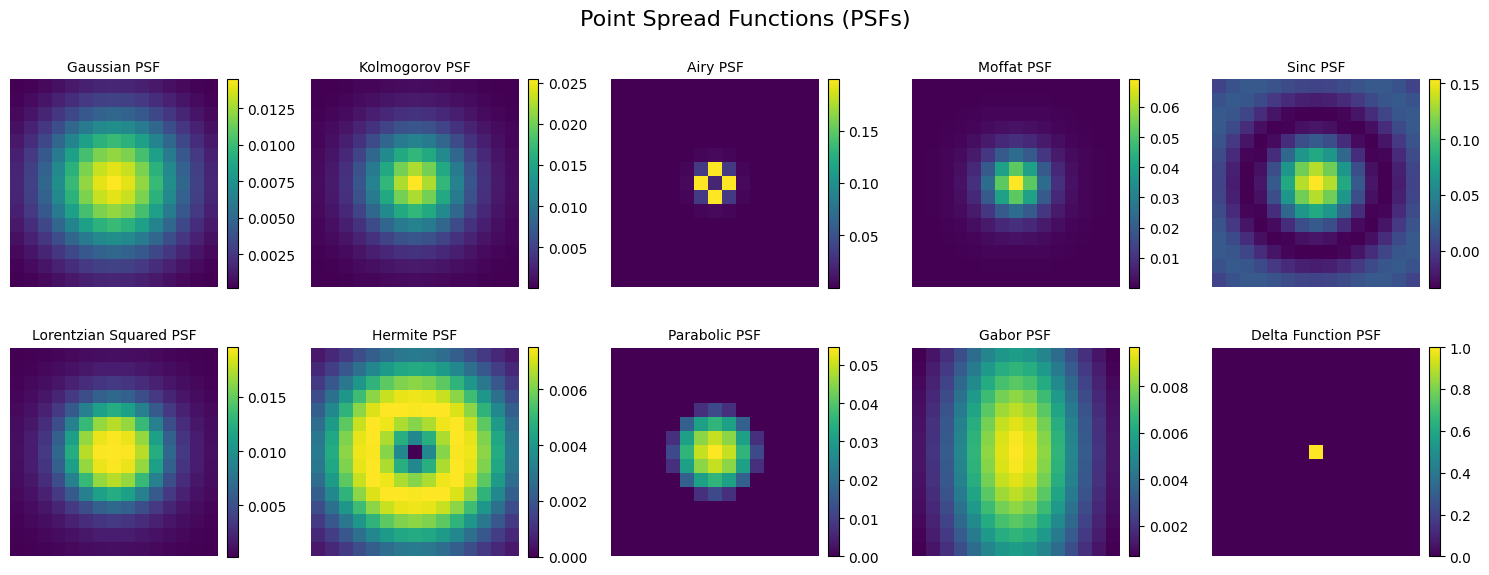

In [4]:
# Visualizing all the PSFs that will be used

psfs = [
    (gaus_psf, "Gaussian PSF"),
    (kol_psf, "Kolmogorov PSF"),
    (air_psf, "Airy PSF"),
    (mof_psf, "Moffat PSF"),
    (sinc_psf, "Sinc PSF"),
    (lor_sq_psf, "Lorentzian Squared PSF"),
    (her_psf, "Hermite PSF"),
    (par_psf, "Parabolic PSF"),
    (gab_psf, "Gabor PSF"),
    (delta_psf, "Delta Function PSF")
]

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 5 columns, 2 rows
fig.suptitle("Point Spread Functions (PSFs)", fontsize=16)

# Plot each PSF
for i, (psf, label) in enumerate(psfs):
    ax = axes[i // 5, i % 5]  # Determine subplot position
    im = ax.imshow(psf, cmap='viridis')
    ax.set_title(label, fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [5]:
# Function to apply PSF to an image
def apply_psf(image, psf):
    
    """
    Convolve each channel of 'image' with 'psf' using 'same' padding.

    Parameters:
    -----------
    image : np.ndarray
        Shape (height, width, channels).
    psf   : np.ndarray
        Shape (kernel_height, kernel_width).
        
    Returns:
    --------
    blurred_image : np.ndarray
        Same shape as input image (height, width, channels).
    """
    
    # Prepare an output array of the same shape as 'image'
    blurred_image = np.zeros_like(image, dtype=np.float32)

    # Convolve each channel separately
    channels = image.shape[2]
    for c in range(channels):
        # convolve2d with mode='same' replicates TensorFlow's 'SAME' padding
        blurred_image[:, :, c] = convolve2d(image[:, :, c], psf, mode='same')
        
    return blurred_image
    
# Function to downsample an image
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image
    
# Function to add noise to an image
def add_awgn_noise(hsi_image, SNR_dB):
    
    """
    Add AWGN (Additive White Gaussian Noise) to the input hsi_image,
    given a desired SNR in dB. Uses NumPy only.

    Parameters
    ----------
    hsi_image : np.ndarray
        Input image of shape (rows, cols, channels).
    SNR_dB : float
        Desired SNR in decibels.

    Returns
    -------
    noisy_hsi_image : np.ndarray
        Noisy image of the same shape as hsi_image.
    """

     # Ensure float32
    hsi_image = hsi_image.astype(np.float32)

    rows, cols, channels = hsi_image.shape

    # Compute the signal power for each channel
    # shape: (channels,)
    signal_power = np.mean(hsi_image ** 2, axis=(0, 1))

    # Convert SNR from dB to linear scale
    SNR_linear = 10 ** (SNR_dB / 10.0)

    # Compute noise power and noise standard deviation per channel
    noise_power = signal_power / SNR_linear  # shape: (channels,)
    noise_std = np.sqrt(noise_power)         # shape: (channels,)

    # Reshape for broadcasting across (rows, cols)
    noise_std = noise_std.reshape((1, 1, channels))

    # Generate white Gaussian noise
    noise = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(rows, cols, channels)
    ).astype(np.float32)

    # Scale noise by the computed standard deviation
    noise *= noise_std

    # Add noise to the original image
    noisy_hsi_image = hsi_image + noise

    return noisy_hsi_image
    
# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

# Function to obtain the Spectral Response Function for spectral degradation
def get_srf_bands(num_bands: int) -> np.ndarray:
    """
    Return a (num_bands, 3) array of [center_nm, low_edge_nm, high_edge_nm]
    matching the specified 'num_bands' from {1,3,4,8,16}.
    
    1-band  => IKONOS Panchromatic
    3-bands => IKONOS RGB
    4-bands => IKONOS B, G, R, NIR
    8-bands => WorldView-2 
    16-bands => WorldView-3

    Raises ValueError if num_bands is not in [1,3,4,8,16].
    """

    if num_bands == 1:
        # IKONOS panchromatic
        band_specs = np.array([
            [729.0, 409.0, 1048.0]  # center, lower, upper
        ], dtype=np.float32)
    
    elif num_bands == 3:
        # IKONOS RGB
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)
    
    elif num_bands == 4:
        # IKONOS B, G, R, NIR
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
            [803.0, 713.0, 893.0],  # NIR
        ], dtype=np.float32)

    elif num_bands == 8:
        # WorldView-2
        band_specs = np.array([
            [427.0, 396.0, 458.0],  # Coastal Blue
            [478.0, 442.0, 515.0],  # Blue
            [546.0, 506.0, 586.0],  # Green
            [608.0, 584.0, 632.0],  # Yellow
            [659.0, 624.0, 694.0],  # Red
            [724.0, 699.0, 749.0],  # Red Edge
            [833.0, 765.0, 901.0],  # NIR1
            [949.0, 856.0, 1043.0], # NIR2
        ], dtype=np.float32)
    
    elif num_bands == 16:
        # WorldView-3
        band_specs = np.array([
            [426.0, 397.0, 454.0],    # Coastal Blue
            [481.0, 445.0, 517.0],    # Blue
            [547.0, 507.0, 586.0],    # Green
            [605.0, 580.0, 629.0],    # Yellow
            [661.0, 626.0, 696.0],    # Red
            [724.0, 698.0, 749.0],    # Red Edge
            [832.0, 765.0, 899.0],    # NIR1
            [948.0, 857.0, 1039.0],   # NIR2
            [1210.0, 1184.0, 1235.0], # SWIR1
            [1572.0, 1546.0, 1598.0], # SWIR2
            [1661.0, 1636.0, 1686.0], # SWIR3
            [1730.0, 1702.0, 1759.0], # SWIR4
            [2164.0, 2137.0, 2191.0], # SWIR5
            [2203.0, 2174.0, 2232.0], # SWIR6
            [2260.0, 2228.0, 2292.0], # SWIR7
            [2329.0, 2285.0, 2373.0], # SWIR8
        ], dtype=np.float32)
    
    else:
        raise ValueError(f"Unsupported num_bands={num_bands}. Must be 1,3,4,8, or 16.")

    return band_specs
    
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
        Examples: 
            - 1-band IKONOS Panchromatic 
            - 3-band IKONOS RGB 
            - 4-band IKONOS (B,G,R,NIR) 
            - 8-band WorldView-2 
            - 16-band WorldView-3
        etc.
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [6]:
# Function to visualize an HSI
def visualize_hsi(img1, img2, bands, title1, title2):
    """
    Visualize two hyperspectral images side by side using RGB representations.

    Parameters:
    -----------
    img1 : np.ndarray
        First hyperspectral image.
    img2 : np.ndarray
        Second hyperspectral image.
    bands : tuple
        Band indices to use for RGB representation (applied to both images).
    title1 : str
        Title for the first image.
    title2 : str
        Title for the second image.
    """
    rgb1 = get_rgb(img1, bands)
    rgb2 = get_rgb(img2, bands)

    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    axs[0].imshow(rgb1)
    axs[0].set_title(title1)
    axs[0].axis('on')

    axs[1].imshow(rgb2)
    axs[1].set_title(title2)
    axs[1].axis('on')

    plt.tight_layout()
    plt.show()

# Function to visualize an MSI/RGB/Panchromatic image along with the SRF
def plot_multispectral_with_srf(ms_image1, ms_image2, bands, title1, title2, srf, wavelengths, ikonos_bands):
    """
    Visualize a multispectral (or RGB/panchromatic) image alongside its Spectral Response Function (SRF).
    
    Parameters
    ----------
    ms_image1 : np.ndarray
        First multispectral image, shape: (H, W, num_bands).
    ms_image2 : np.ndarray
        Second multispectral image, shape: (H2, W2, num_bands).
    bands : tuple
        Band indices to use for RGB visualization (must be valid for both images).
    title1 : str
        Title for the first image.
    title2 : str
        Title for the second image.
    srf : np.ndarray
        Spectral Response Function, shape: (num_bands, L).
    wavelengths : np.ndarray
        Wavelengths corresponding to the L hyperspectral bands.
    ikonos_bands : np.ndarray
        Array of shape (num_bands, 3) with [center_nm, low_edge_nm, high_edge_nm] per band.
    
    Notes
    -----
    - This function assumes num_bands is one of {1,3,4,8,16}.
    - If num_bands=1, we skip get_rgb and just display a grayscale single-band image.
    - If num_bands=3,4,8,16, we attempt to display an RGB image using 'bands' for the channel ordering.
    - The SRF curve colors and labels are chosen via if/elif blocks, 
      matching each possible number of bands.
    """
    num_bands = ms_image1.shape[2]
    assert ms_image2.shape[2] == num_bands, "Both MSI images must have the same number of bands"

    # Pick labels and colors based on number of bands
    if num_bands == 1:
        band_labels = ["Panchromatic"]
        band_colors = ["k"]
    elif num_bands == 3:
        band_labels = ["Blue", "Green", "Red"]
        band_colors = ["b", "g", "r"]
    elif num_bands == 4:
        band_labels = ["Blue", "Green", "Red", "NIR"]
        band_colors = ["b", "g", "r", "k"]
    elif num_bands == 8:
        band_labels = ["Coastal", "Blue", "Green", "Yellow", 
                       "Red", "Red Edge", "NIR1", "NIR2"]
        band_colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]
    elif num_bands == 16:
        band_labels = [
            "Coastal Blue", "Blue", "Green", "Yellow", 
            "Red", "Red Edge", "NIR1", "NIR2",
            "SWIR1", "SWIR2", "SWIR3", "SWIR4",
            "SWIR5", "SWIR6", "SWIR7", "SWIR8"
        ]
        band_colors = [
            "b", "g", "r", "c", "m", "y", "k", "orange", 
            "purple", "brown", "pink", "gray", 
            "olive", "navy", "teal", "maroon"
        ]
    else:
        raise ValueError("Function only supports images with 1, 3, 4, 8, or 16 bands.")

    # Create figure with 3 subplots (2 for images, 1 for SRF)
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Plot first image
    if num_bands == 1:
        axs[0].imshow(ms_image1[:, :, 0], cmap='gray')
        axs[0].set_title(title1 + " (Panchromatic)")
    else:
        rgb1 = get_rgb(ms_image1, bands)
        axs[0].imshow(rgb1)
        axs[0].set_title(title1)
    axs[0].axis('off')

    # Plot second image
    if num_bands == 1:
        axs[1].imshow(ms_image2[:, :, 0], cmap='gray')
        axs[1].set_title(title2 + " (Panchromatic)")
    else:
        rgb2 = get_rgb(ms_image2, bands)
        axs[1].imshow(rgb2)
        axs[1].set_title(title2)
    axs[1].axis('off')

    # Plot SRF
    for i in range(num_bands):
        center_nm = ikonos_bands[i, 0]
        axs[2].plot(
            wavelengths,
            srf[i, :],
            label=f'{band_labels[i]} (Center: {center_nm} nm)',
            color=band_colors[i]
        )
    axs[2].set_xlabel('Wavelength (nm)')
    axs[2].set_ylabel('Spectral Response')
    axs[2].set_title('Spectral Response Functions (SRF)')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
    
# Function to plot the spectra at input pixels  
def plot_spectra(ground_truth_hsi, super_resolved_hsi, x, y):
    """
    Plotting the spectra of two hyperspectral images at a specific pixel location.
    
    Inputs:
    ground_truth_hsi (numpy.ndarray): The ground truth hyperspectral image
    super_resolved_hsi (numpy.ndarray): The super resolved hyperspectral image (output of model)
    x (int): The x pixel location
    y (int): The y pixel location
    """
    
    ground_truth_hsi = ground_truth_hsi.astype(np.float32)
    super_resolved_hsi = super_resolved_hsi.astype(np.float32)
    
    # Extract the spectra at the specific pixel location (x,y)
    ground_truth_spectra = ground_truth_hsi[y, x, :]
    super_resolved_spectra = super_resolved_hsi[y, x, :]
    
    # Number of spectral bands
    num_bands = ground_truth_hsi.shape[2]
    print("Number of bands = ", num_bands)
    
    # Plot the spectra
    plt.figure(figsize=(10,5))
    plt.plot(range(num_bands), ground_truth_spectra, label='Ground Truth Spectra')
    plt.plot(range(num_bands), super_resolved_spectra, label='Super Resolved Spectra')
    
    # Add labels and title
    plt.xlabel('Spectral band')
    plt.ylabel('Reflectance')
    plt.title(f'Spectra at pixel location (x={x}, y={y})')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Synthetic input generation functions

In [7]:
# Function to spatially degrade an image
def spatial_degradation(image, psf, downsample_ratio, SNR):
    """
    Apply spatial degradation to an image.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image.
    psf : np.ndarray
        Point Spread Function.
    downsample_ratio : int
        Factor by which to downsample.
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    
    Returns:
    --------
    degraded_image : np.ndarray
        Spatially degraded image.
    """
    I_HS = normalize(image)
    I_HS = apply_psf(I_HS, psf)
    I_HS = downsample_image(I_HS, downsample_ratio)
    I_HS = add_awgn_noise(I_HS, SNR)
    return I_HS

# Function to spectrally degrade an image
def spectral_degradation(image, SNR, num_bands=4, fwhm_factor=4.3):
    """
    Apply spectral degradation to an image.
    
    Parameters
    ----------
    image : np.ndarray
        Input HSI image, shape (rows, cols, L).
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    num_bands : int
        Desired number of output bands. Must be one of {1,3,4,8,16}.
        1 => IKONOS Panchromatic
        3 => IKONOS RGB
        4 => IKONOS B/G/R/NIR
        8 => WorldView-2
        16 => WorldView-3
    fwhm_factor : float
        Factor to approximate std dev from (upper_edge - lower_edge).
        Default=4.2 is typical for a rough Gaussian FWHM approximation.

    Returns
    -------
    I_MS : np.ndarray
        Spectrally degraded image of shape (rows, cols, num_bands).
    srf : np.ndarray
        The sensor SRF curves, shape (num_bands, L).
    band_specs : np.ndarray
        The band specs used, shape (num_bands, 3).
    auto_wavelengths : np.ndarray
        The automatically generated wavelengths, shape (L,).
    """
    
    # 1) Fetch the band specs for the desired sensor configuration
    band_specs = get_srf_bands(num_bands)

    # 2) Normalize the image to [0,1] (or however your normalize function works)
    I_MS = normalize(image)

    # 3) Apply the SRF to produce the 'multispectral' (or panchromatic/RGB) image
    I_MS, srf, auto_wavelengths = apply_srf(I_MS, band_specs, fwhm_factor=fwhm_factor)

    # 4) Add AWGN noise
    I_MS = add_awgn_noise(I_MS, SNR)

    # 5) Return the result plus info you might need for plotting or further usage
    return I_MS, srf, band_specs, auto_wavelengths

Importing and degrading the Pavia University HSI

In [8]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Synthetic_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
mat_file_path = os.path.join(normalized_dataset_path, 'Pavia_University_data.mat')

In [9]:
def split_train_test(image, split_index):
    return image[:split_index], image[split_index:]

# Split HR MSI (same resolution, just varying bands)
def split_msi(msi_image):
    return split_train_test(msi_image, 480)

# Split LR HSI based on downsampling factor
def split_lr_hsi(hsi_image, downsample_factor):
    split_index = int(480 / downsample_factor)
    return split_train_test(hsi_image, split_index)

Setting up and visualizing the ground truth and MSI, Pan, RGB images

Ground truth train shape:  (480, 320, 103)
Ground truth test shape:  (128, 320, 103)


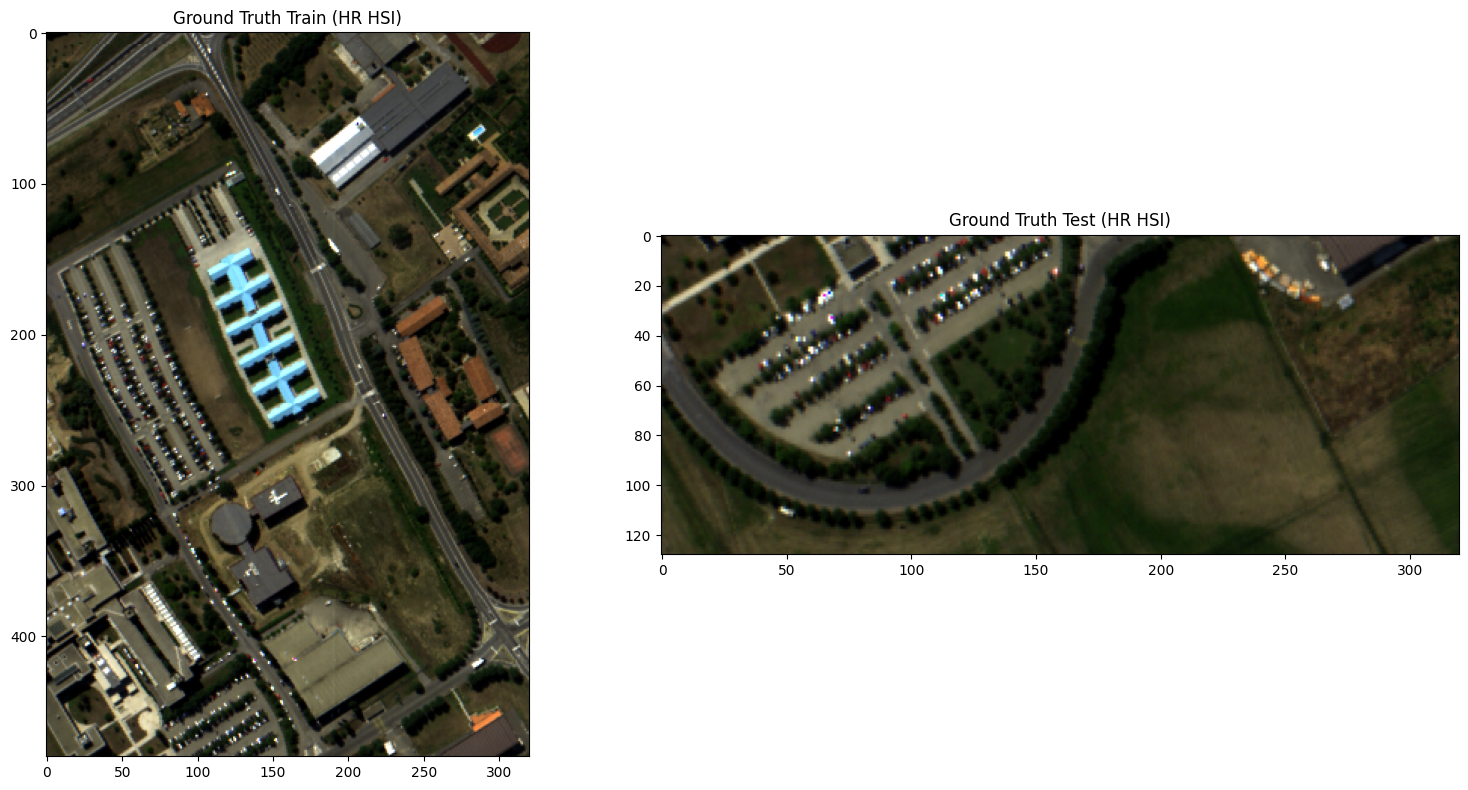

MSI train shape:  (480, 320, 1)
MSI test shape:  (128, 320, 1)


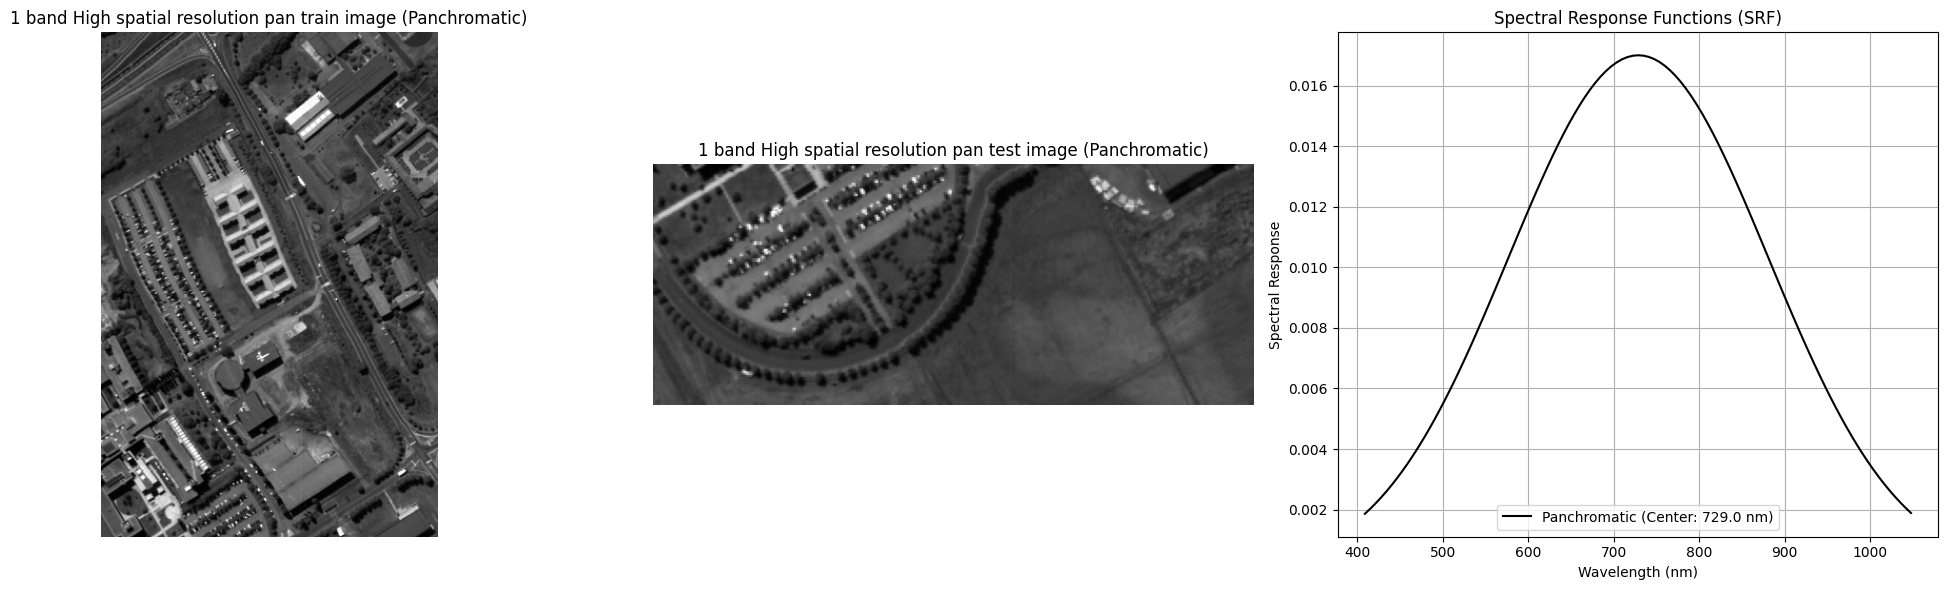

MSI train shape:  (480, 320, 3)
MSI test shape:  (128, 320, 3)


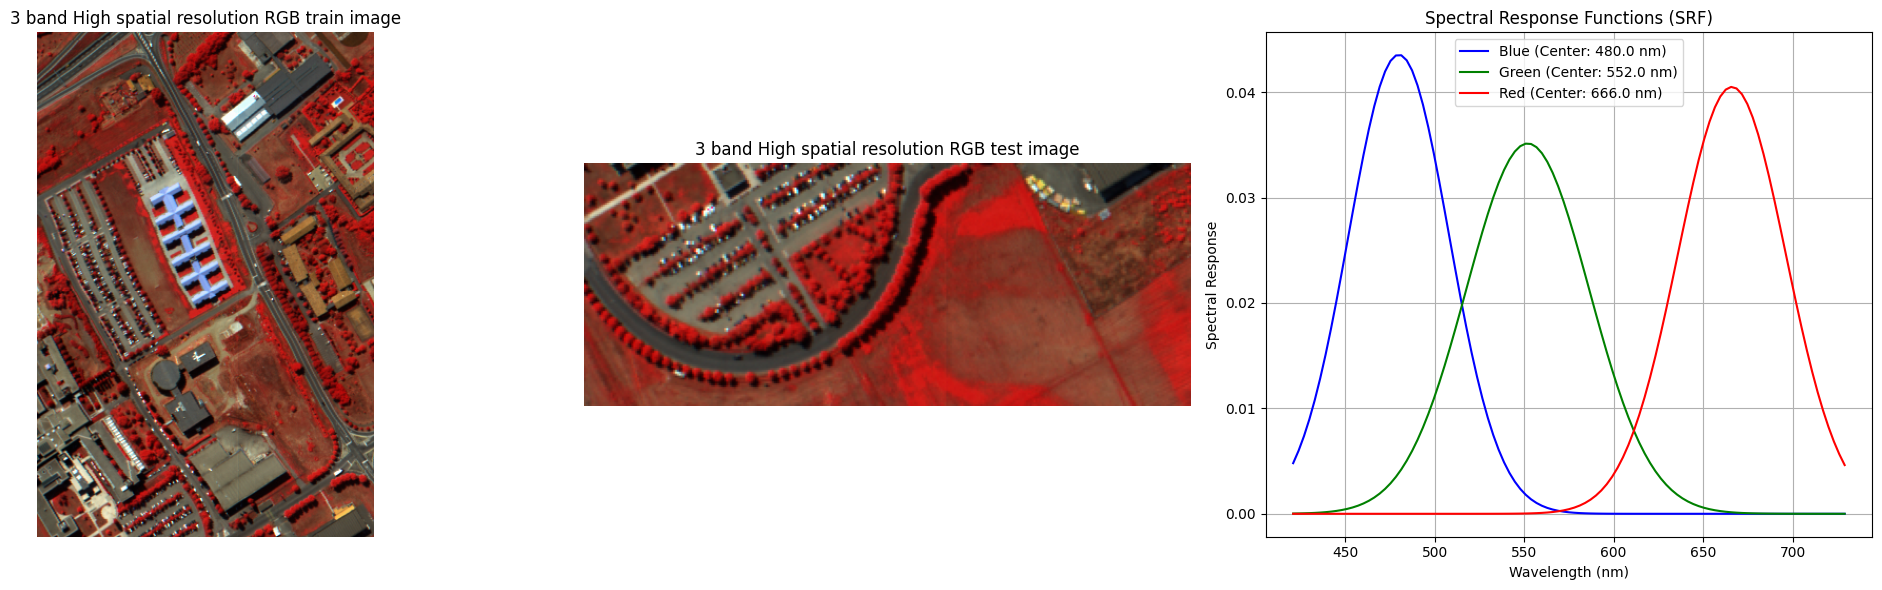

MSI train shape:  (480, 320, 4)
MSI test shape:  (128, 320, 4)


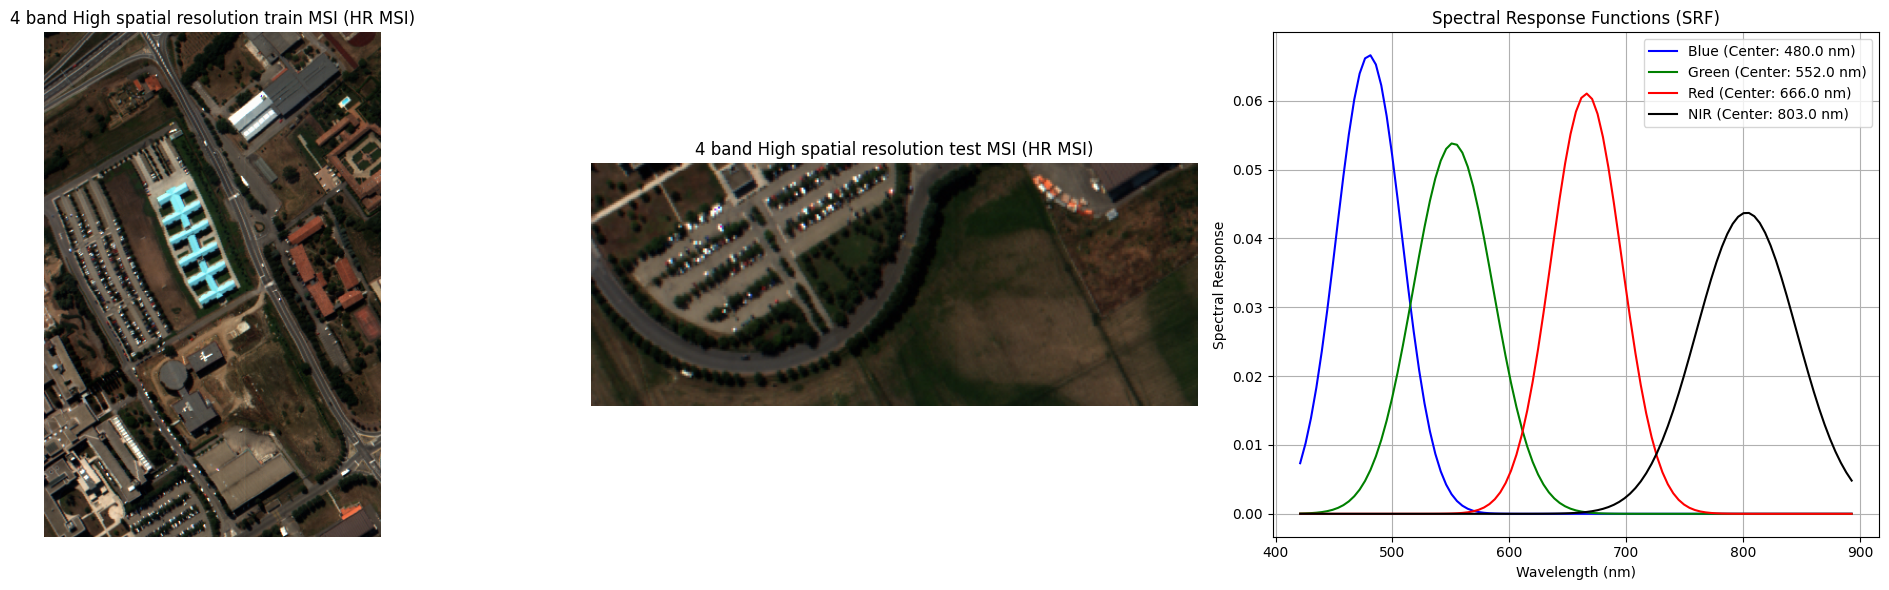

MSI train shape:  (480, 320, 8)
MSI test shape:  (128, 320, 8)


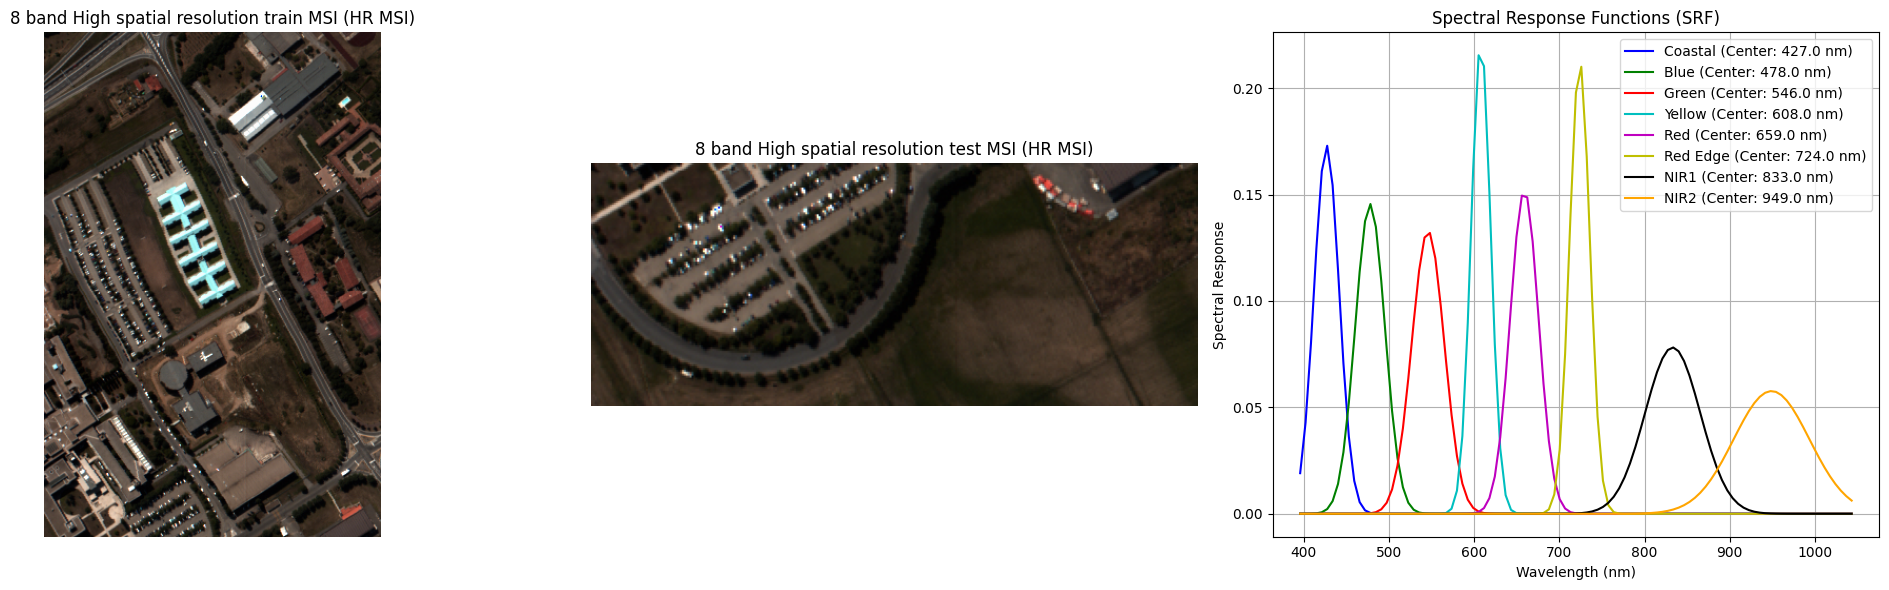

MSI train shape:  (480, 320, 16)
MSI test shape:  (128, 320, 16)


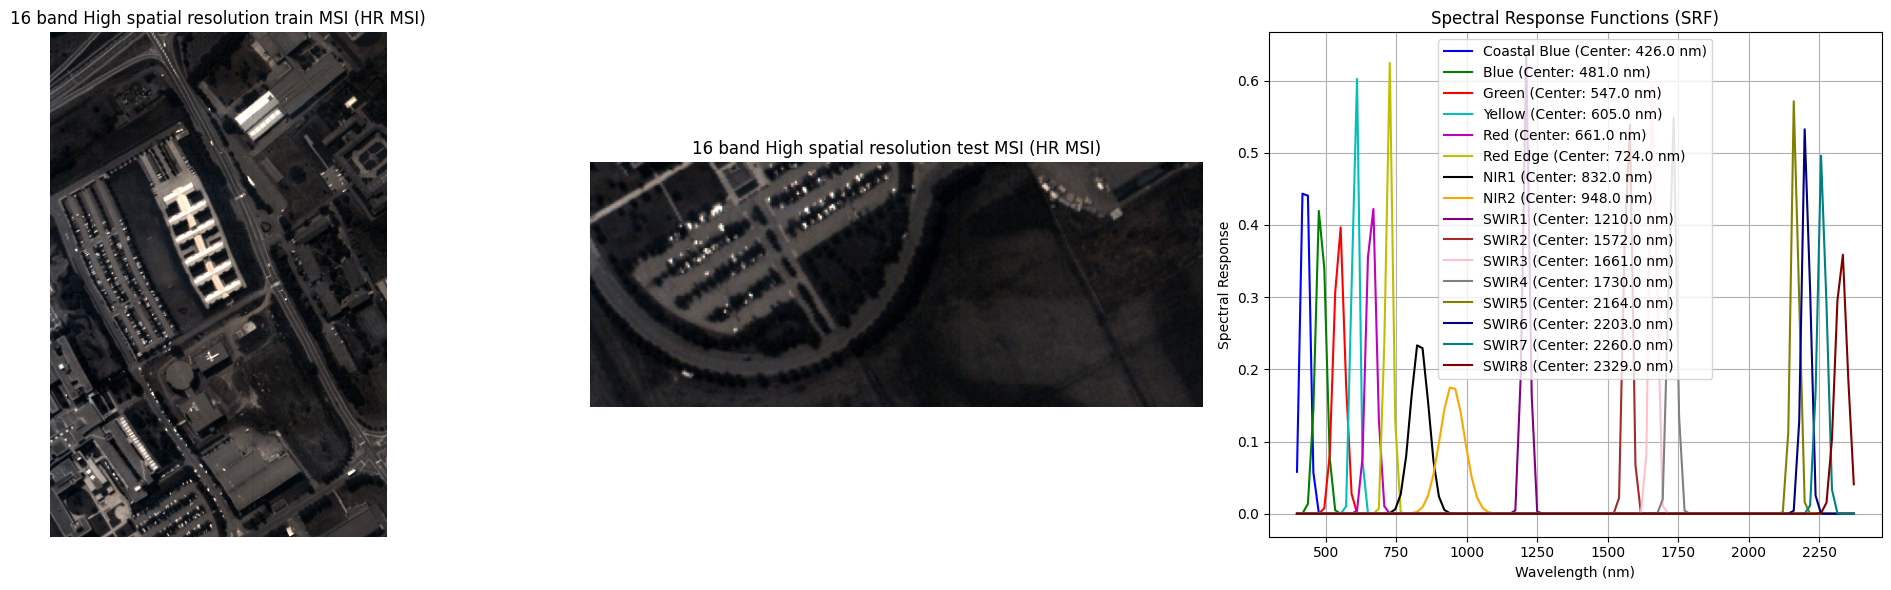

In [10]:
pavia_university = sio.loadmat(mat_file_path)
pavia_university_image = pavia_university['paviaU']
pavia_university_image = pavia_university_image[:608, :320, :]

# Ground Truth HR HSI (H, W, C)
I_REF = normalize(pavia_university_image)
I_REF_train, I_REF_test = split_msi(I_REF)
print("Ground truth train shape: ", I_REF_train.shape)
print("Ground truth test shape: ", I_REF_test.shape)
visualize_hsi(I_REF_train, I_REF_test, (50,35,15), "Ground Truth Train (HR HSI)", "Ground Truth Test (HR HSI)")

# High Resolution MSI with 1 band
I_MS_1, srf_1, band_specs_1, auto_wavs_1 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=1, fwhm_factor=4.2)
I_MS_1_train, I_MS_1_test = split_msi(I_MS_1)
print("MSI train shape: ", I_MS_1_train.shape)
print("MSI test shape: ", I_MS_1_test.shape)
plot_multispectral_with_srf(I_MS_1_train, I_MS_1_test, None, "1 band High spatial resolution pan train image", "1 band High spatial resolution pan test image", srf_1, auto_wavs_1, band_specs_1)

# High Resolution MSI with 3 bands
I_MS_3, srf_3, band_specs_3, auto_wavs_3 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=3, fwhm_factor=4.2)
I_MS_3_train, I_MS_3_test = split_msi(I_MS_3)
print("MSI train shape: ", I_MS_3_train.shape)
print("MSI test shape: ", I_MS_3_test.shape)
plot_multispectral_with_srf(I_MS_3_train, I_MS_3_test, (2,1,0), "3 band High spatial resolution RGB train image", "3 band High spatial resolution RGB test image", srf_3, auto_wavs_3, band_specs_3)

# High Resolution MSI with 4 bands
I_MS_4, srf_4, band_specs_4, auto_wavs_4 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=4, fwhm_factor=4.2)
I_MS_4_train, I_MS_4_test = split_msi(I_MS_4)
print("MSI train shape: ", I_MS_4_train.shape)
print("MSI test shape: ", I_MS_4_test.shape)
plot_multispectral_with_srf(I_MS_4_train, I_MS_4_test, (2,1,0), "4 band High spatial resolution train MSI (HR MSI)", "4 band High spatial resolution test MSI (HR MSI)", srf_4, auto_wavs_4, band_specs_4)

# High Resolution MSI with 8 bands
I_MS_8, srf_8, band_specs_8, auto_wavs_8 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=8, fwhm_factor=4.2)
I_MS_8_train, I_MS_8_test = split_msi(I_MS_8)
print("MSI train shape: ", I_MS_8_train.shape)
print("MSI test shape: ", I_MS_8_test.shape)
plot_multispectral_with_srf(I_MS_8_train, I_MS_8_test, (4,2,1), "8 band High spatial resolution train MSI (HR MSI)", "8 band High spatial resolution test MSI (HR MSI)", srf_8, auto_wavs_8, band_specs_8)

# High Resolution MSI with 16 bands
I_MS_16, srf_16, band_specs_16, auto_wavs_16 = spectral_degradation(image=pavia_university_image, SNR=40, num_bands=16, fwhm_factor=4.2)
I_MS_16_train, I_MS_16_test = split_msi(I_MS_16)
print("MSI train shape: ", I_MS_16_train.shape)
print("MSI test shape: ", I_MS_16_test.shape)
plot_multispectral_with_srf(I_MS_16_train, I_MS_16_test, (4,2,1), "16 band High spatial resolution train MSI (HR MSI)", "16 band High spatial resolution test MSI (HR MSI)", srf_16, auto_wavs_16, band_specs_16)

Setting up and visualizing the HSI images with Gaussian PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


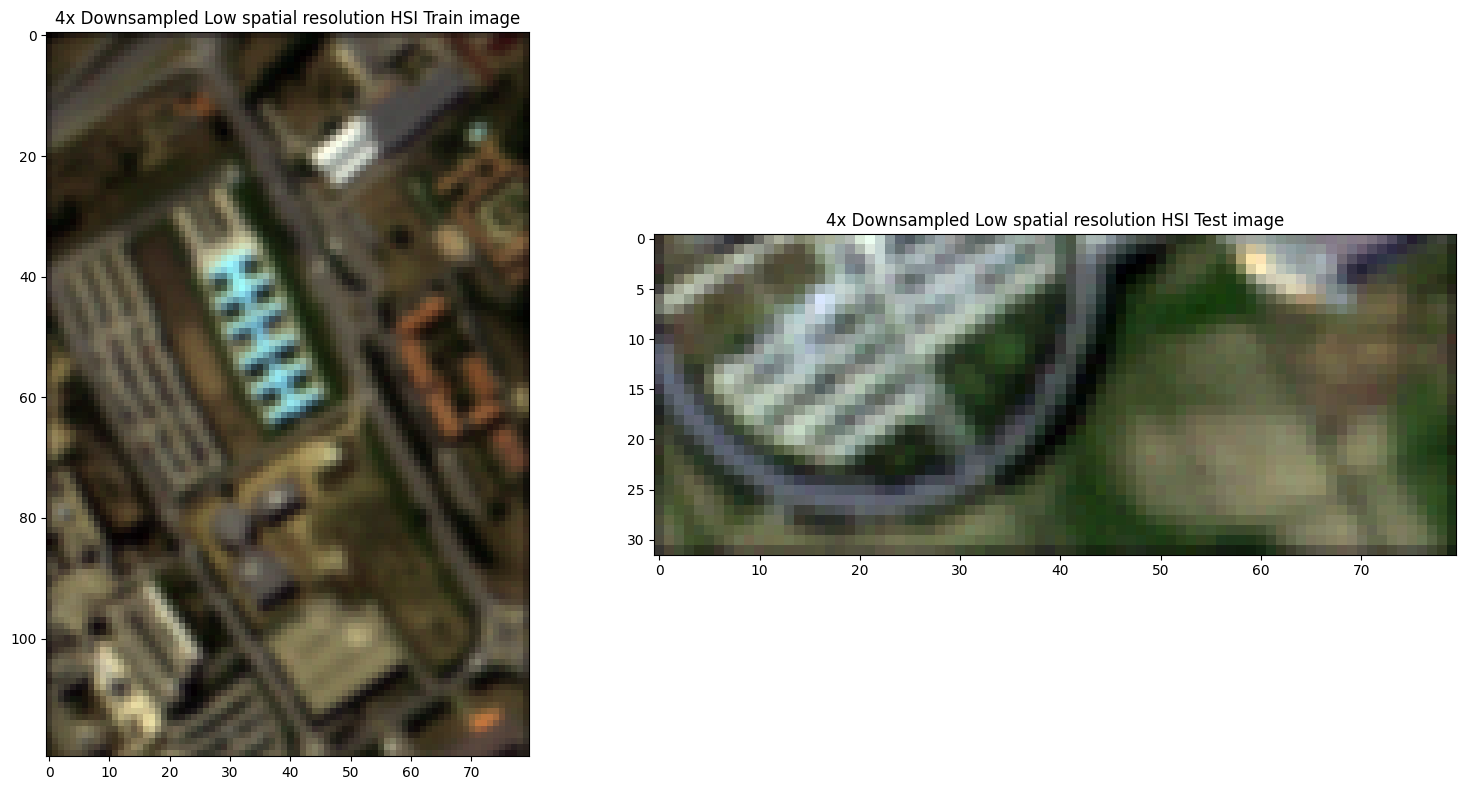

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


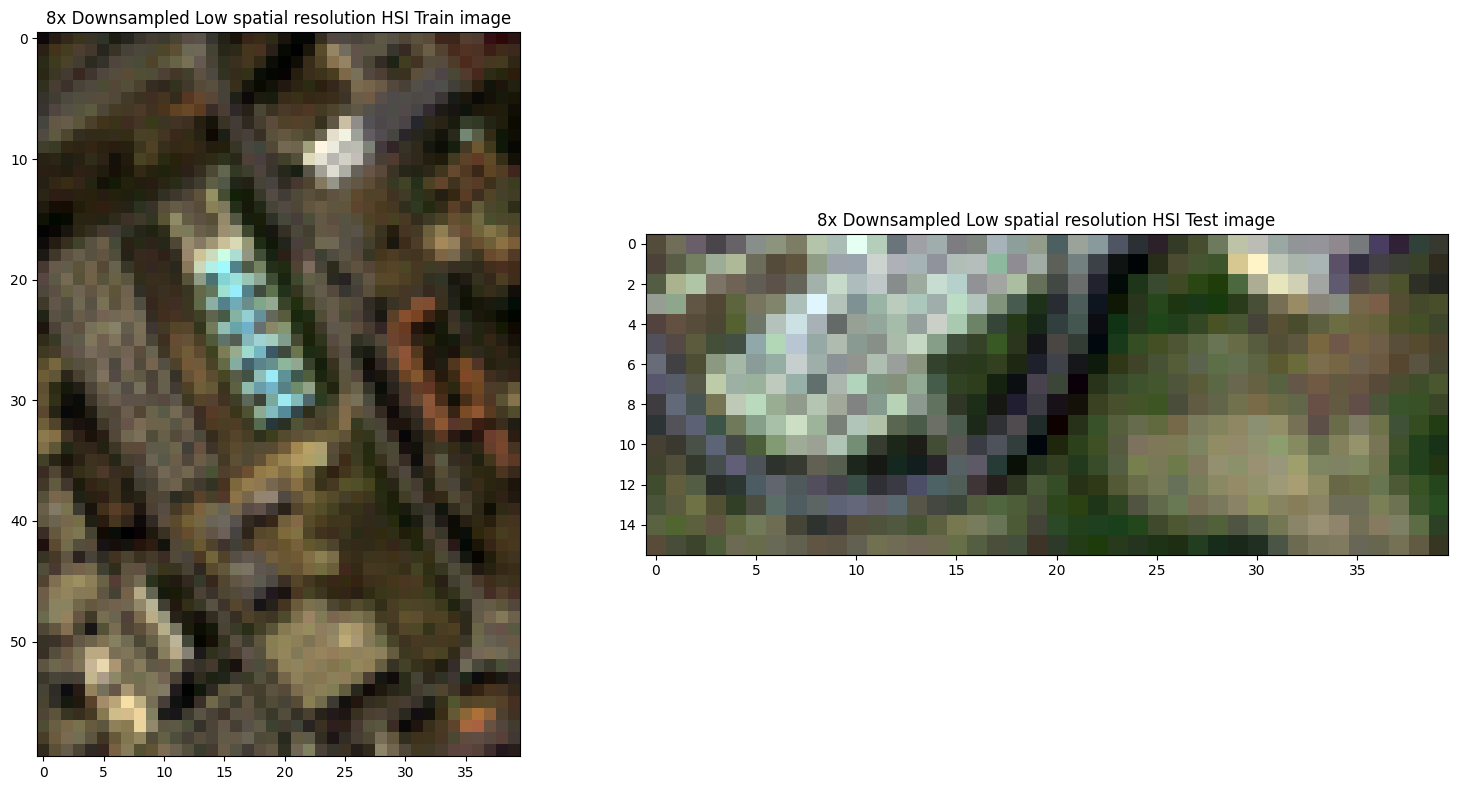

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


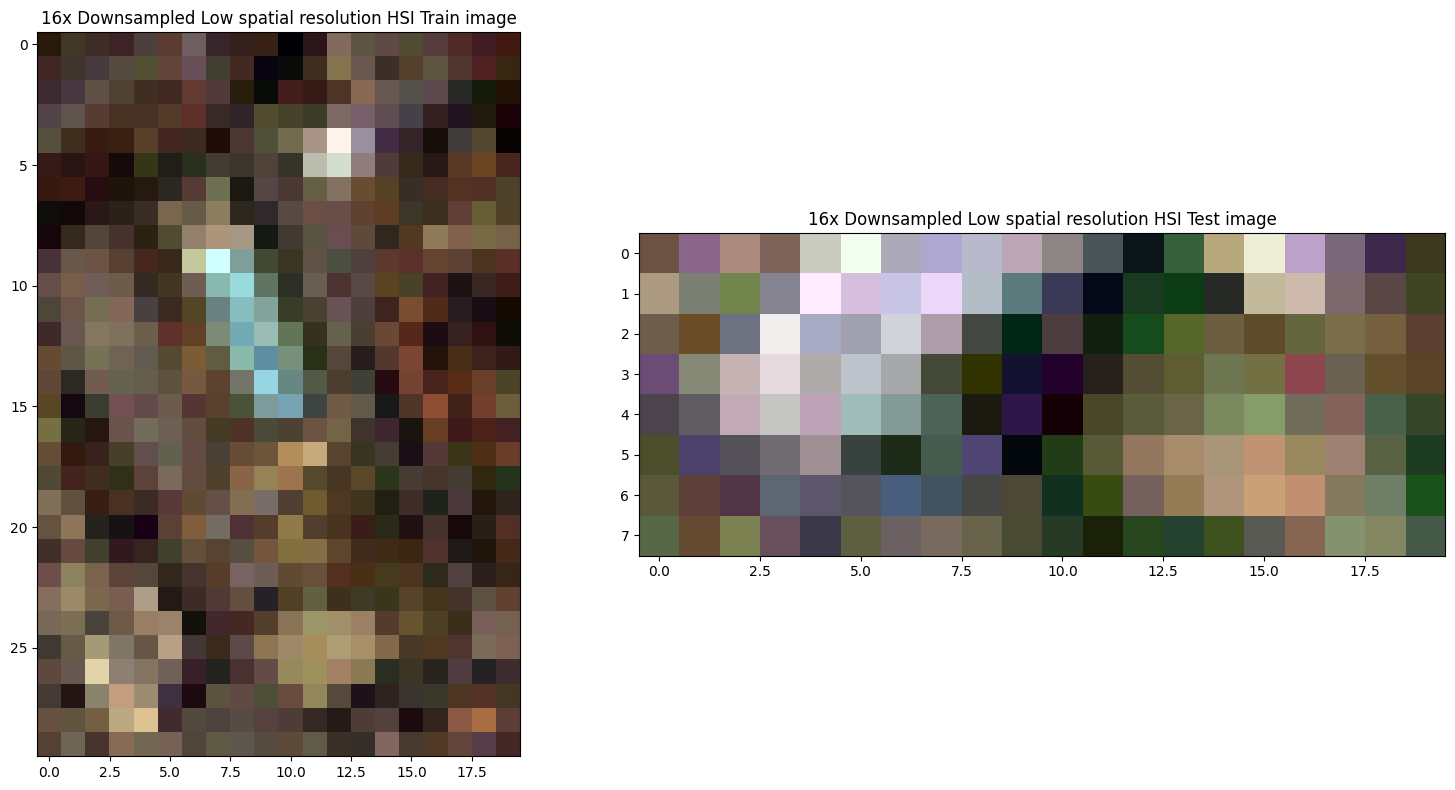

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


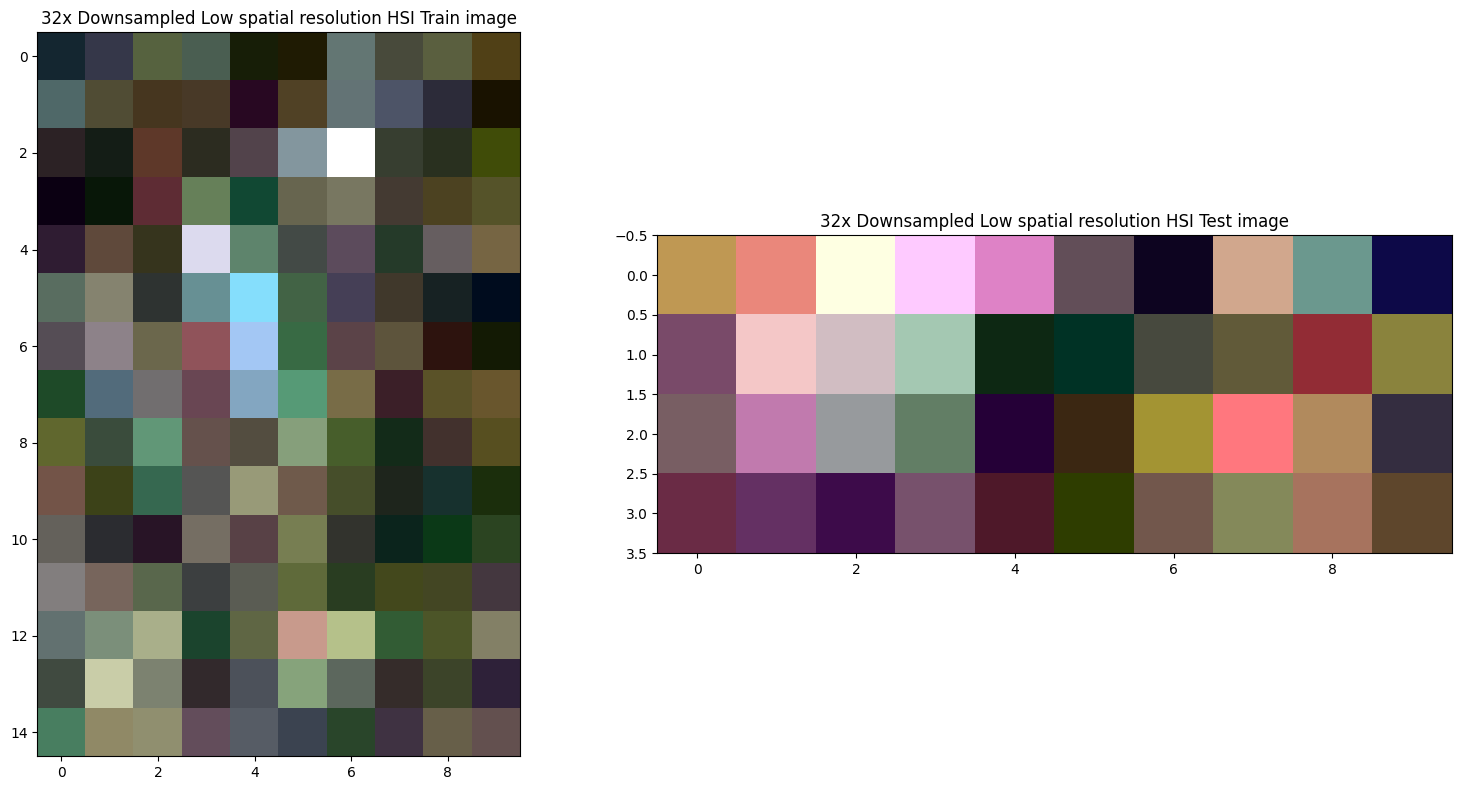

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gaus = spatial_degradation(pavia_university_image, gaus_psf, 4, 35)
I_HS_4_train_gaus, I_HS_4_test_gaus = split_lr_hsi(I_HS_4_gaus, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_gaus.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_gaus.shape)
visualize_hsi(I_HS_4_train_gaus, I_HS_4_test_gaus, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gaus = spatial_degradation(pavia_university_image, gaus_psf, 8, 30)
I_HS_8_train_gaus, I_HS_8_test_gaus = split_lr_hsi(I_HS_8_gaus, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_gaus.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_gaus.shape)
visualize_hsi(I_HS_8_train_gaus, I_HS_8_test_gaus, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gaus = spatial_degradation(pavia_university_image, gaus_psf, 16, 25)
I_HS_16_train_gaus, I_HS_16_test_gaus = split_lr_hsi(I_HS_16_gaus, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_gaus.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_gaus.shape)
visualize_hsi(I_HS_16_train_gaus, I_HS_16_test_gaus, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gaus = spatial_degradation(pavia_university_image, gaus_psf, 32, 20)
I_HS_32_train_gaus, I_HS_32_test_gaus = split_lr_hsi(I_HS_32_gaus, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_gaus.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_gaus.shape)
visualize_hsi(I_HS_32_train_gaus, I_HS_32_test_gaus, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Kolmogorov PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


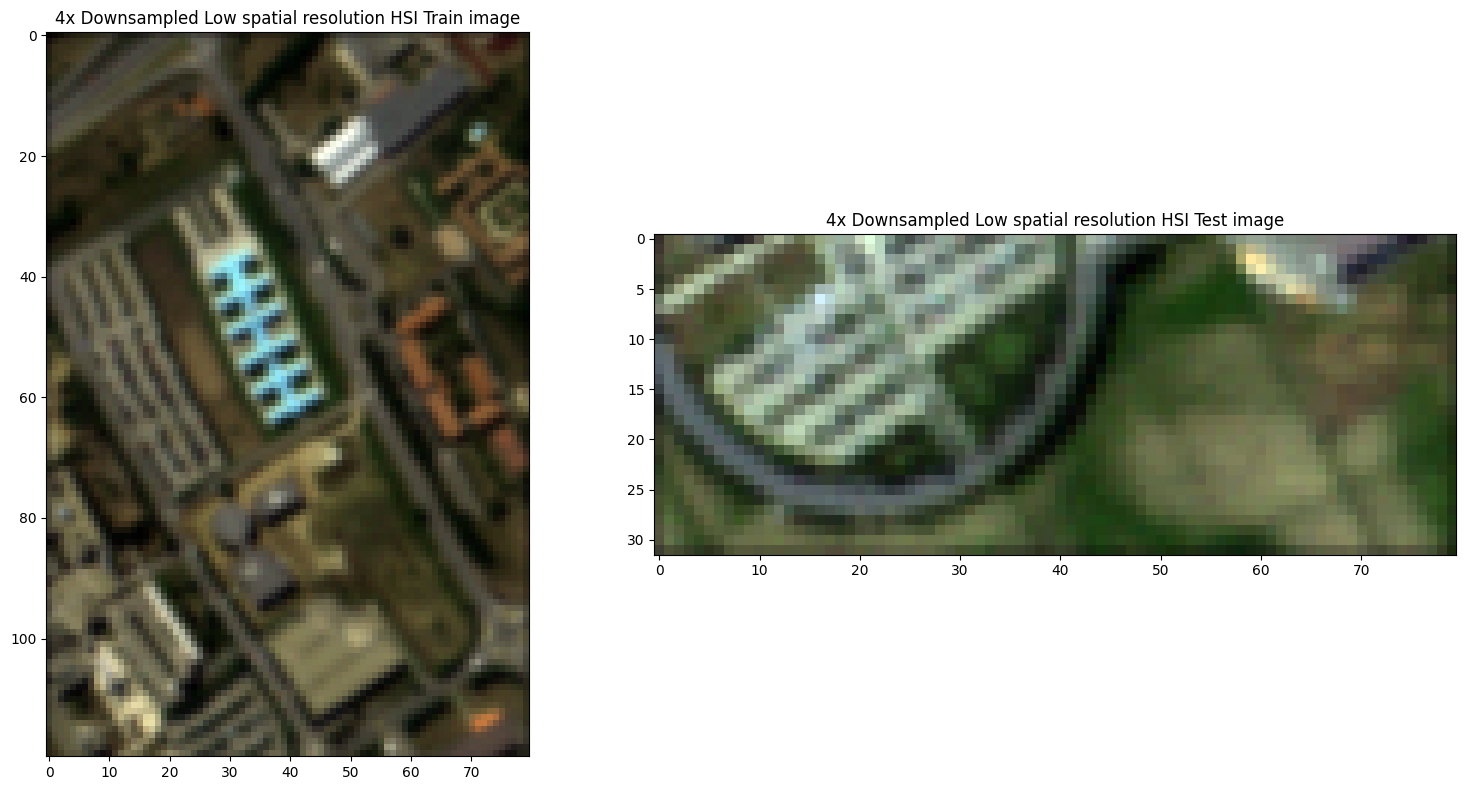

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


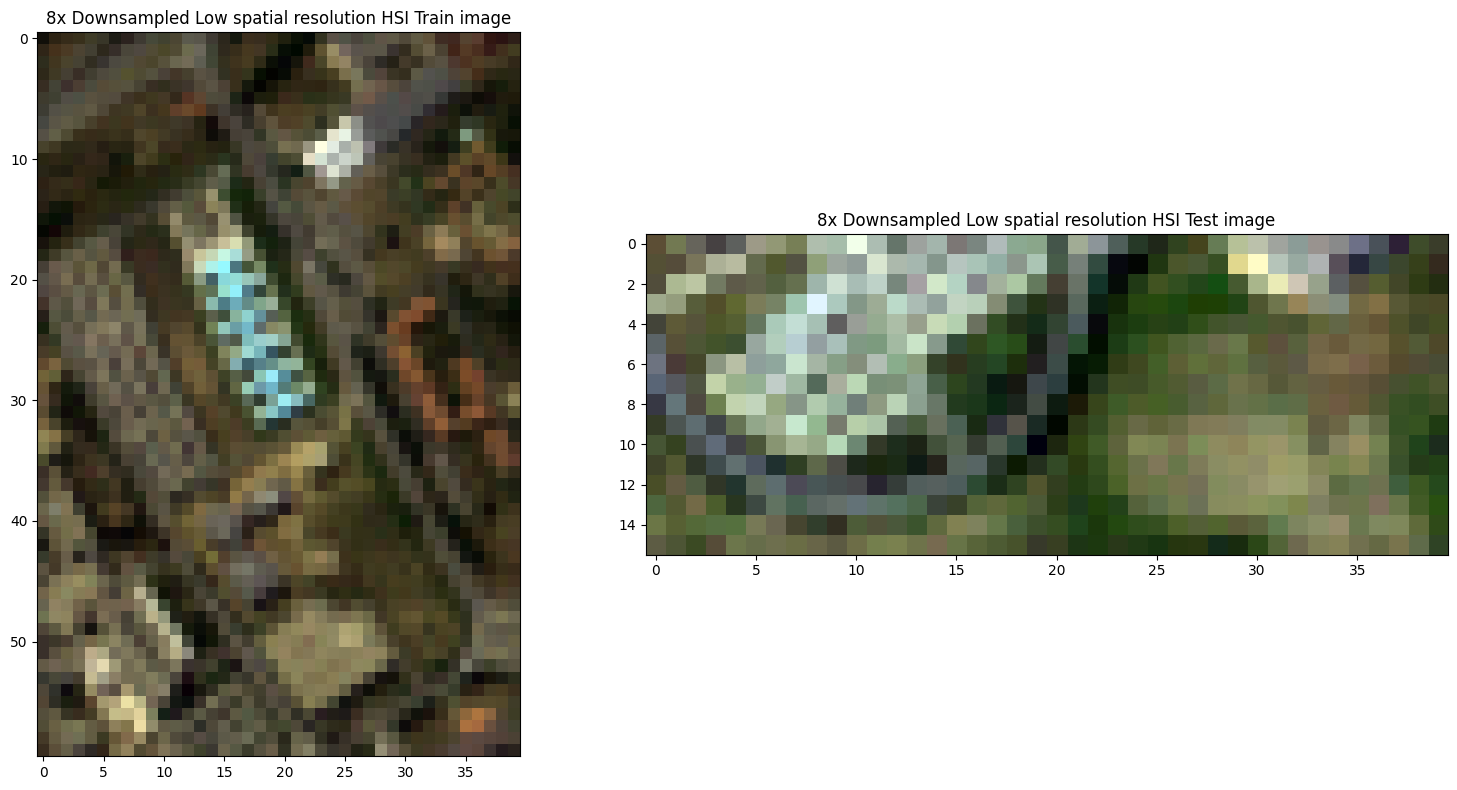

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


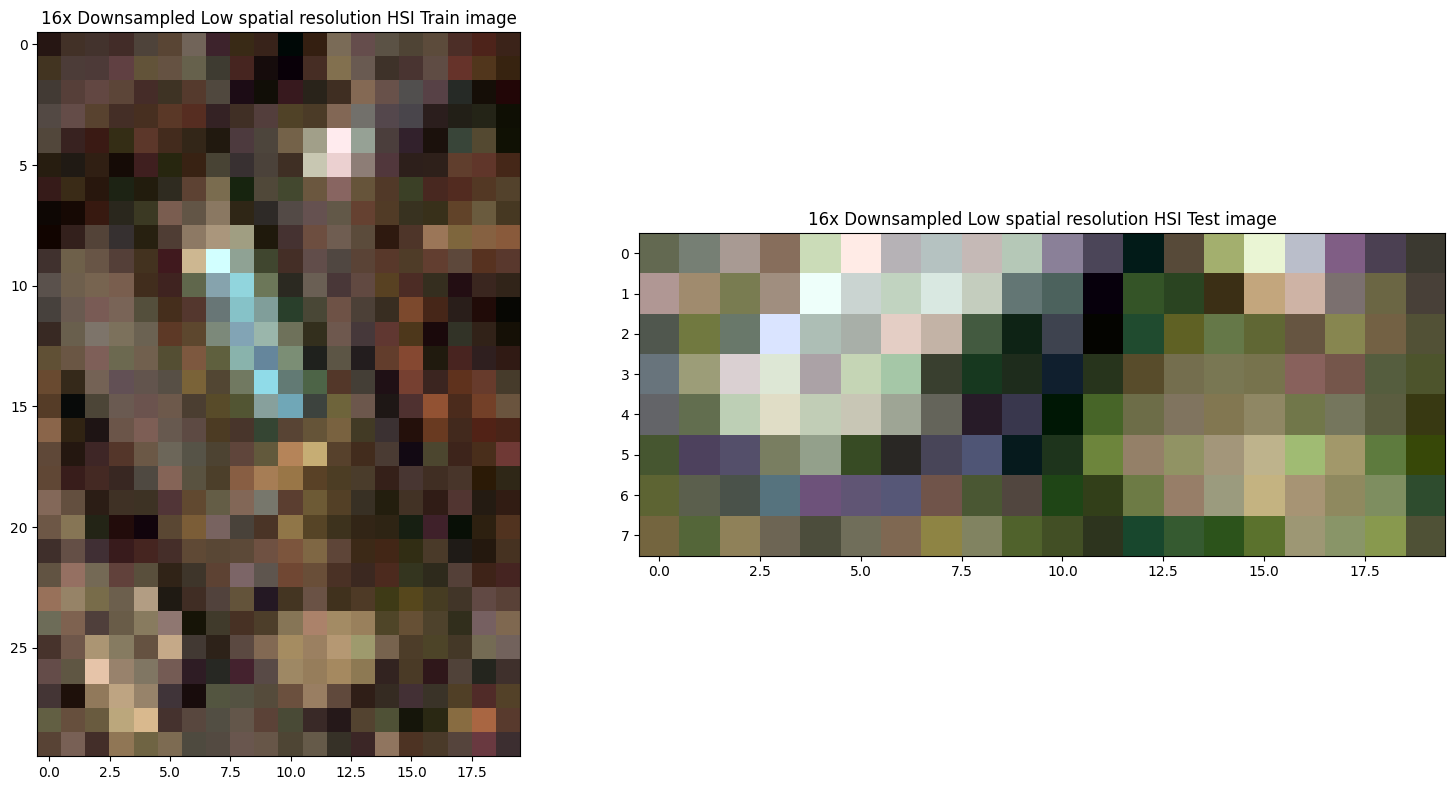

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


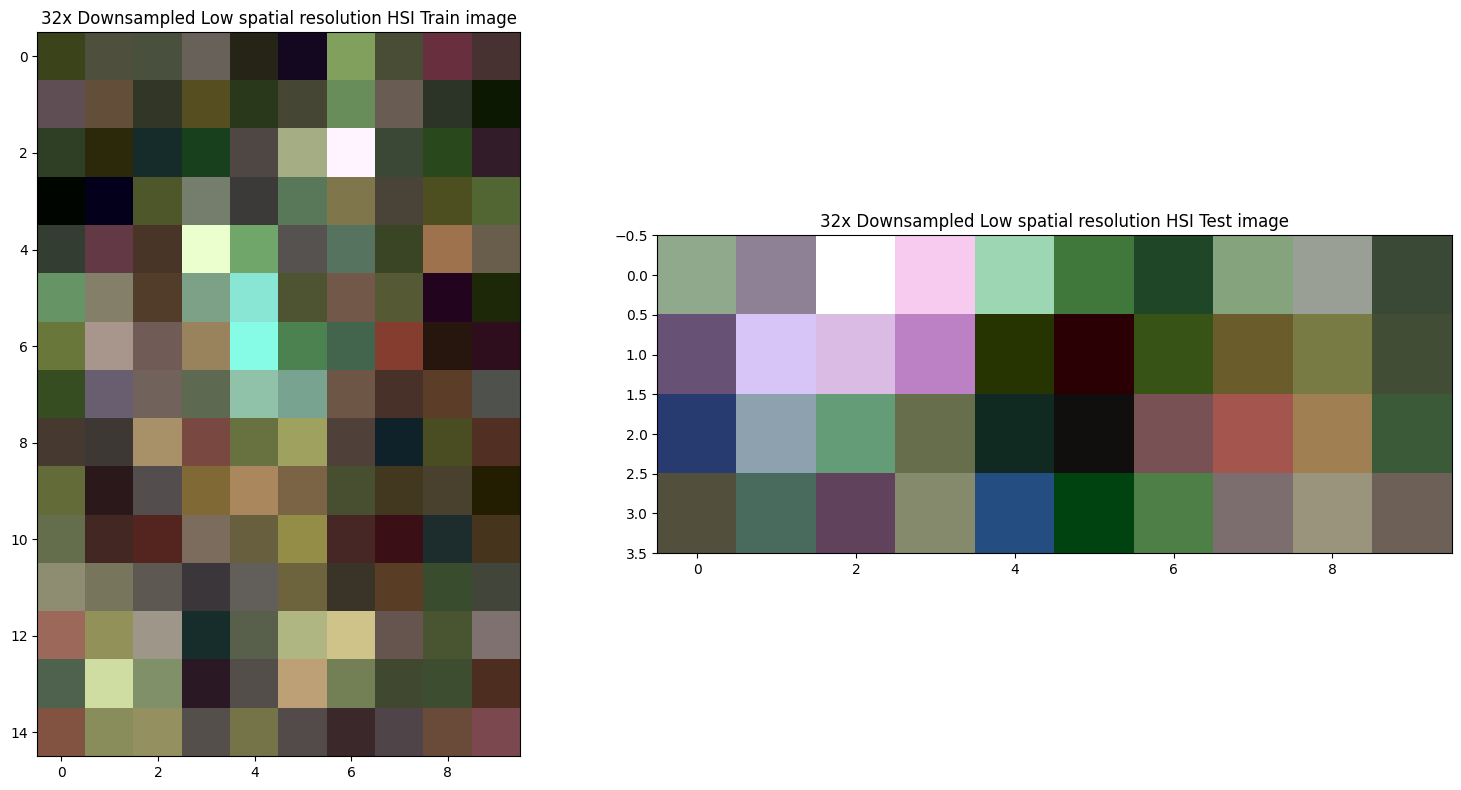

In [12]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_kol = spatial_degradation(pavia_university_image, kol_psf, 4, 35)
I_HS_4_train_kol, I_HS_4_test_kol = split_lr_hsi(I_HS_4_kol, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_kol.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_kol.shape)
visualize_hsi(I_HS_4_train_kol, I_HS_4_test_kol, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_kol = spatial_degradation(pavia_university_image, kol_psf, 8, 30)
I_HS_8_train_kol, I_HS_8_test_kol = split_lr_hsi(I_HS_8_kol, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_kol.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_kol.shape)
visualize_hsi(I_HS_8_train_kol, I_HS_8_test_kol, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_kol = spatial_degradation(pavia_university_image, kol_psf, 16, 25)
I_HS_16_train_kol, I_HS_16_test_kol = split_lr_hsi(I_HS_16_kol, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_kol.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_kol.shape)
visualize_hsi(I_HS_16_train_kol, I_HS_16_test_kol, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_kol = spatial_degradation(pavia_university_image, kol_psf, 32, 20)
I_HS_32_train_kol, I_HS_32_test_kol = split_lr_hsi(I_HS_32_kol, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_kol.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_kol.shape)
visualize_hsi(I_HS_32_train_kol, I_HS_32_test_kol, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Airy PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


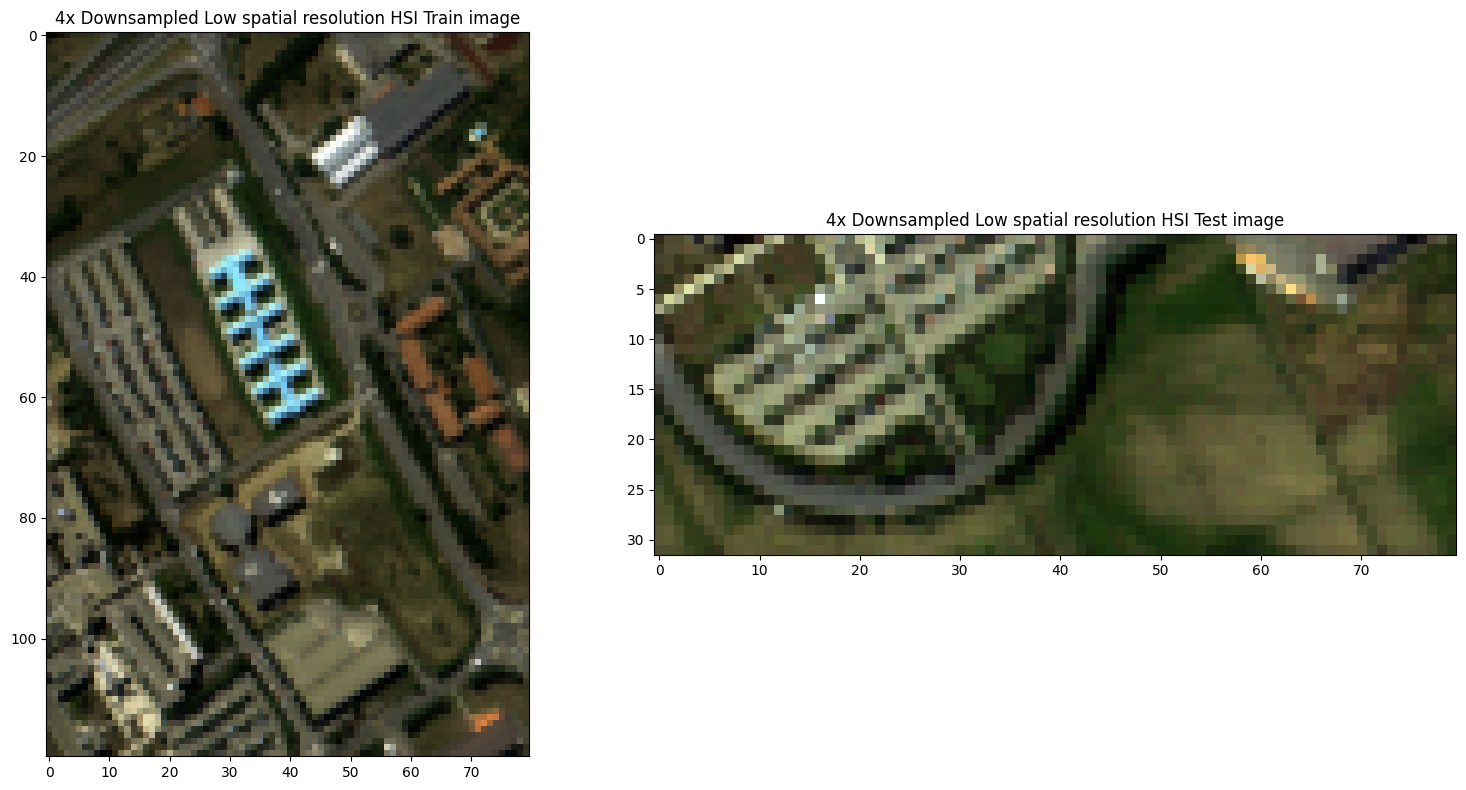

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


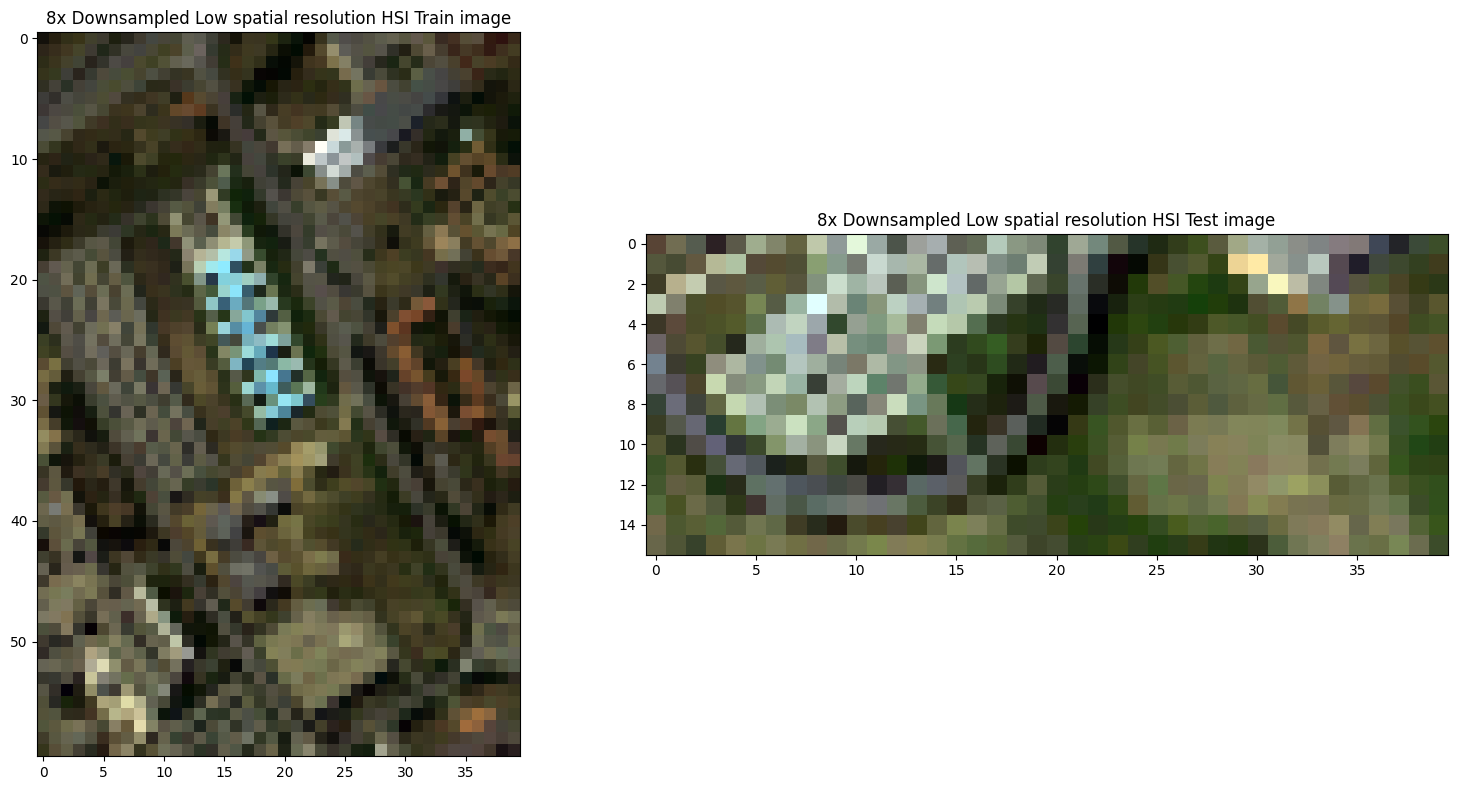

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


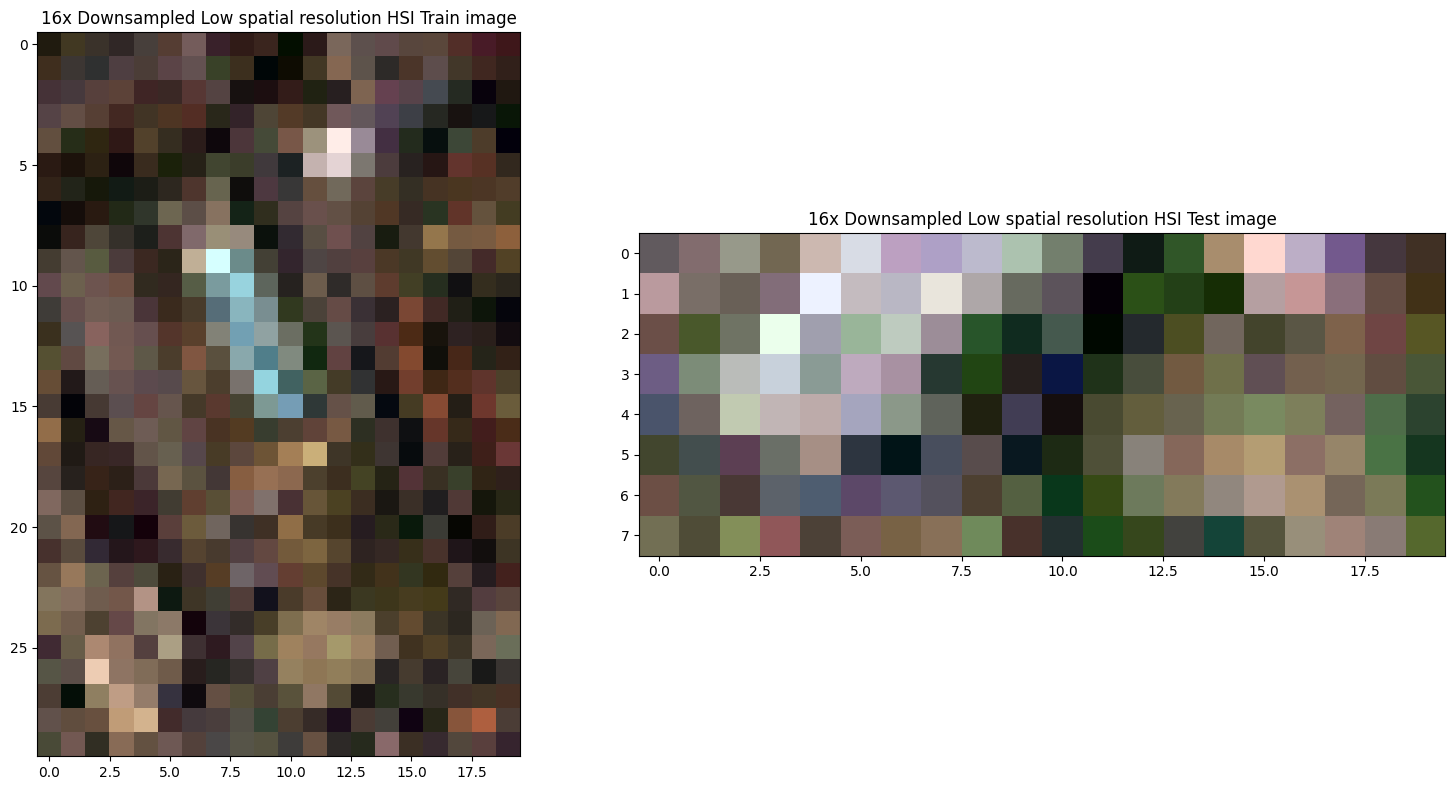

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


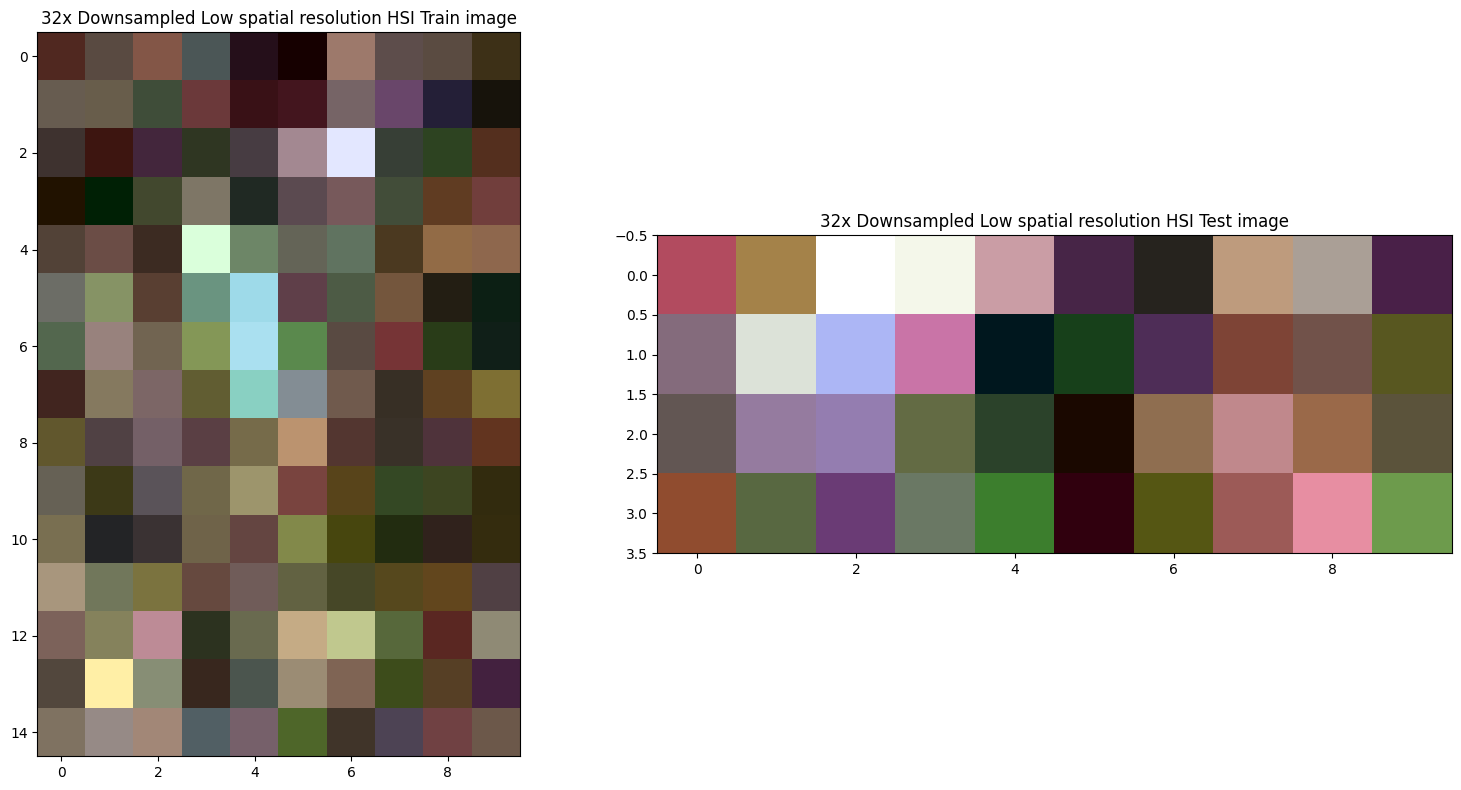

In [13]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_air = spatial_degradation(pavia_university_image, air_psf, 4, 35)
I_HS_4_train_air, I_HS_4_test_air = split_lr_hsi(I_HS_4_air, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_air.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_air.shape)
visualize_hsi(I_HS_4_train_air, I_HS_4_test_air, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_air = spatial_degradation(pavia_university_image, air_psf, 8, 30)
I_HS_8_train_air, I_HS_8_test_air = split_lr_hsi(I_HS_8_air, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_air.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_air.shape)
visualize_hsi(I_HS_8_train_air, I_HS_8_test_air, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_air = spatial_degradation(pavia_university_image, air_psf, 16, 25)
I_HS_16_train_air, I_HS_16_test_air = split_lr_hsi(I_HS_16_air, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_air.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_air.shape)
visualize_hsi(I_HS_16_train_air, I_HS_16_test_air, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_air = spatial_degradation(pavia_university_image, air_psf, 32, 20)
I_HS_32_train_air, I_HS_32_test_air = split_lr_hsi(I_HS_32_air, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_air.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_air.shape)
visualize_hsi(I_HS_32_train_air, I_HS_32_test_air, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Moffat PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


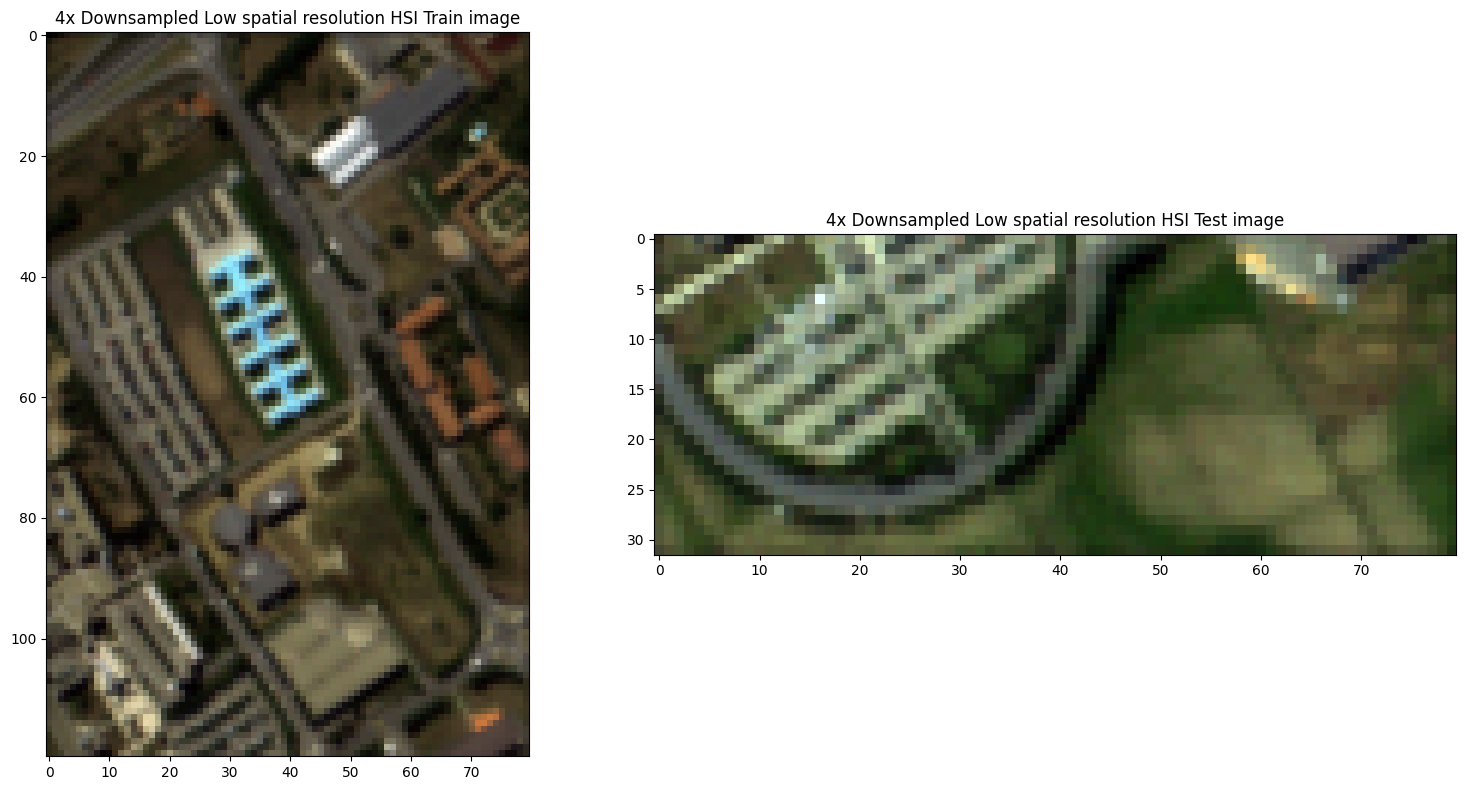

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


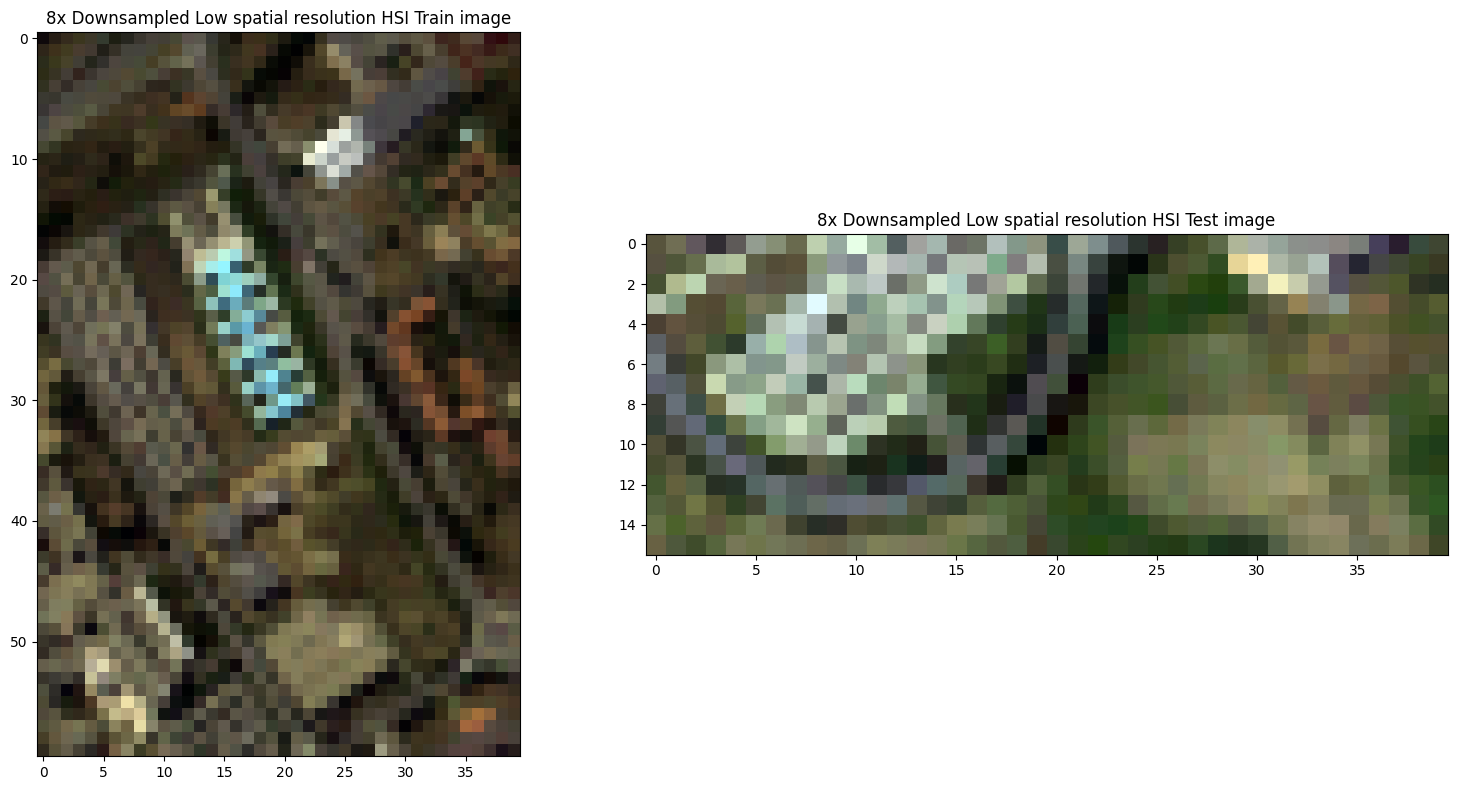

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


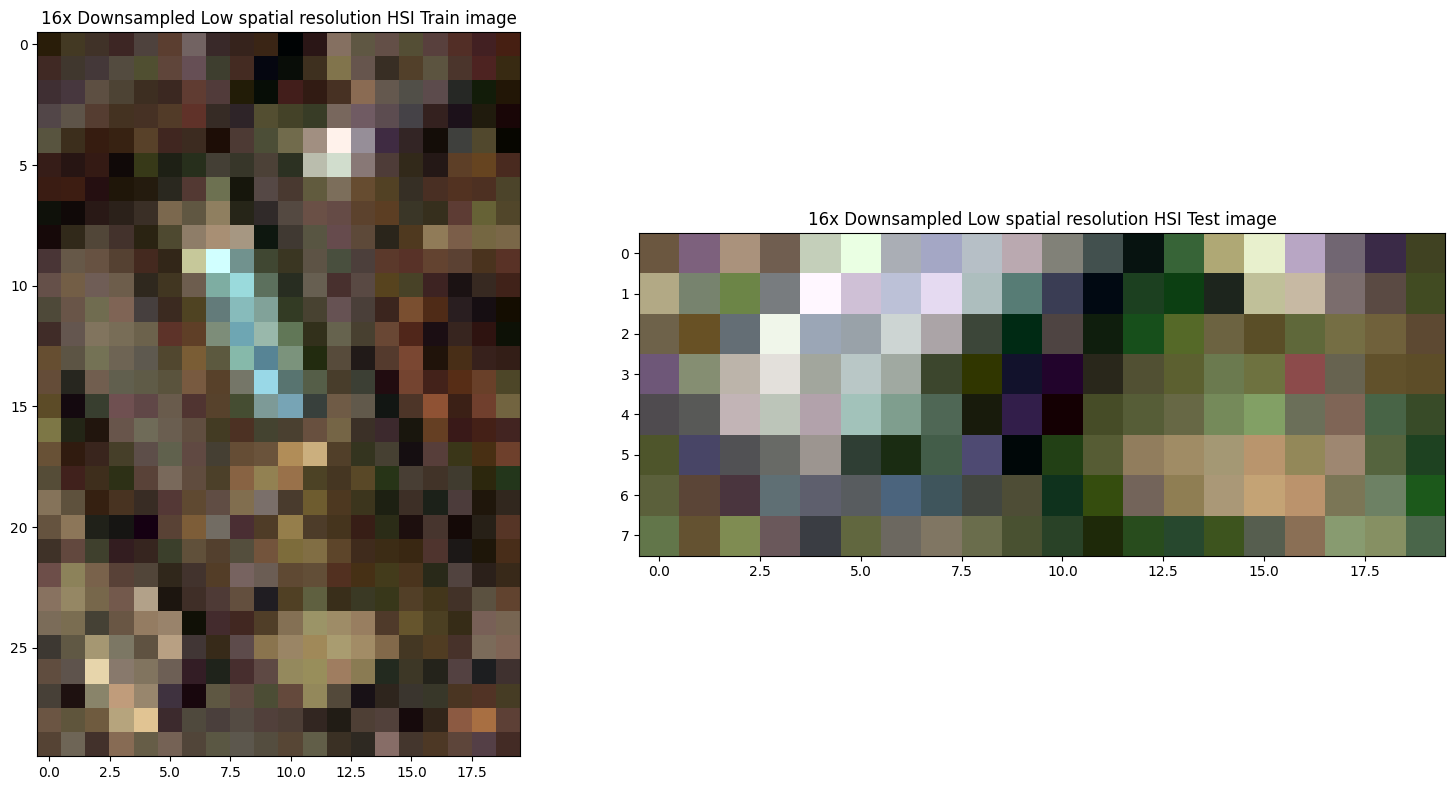

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


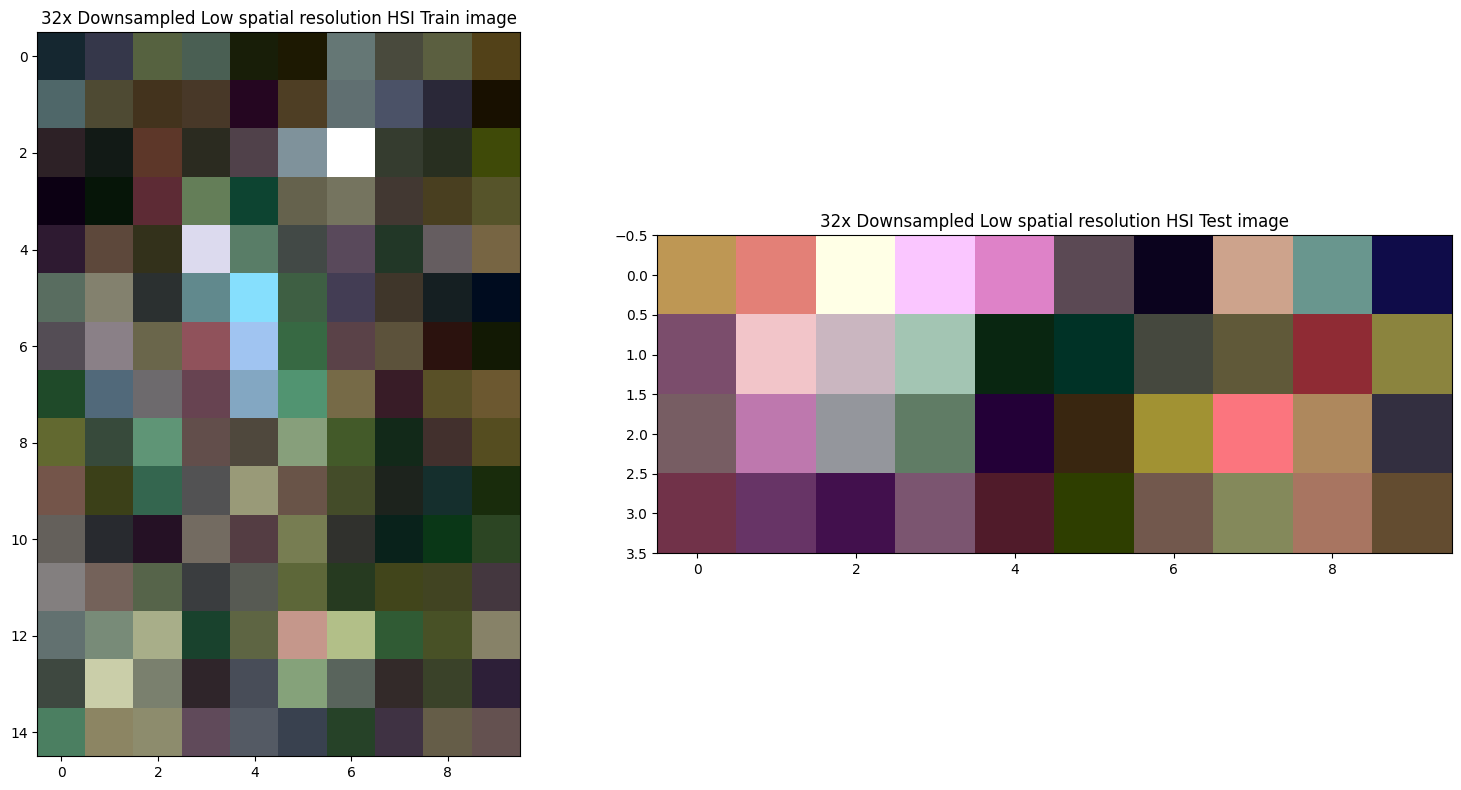

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_mof = spatial_degradation(pavia_university_image, mof_psf, 4, 35)
I_HS_4_train_mof, I_HS_4_test_mof = split_lr_hsi(I_HS_4_mof, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_mof.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_mof.shape)
visualize_hsi(I_HS_4_train_mof, I_HS_4_test_mof, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_mof = spatial_degradation(pavia_university_image, mof_psf, 8, 30)
I_HS_8_train_mof, I_HS_8_test_mof = split_lr_hsi(I_HS_8_mof, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_mof.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_mof.shape)
visualize_hsi(I_HS_8_train_mof, I_HS_8_test_mof, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_mof = spatial_degradation(pavia_university_image, mof_psf, 16, 25)
I_HS_16_train_mof, I_HS_16_test_mof = split_lr_hsi(I_HS_16_mof, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_mof.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_mof.shape)
visualize_hsi(I_HS_16_train_mof, I_HS_16_test_mof, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_mof = spatial_degradation(pavia_university_image, mof_psf, 32, 20)
I_HS_32_train_mof, I_HS_32_test_mof = split_lr_hsi(I_HS_32_mof, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_mof.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_mof.shape)
visualize_hsi(I_HS_32_train_mof, I_HS_32_test_mof, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Sinc PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


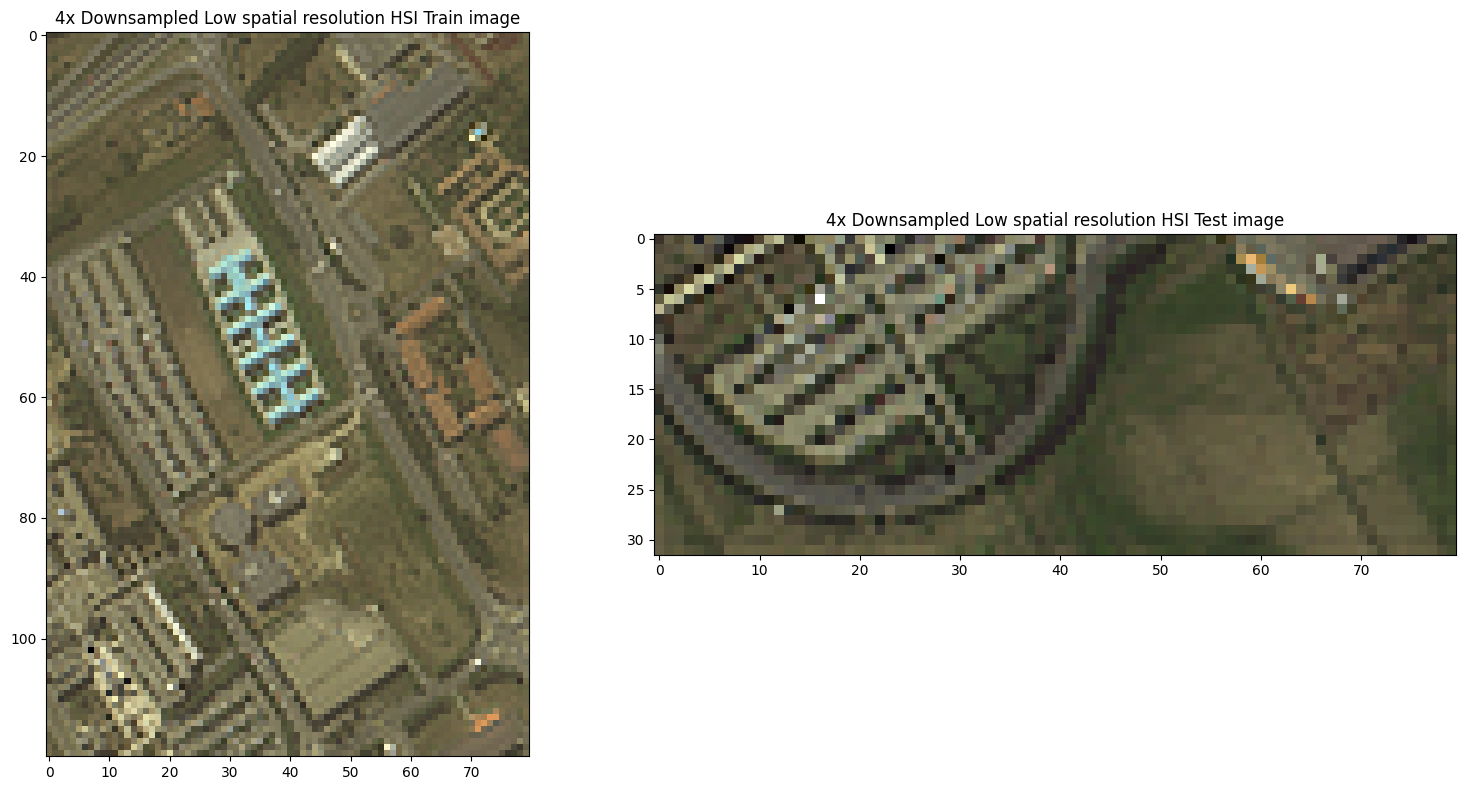

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


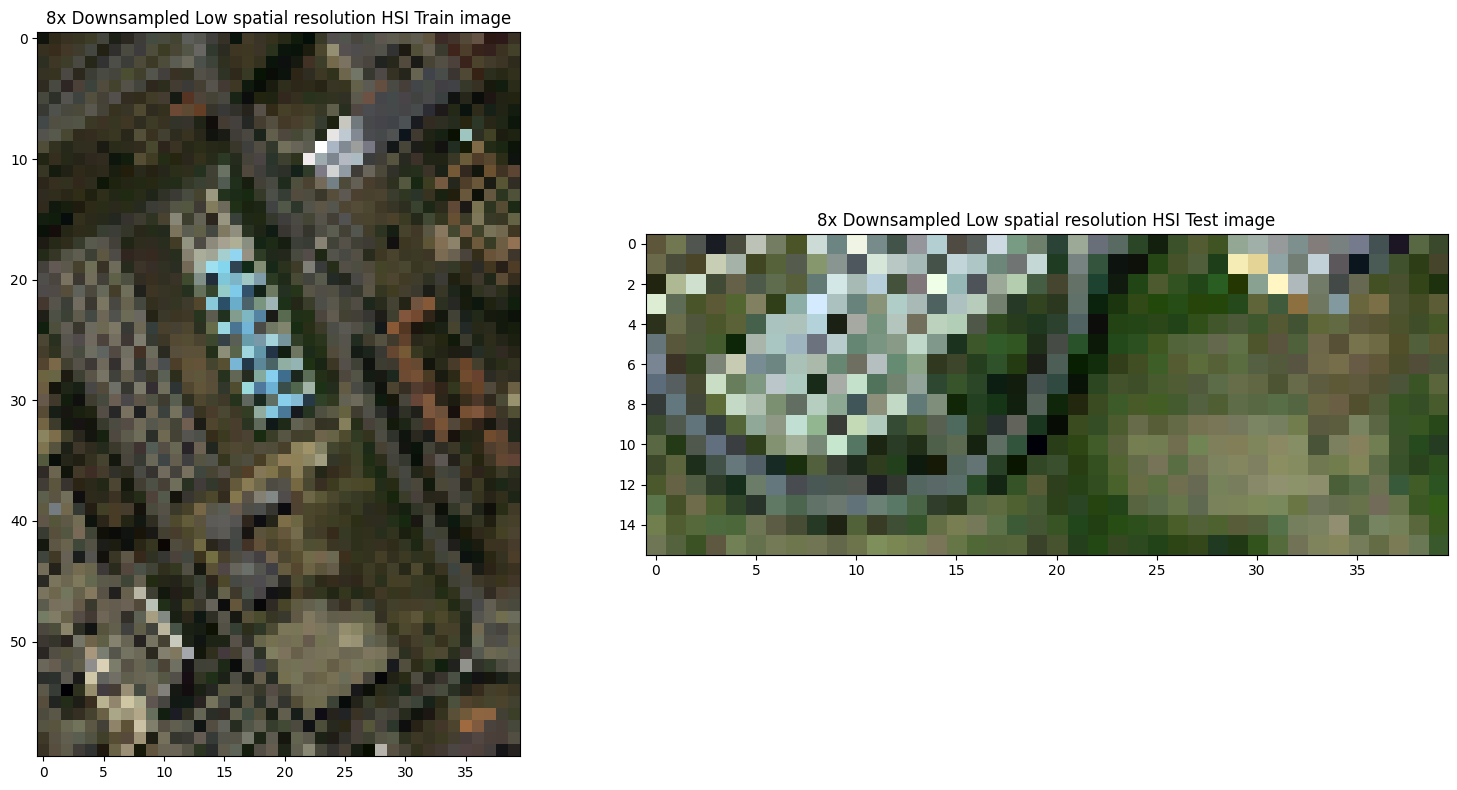

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


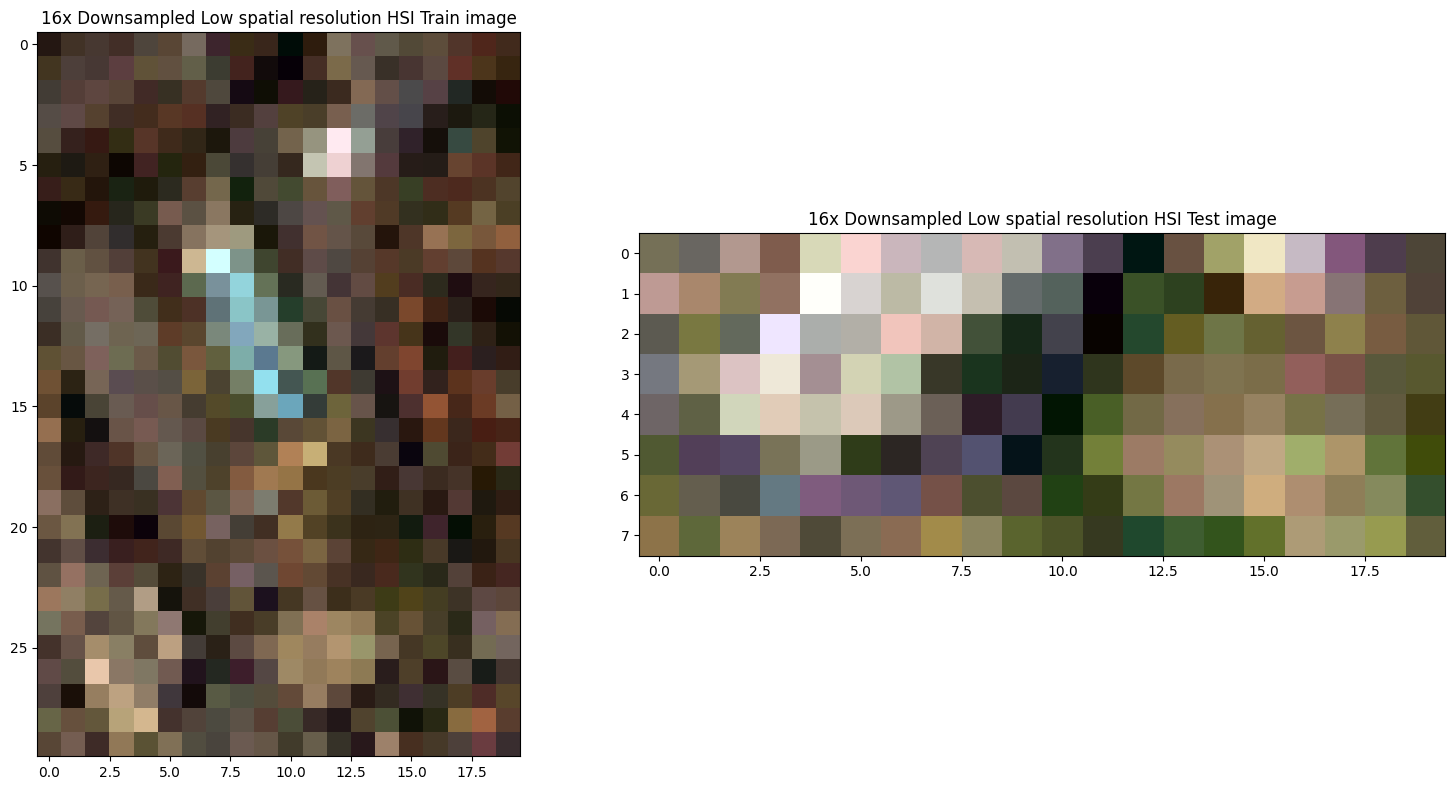

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


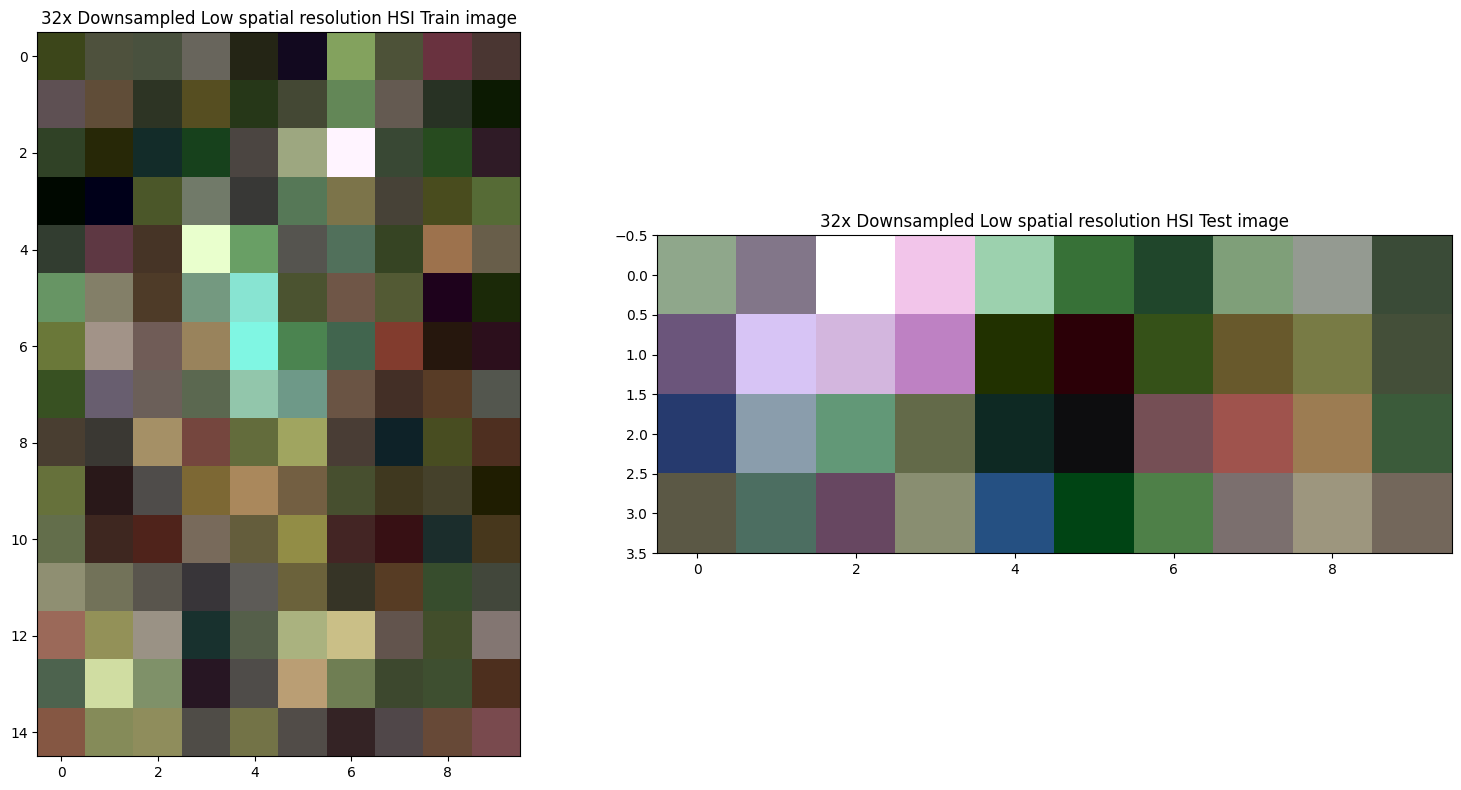

In [12]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_sinc = spatial_degradation(pavia_university_image, sinc_psf, 4, 35)
I_HS_4_train_sinc, I_HS_4_test_sinc = split_lr_hsi(I_HS_4_sinc, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_sinc.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_sinc.shape)
visualize_hsi(I_HS_4_train_sinc, I_HS_4_test_sinc, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_sinc = spatial_degradation(pavia_university_image, sinc_psf, 8, 30)
I_HS_8_train_sinc, I_HS_8_test_sinc = split_lr_hsi(I_HS_8_sinc, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_sinc.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_sinc.shape)
visualize_hsi(I_HS_8_train_sinc, I_HS_8_test_sinc, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_sinc = spatial_degradation(pavia_university_image, sinc_psf, 16, 25)
I_HS_16_train_sinc, I_HS_16_test_sinc = split_lr_hsi(I_HS_16_sinc, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_sinc.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_sinc.shape)
visualize_hsi(I_HS_16_train_sinc, I_HS_16_test_sinc, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_sinc = spatial_degradation(pavia_university_image, sinc_psf, 32, 20)
I_HS_32_train_sinc, I_HS_32_test_sinc = split_lr_hsi(I_HS_32_sinc, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_sinc.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_sinc.shape)
visualize_hsi(I_HS_32_train_sinc, I_HS_32_test_sinc, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Lorentzian Squared PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


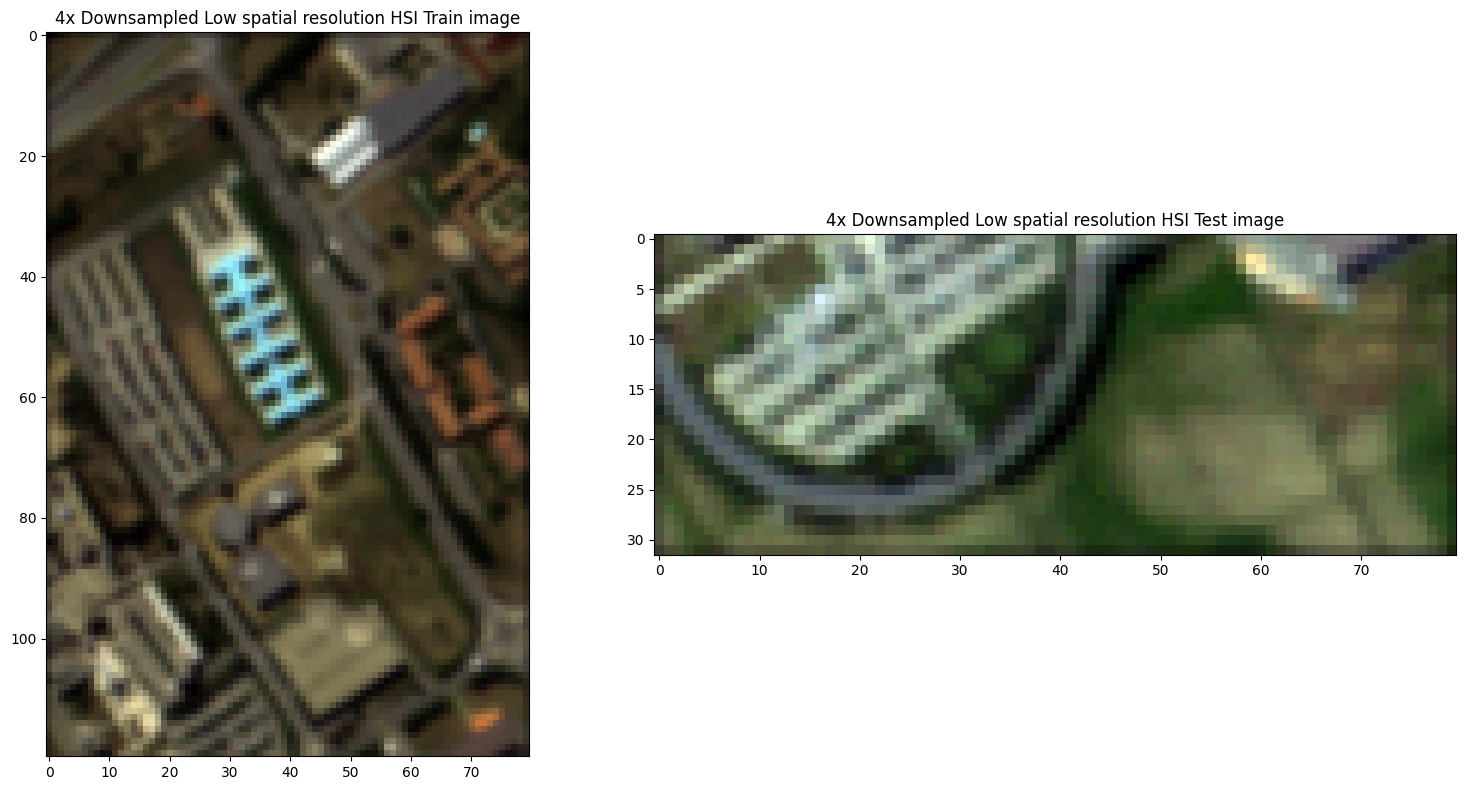

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


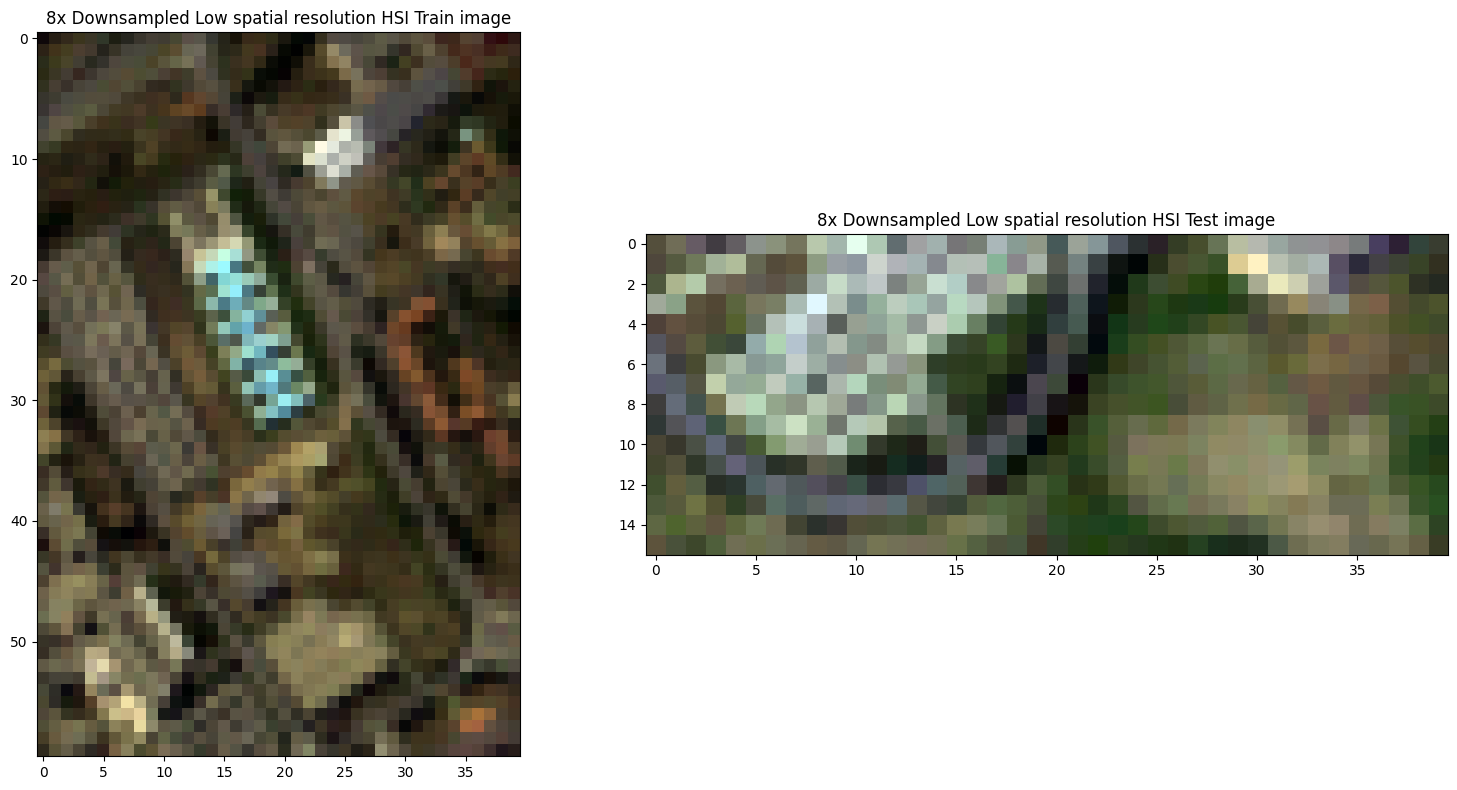

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


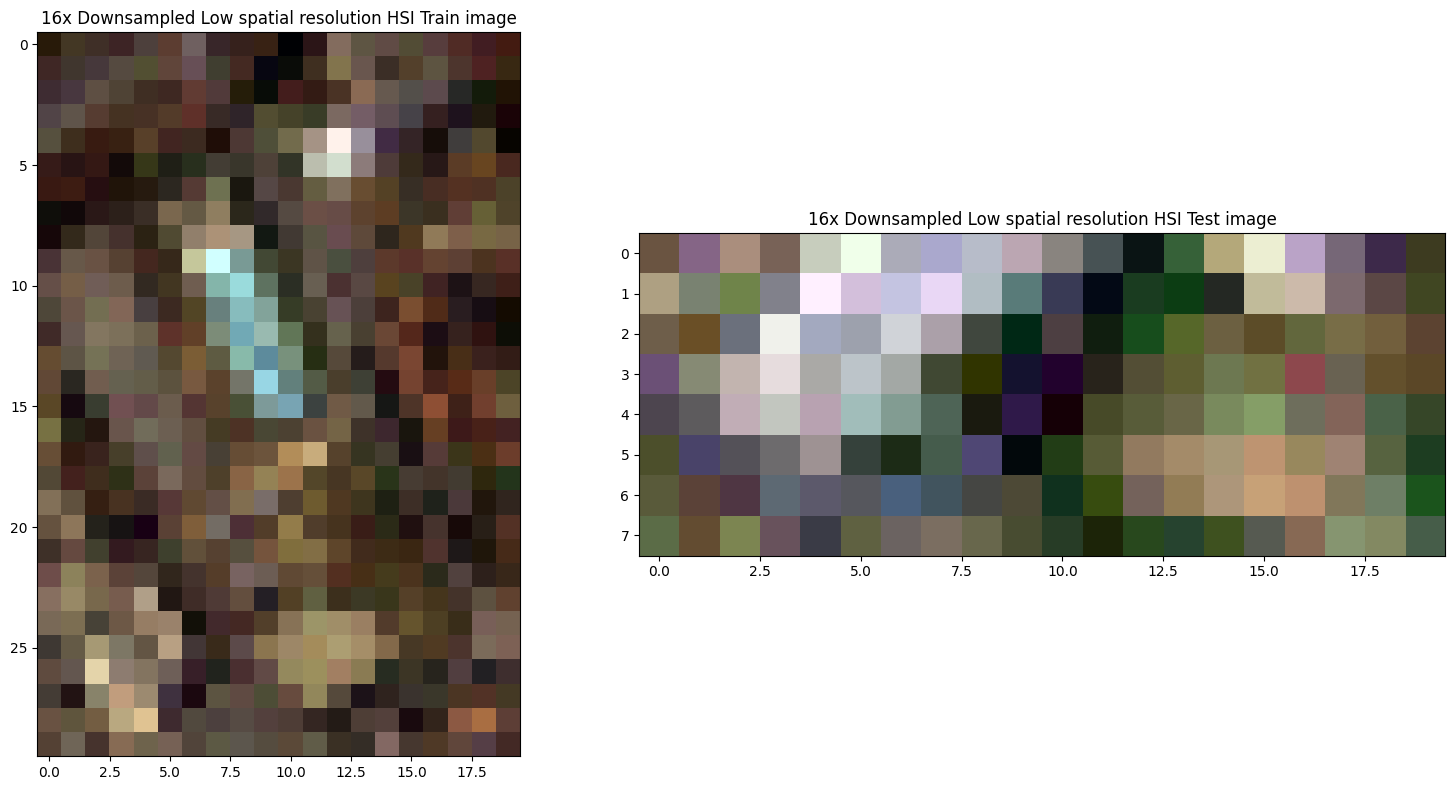

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


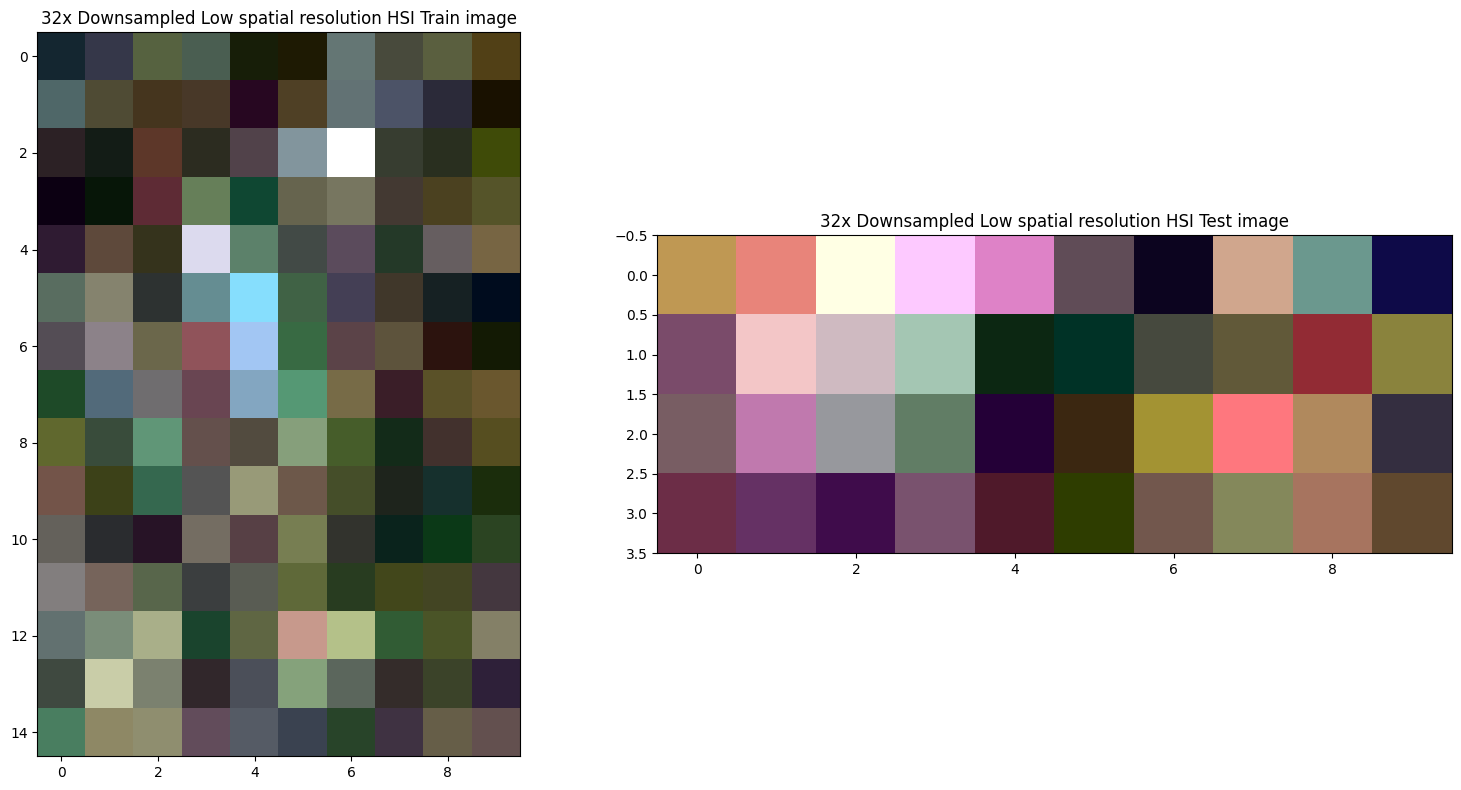

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 4, 35)
I_HS_4_train_lor_sq, I_HS_4_test_lor_sq = split_lr_hsi(I_HS_4_lor_sq, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_lor_sq.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_lor_sq.shape)
visualize_hsi(I_HS_4_train_lor_sq, I_HS_4_test_lor_sq, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 8, 30)
I_HS_8_train_lor_sq, I_HS_8_test_lor_sq = split_lr_hsi(I_HS_8_lor_sq, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_lor_sq.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_lor_sq.shape)
visualize_hsi(I_HS_8_train_lor_sq, I_HS_8_test_lor_sq, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 16, 25)
I_HS_16_train_lor_sq, I_HS_16_test_lor_sq = split_lr_hsi(I_HS_16_lor_sq, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_lor_sq.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_lor_sq.shape)
visualize_hsi(I_HS_16_train_lor_sq, I_HS_16_test_lor_sq, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_lor_sq = spatial_degradation(pavia_university_image, lor_sq_psf, 32, 20)
I_HS_32_train_lor_sq, I_HS_32_test_lor_sq = split_lr_hsi(I_HS_32_lor_sq, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_lor_sq.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_lor_sq.shape)
visualize_hsi(I_HS_32_train_lor_sq, I_HS_32_test_lor_sq, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Hermite PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


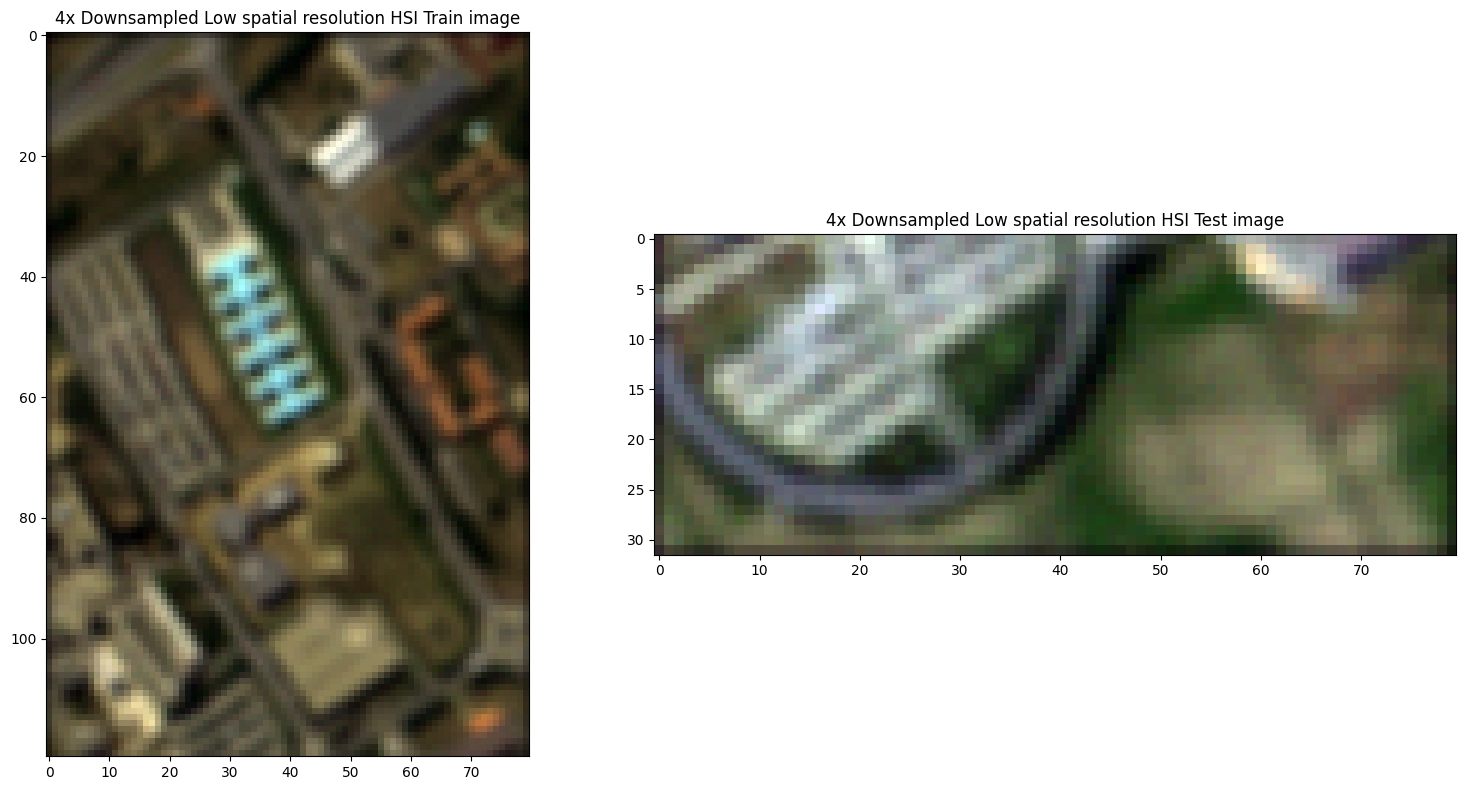

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


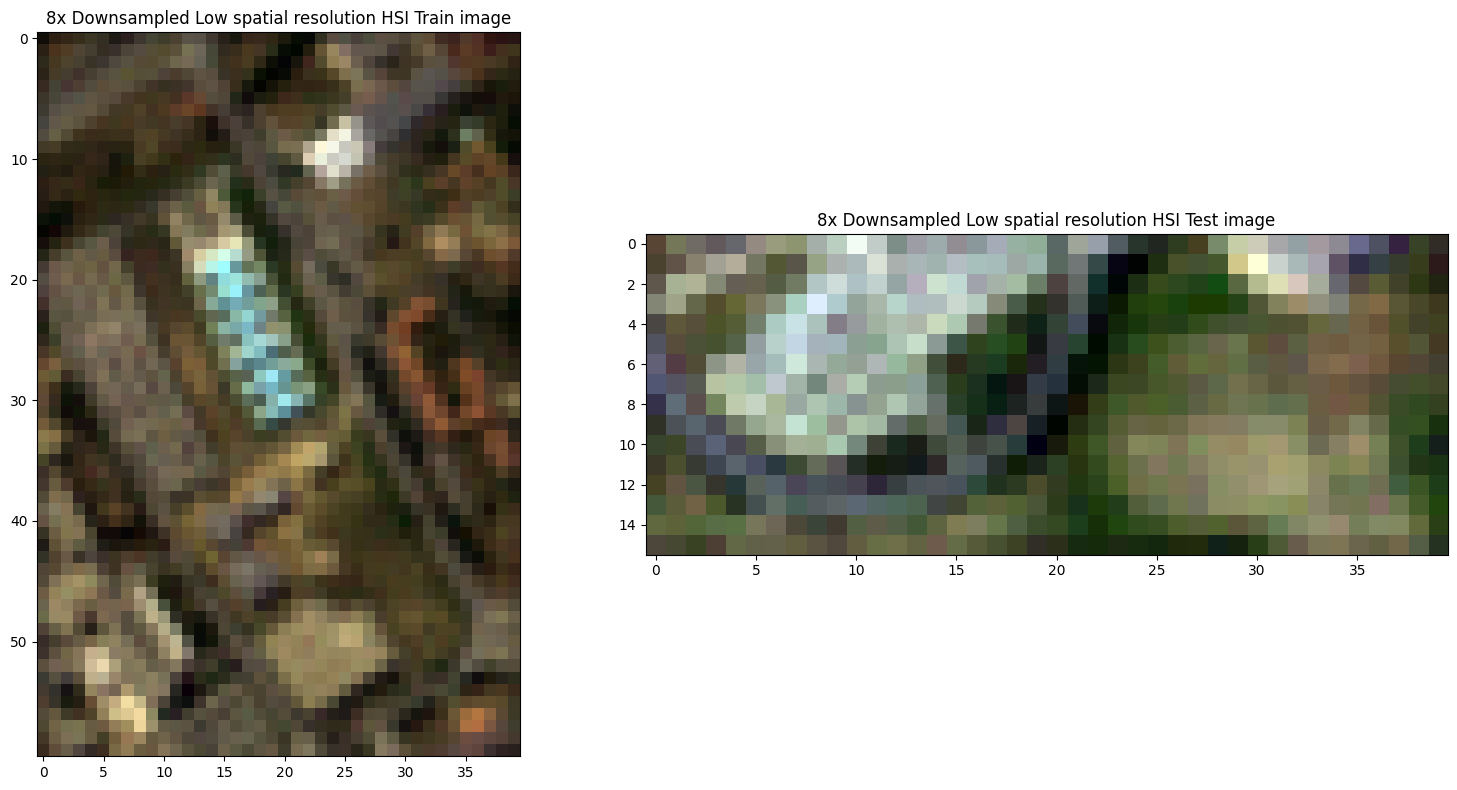

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


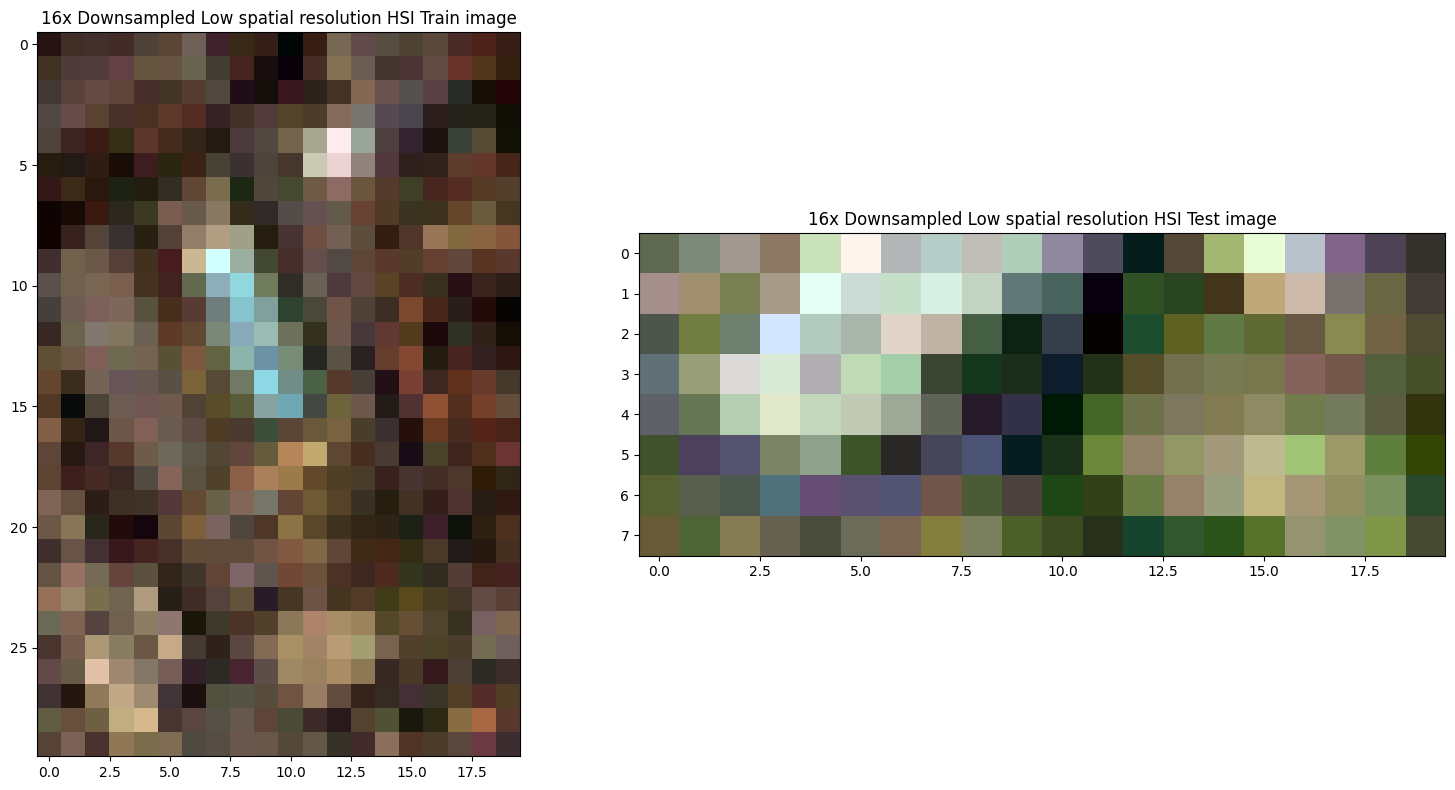

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


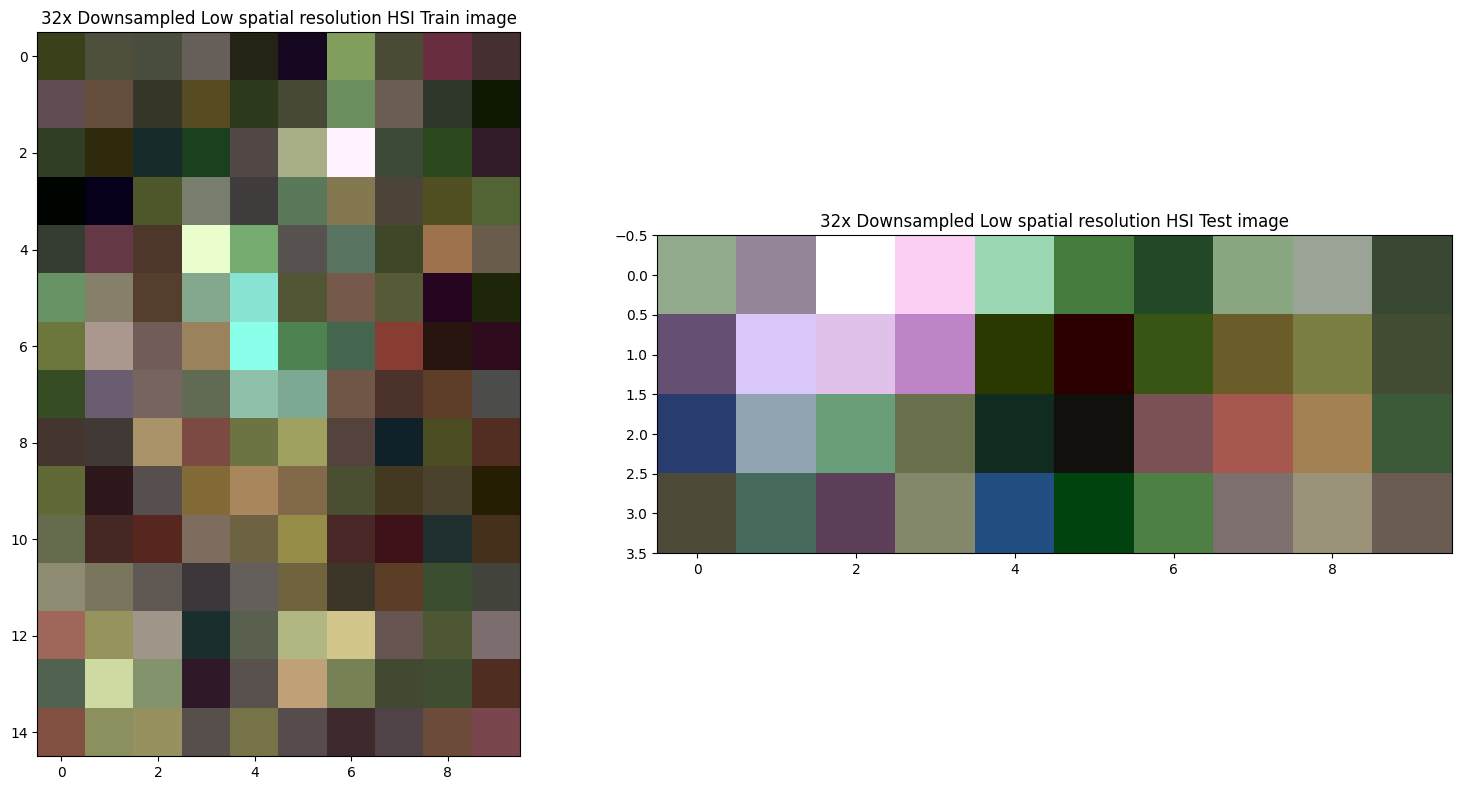

In [12]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_her = spatial_degradation(pavia_university_image, her_psf, 4, 35)
I_HS_4_train_her, I_HS_4_test_her = split_lr_hsi(I_HS_4_her, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_her.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_her.shape)
visualize_hsi(I_HS_4_train_her, I_HS_4_test_her, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_her = spatial_degradation(pavia_university_image, her_psf, 8, 30)
I_HS_8_train_her, I_HS_8_test_her = split_lr_hsi(I_HS_8_her, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_her.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_her.shape)
visualize_hsi(I_HS_8_train_her, I_HS_8_test_her, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_her = spatial_degradation(pavia_university_image, her_psf, 16, 25)
I_HS_16_train_her, I_HS_16_test_her = split_lr_hsi(I_HS_16_her, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_her.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_her.shape)
visualize_hsi(I_HS_16_train_her, I_HS_16_test_her, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_her = spatial_degradation(pavia_university_image, her_psf, 32, 20)
I_HS_32_train_her, I_HS_32_test_her = split_lr_hsi(I_HS_32_her, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_her.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_her.shape)
visualize_hsi(I_HS_32_train_her, I_HS_32_test_her, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Parabolic PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


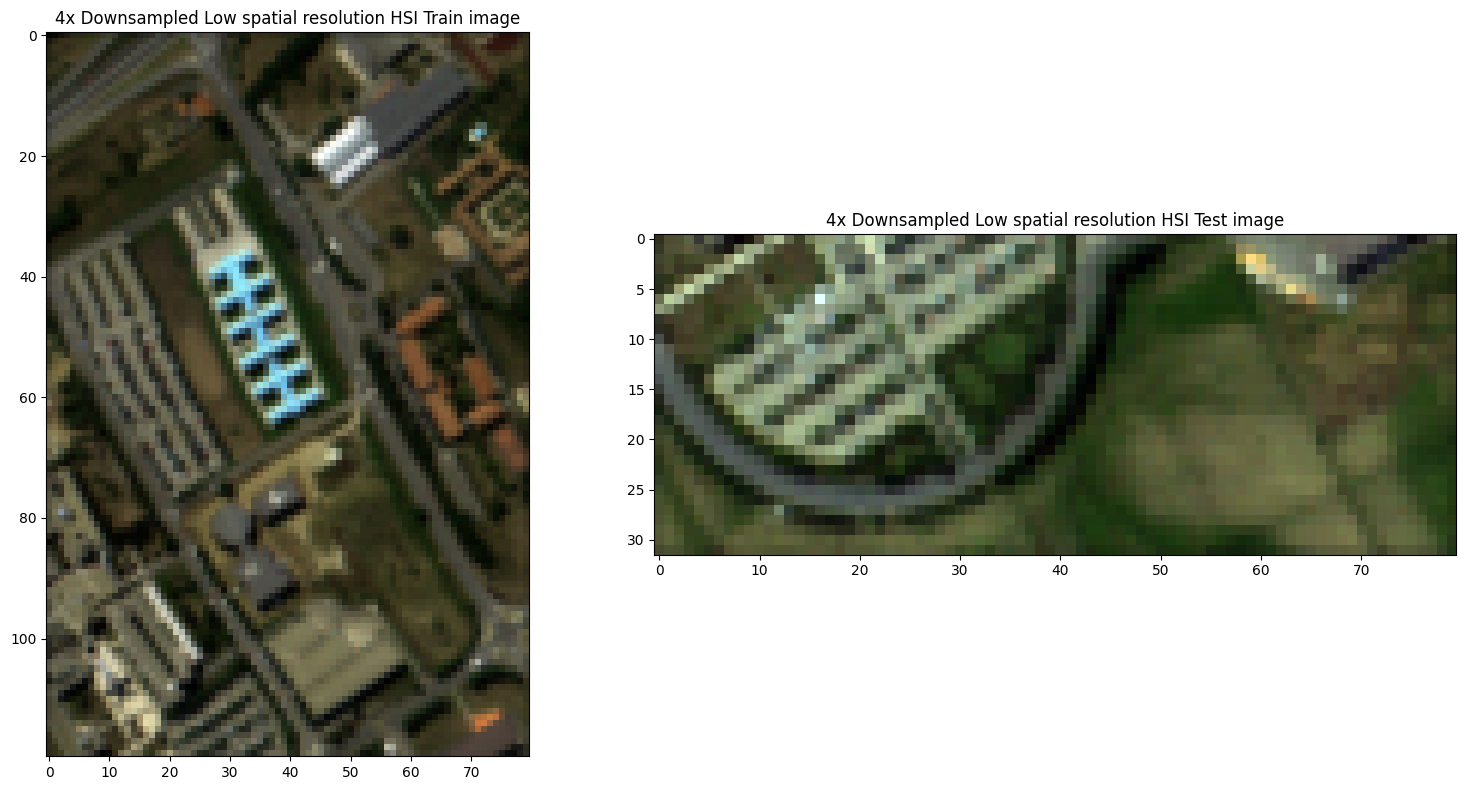

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


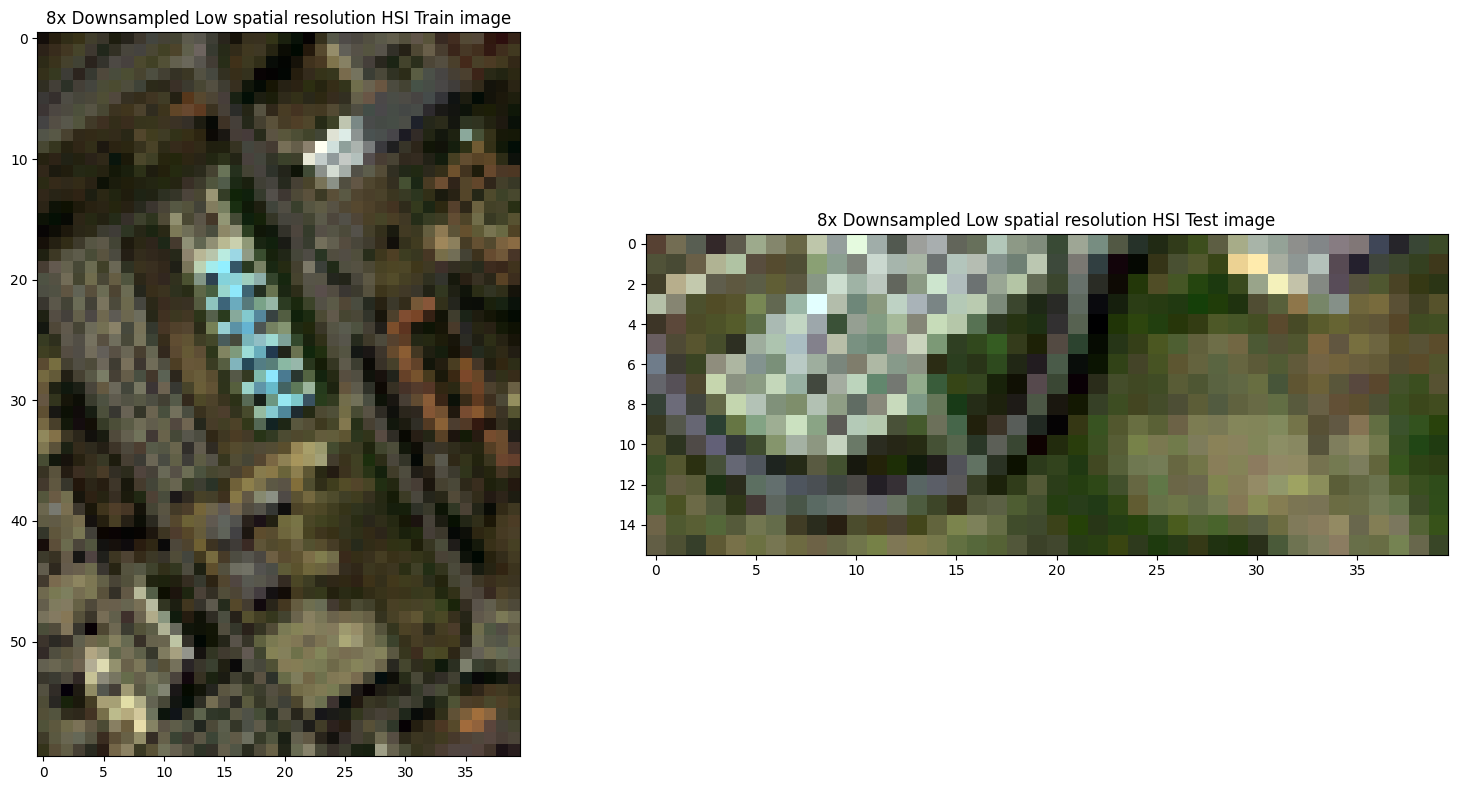

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


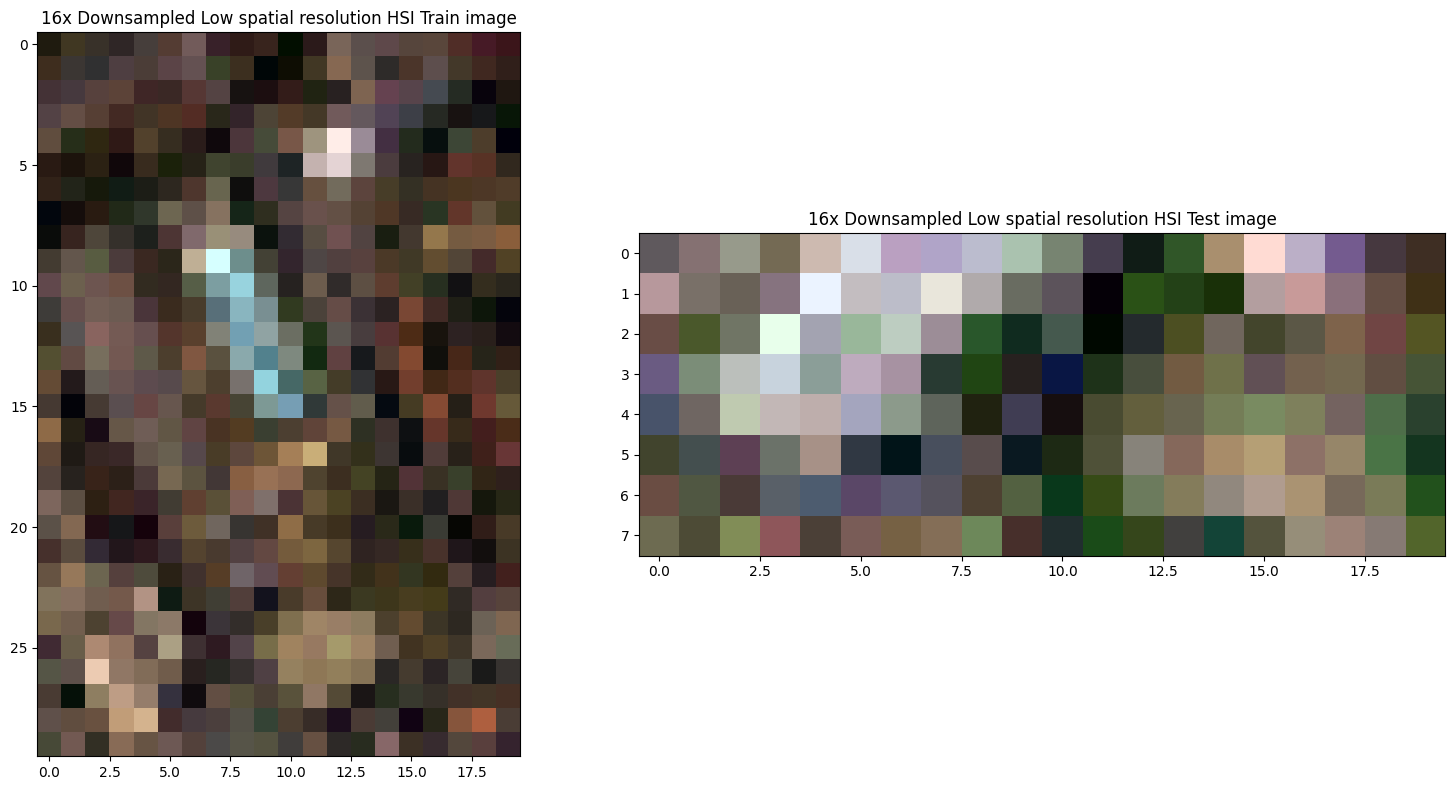

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


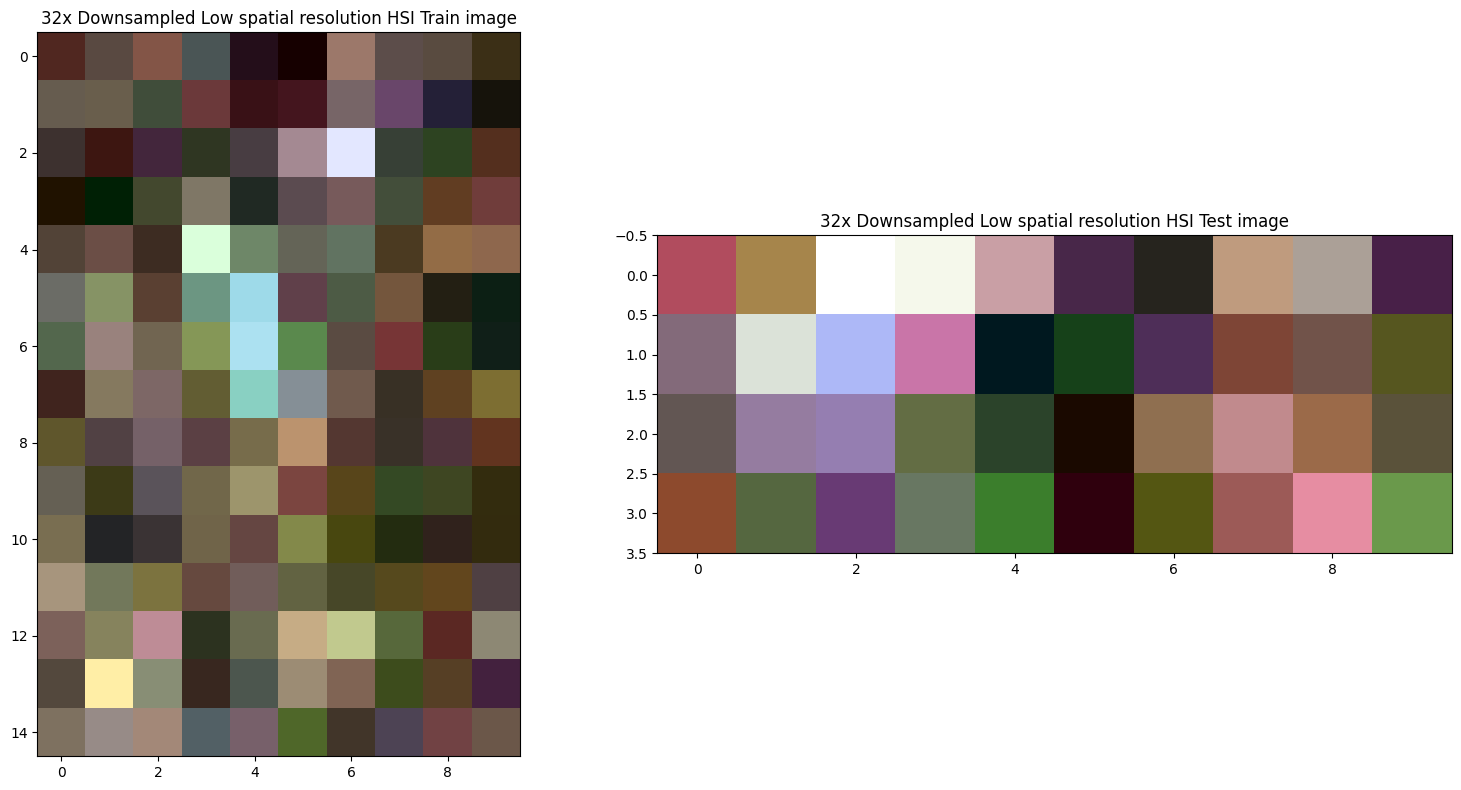

In [13]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_par = spatial_degradation(pavia_university_image, par_psf, 4, 35)
I_HS_4_train_par, I_HS_4_test_par = split_lr_hsi(I_HS_4_par, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_par.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_par.shape)
visualize_hsi(I_HS_4_train_par, I_HS_4_test_par, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_par = spatial_degradation(pavia_university_image, par_psf, 8, 30)
I_HS_8_train_par, I_HS_8_test_par = split_lr_hsi(I_HS_8_par, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_par.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_par.shape)
visualize_hsi(I_HS_8_train_par, I_HS_8_test_par, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_par = spatial_degradation(pavia_university_image, par_psf, 16, 25)
I_HS_16_train_par, I_HS_16_test_par = split_lr_hsi(I_HS_16_par, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_par.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_par.shape)
visualize_hsi(I_HS_16_train_par, I_HS_16_test_par, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_par = spatial_degradation(pavia_university_image, par_psf, 32, 20)
I_HS_32_train_par, I_HS_32_test_par = split_lr_hsi(I_HS_32_par, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_par.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_par.shape)
visualize_hsi(I_HS_32_train_par, I_HS_32_test_par, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Gabor PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


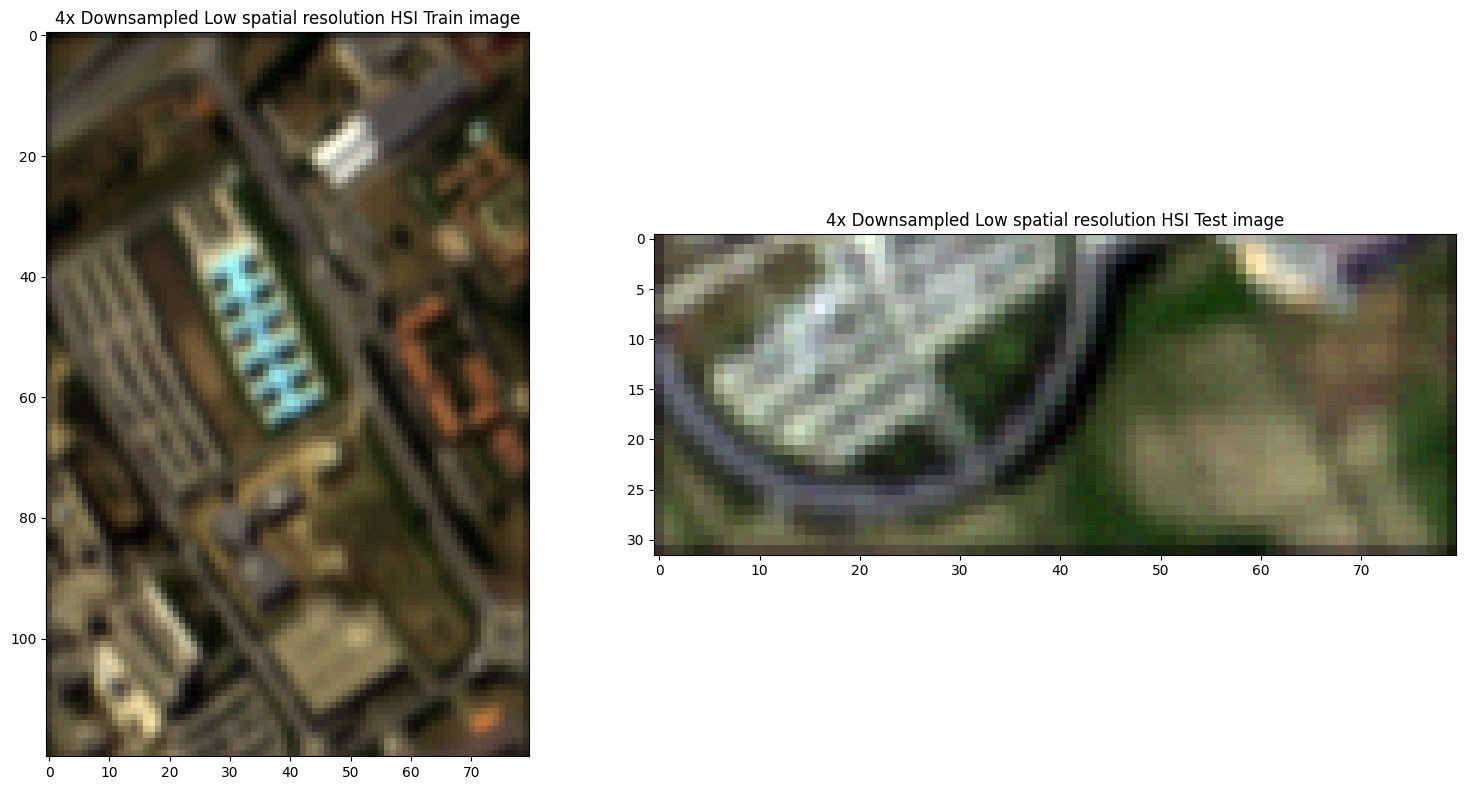

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


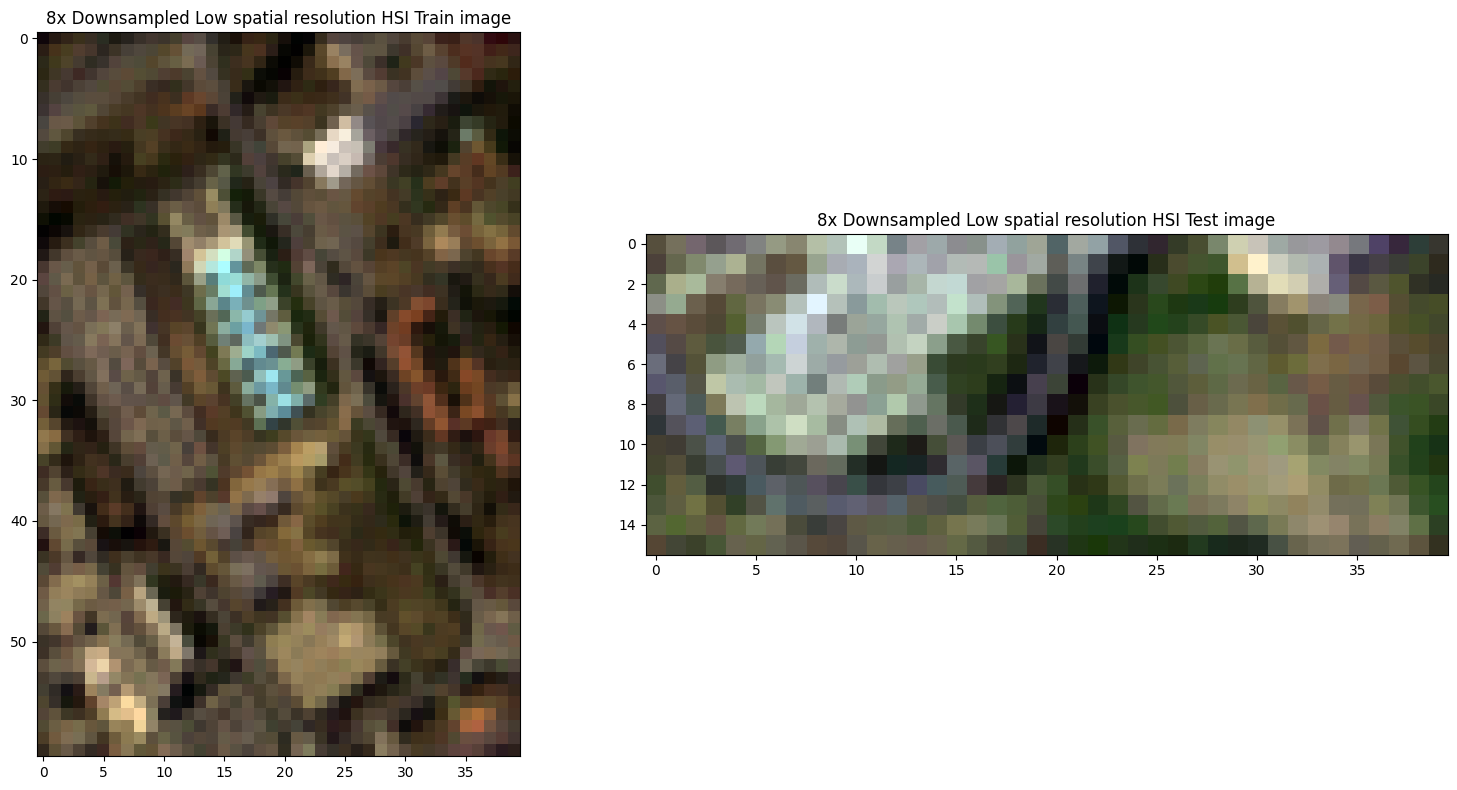

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


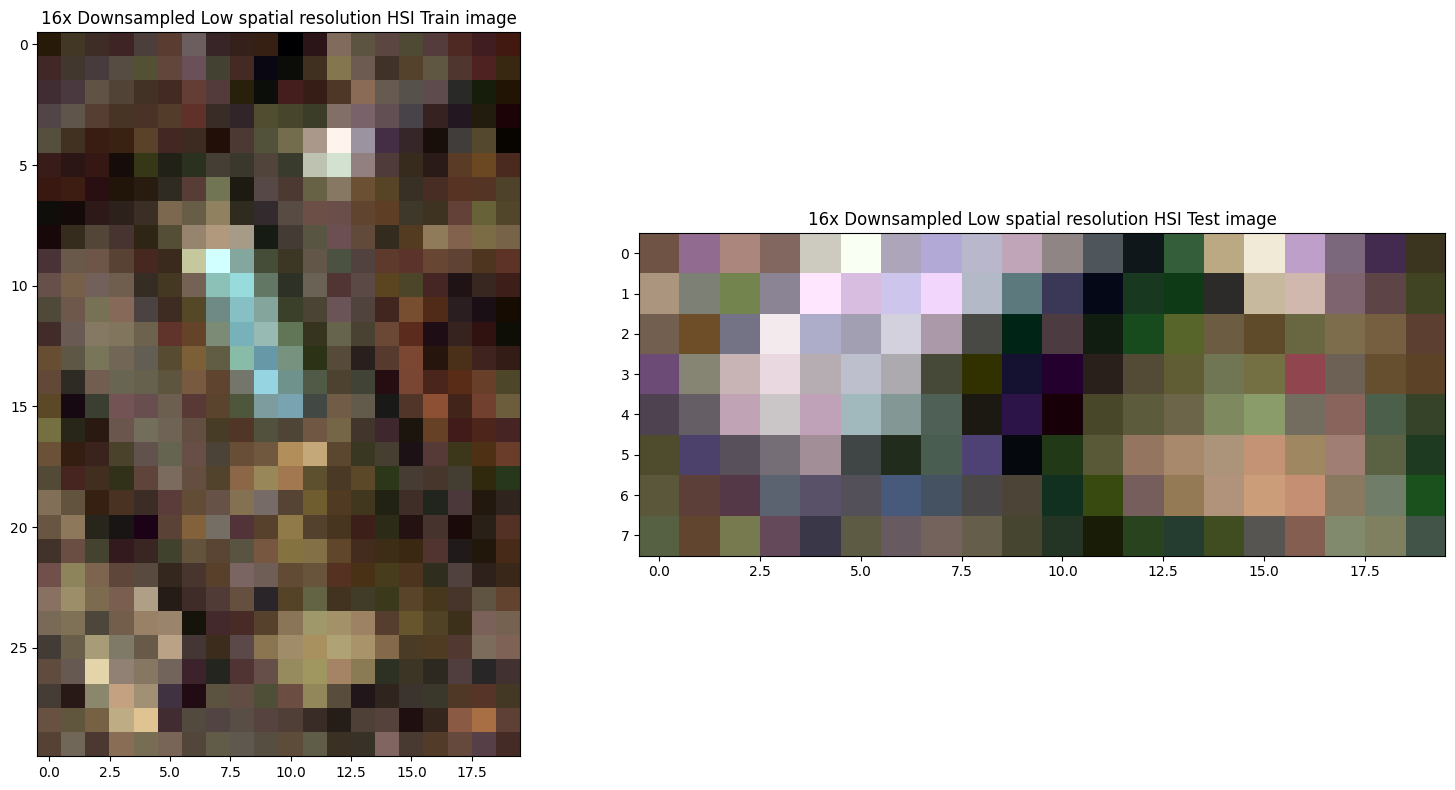

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


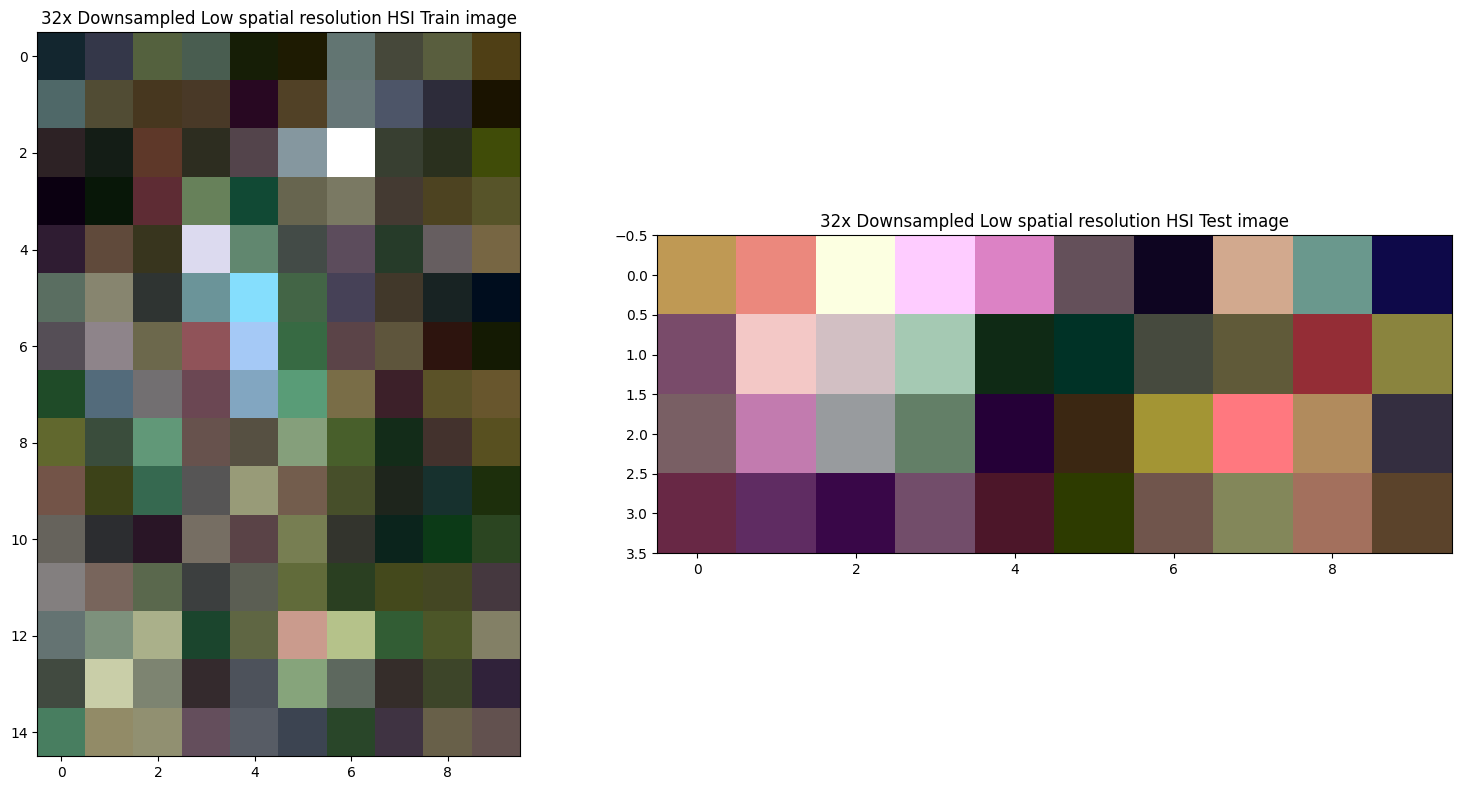

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gab = spatial_degradation(pavia_university_image, gab_psf, 4, 35)
I_HS_4_train_gab, I_HS_4_test_gab = split_lr_hsi(I_HS_4_gab, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_gab.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_gab.shape)
visualize_hsi(I_HS_4_train_gab, I_HS_4_test_gab, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gab = spatial_degradation(pavia_university_image, gab_psf, 8, 30)
I_HS_8_train_gab, I_HS_8_test_gab = split_lr_hsi(I_HS_8_gab, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_gab.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_gab.shape)
visualize_hsi(I_HS_8_train_gab, I_HS_8_test_gab, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gab = spatial_degradation(pavia_university_image, gab_psf, 16, 25)
I_HS_16_train_gab, I_HS_16_test_gab = split_lr_hsi(I_HS_16_gab, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_gab.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_gab.shape)
visualize_hsi(I_HS_16_train_gab, I_HS_16_test_gab, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gab = spatial_degradation(pavia_university_image, gab_psf, 32, 20)
I_HS_32_train_gab, I_HS_32_test_gab = split_lr_hsi(I_HS_32_gab, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_gab.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_gab.shape)
visualize_hsi(I_HS_32_train_gab, I_HS_32_test_gab, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Setting up and visualizing the HSI images with Delta PSF

HSI train shape with 4x Downsample:  (120, 80, 103)
HSI test shape with 4x Downsample:  (32, 80, 103)


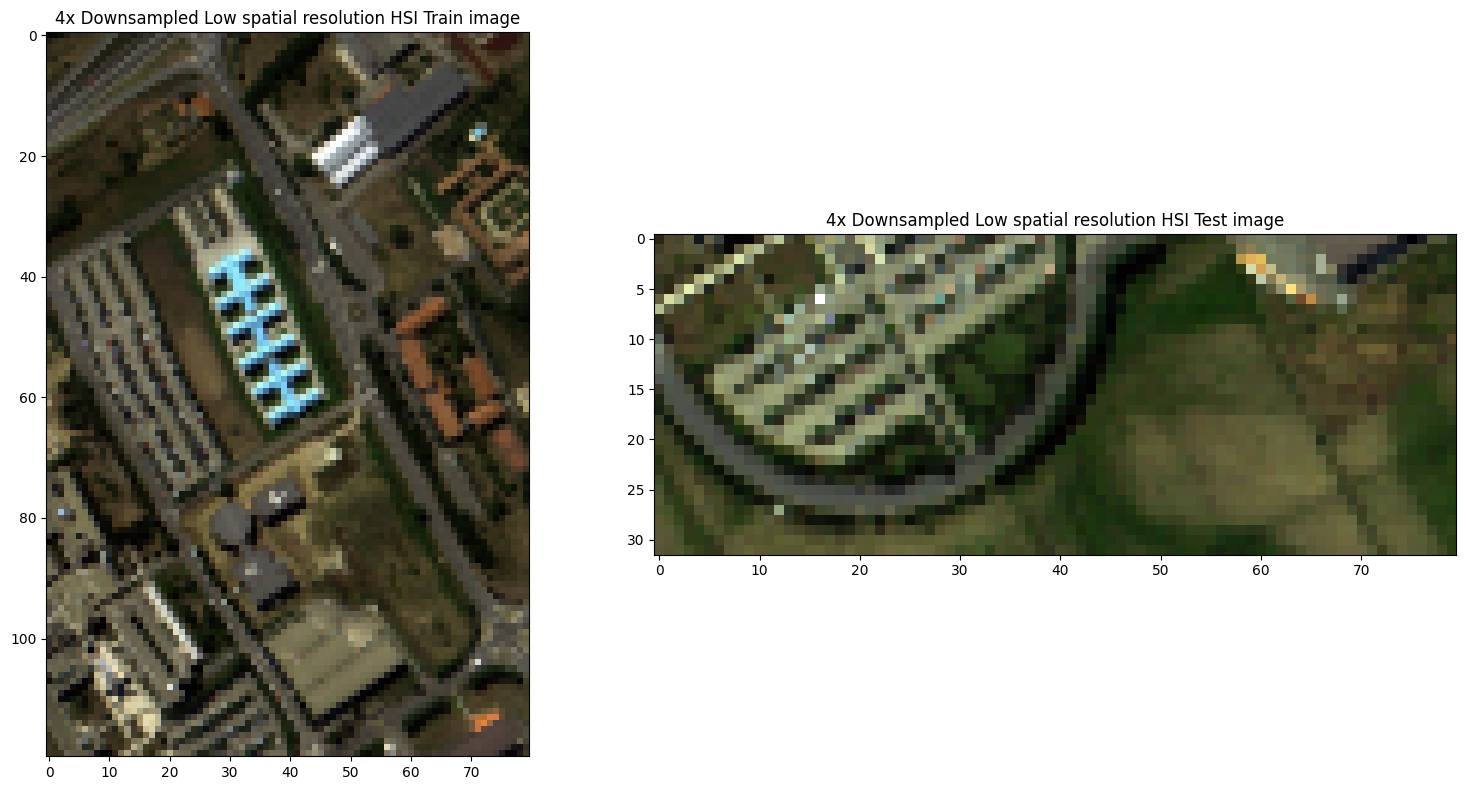

HSI train shape with 8x Downsample:  (60, 40, 103)
HSI test shape with 8x Downsample:  (16, 40, 103)


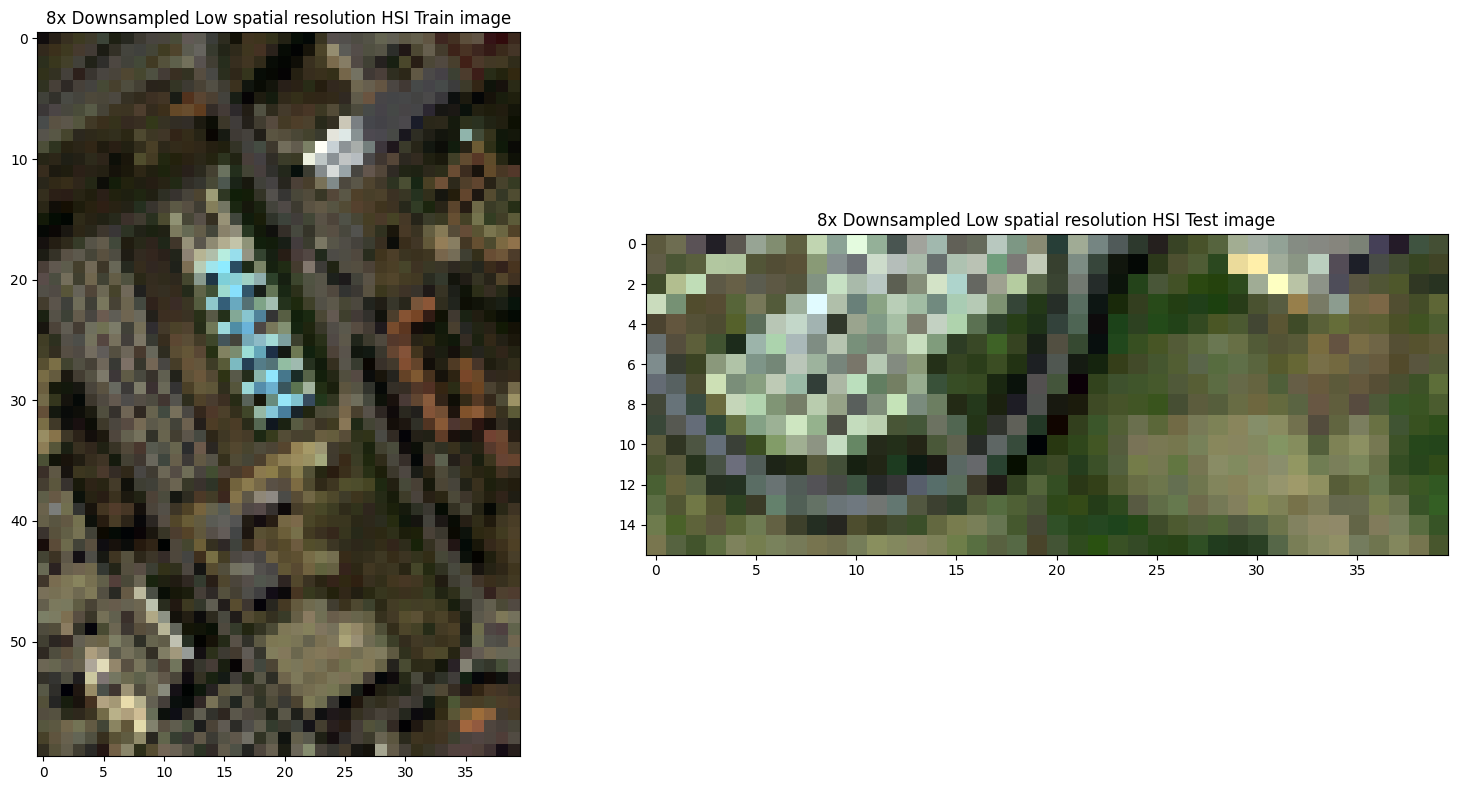

HSI train shape with 16x Downsample:  (30, 20, 103)
HSI test shape with 16x Downsample:  (8, 20, 103)


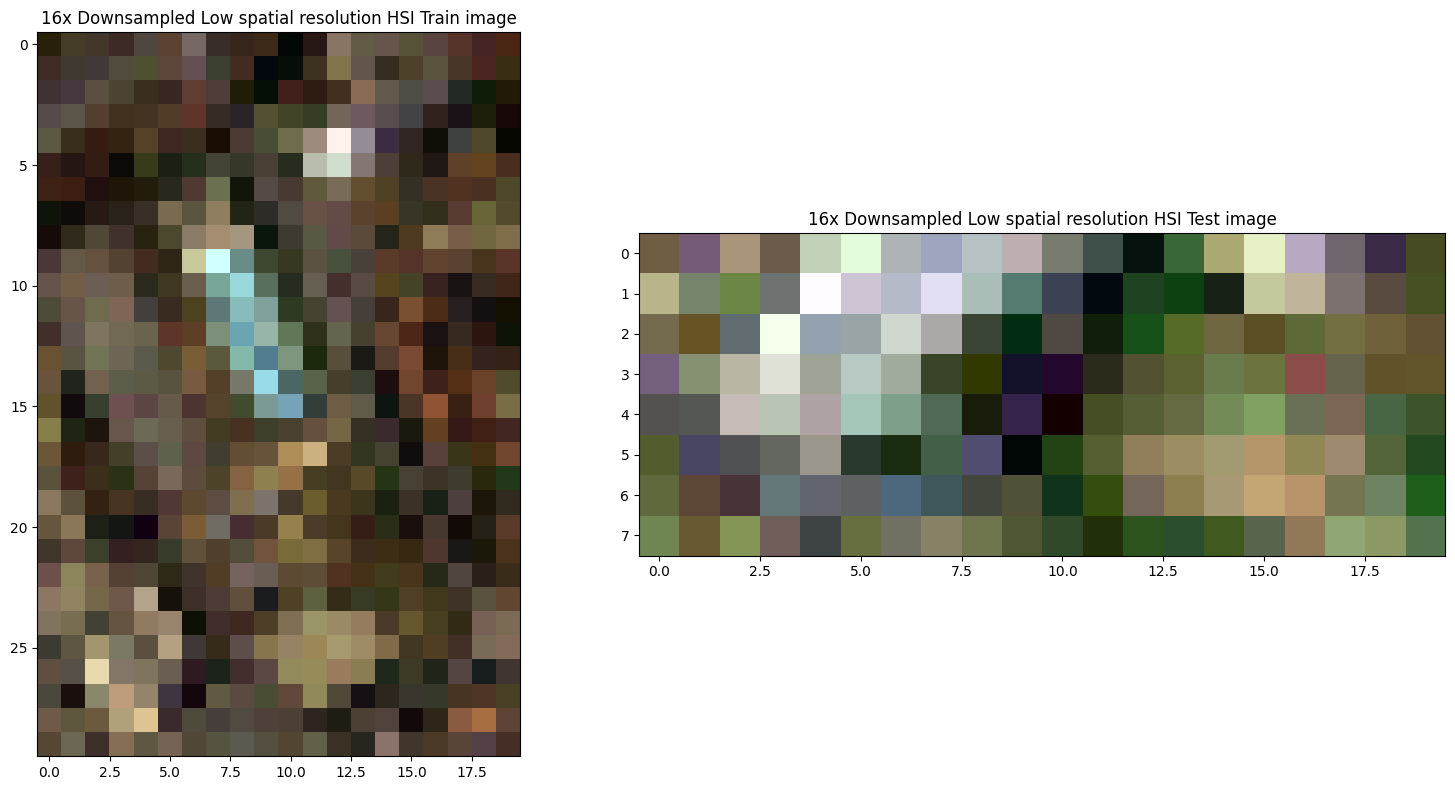

HSI train shape with 32x Downsample:  (15, 10, 103)
HSI test shape with 32x Downsample:  (4, 10, 103)


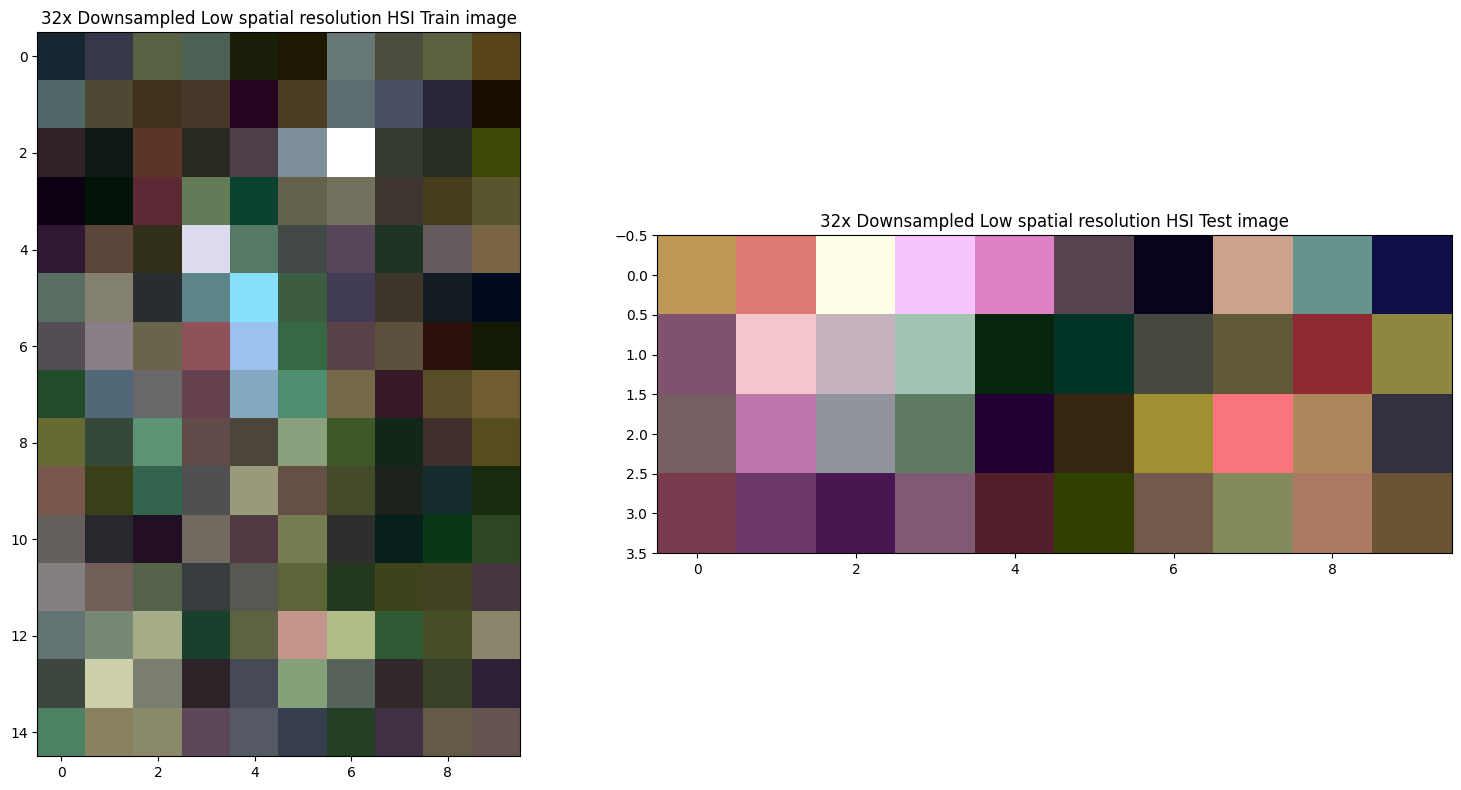

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_delta = spatial_degradation(pavia_university_image, delta_psf, 4, 35)
I_HS_4_train_delta, I_HS_4_test_delta = split_lr_hsi(I_HS_4_delta, downsample_factor=4)
print("HSI train shape with 4x Downsample: ", I_HS_4_train_delta.shape)
print("HSI test shape with 4x Downsample: ", I_HS_4_test_delta.shape)
visualize_hsi(I_HS_4_train_delta, I_HS_4_test_delta, (50,35,15), "4x Downsampled Low spatial resolution HSI Train image", "4x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_delta = spatial_degradation(pavia_university_image, delta_psf, 8, 30)
I_HS_8_train_delta, I_HS_8_test_delta = split_lr_hsi(I_HS_8_delta, downsample_factor=8)
print("HSI train shape with 8x Downsample: ", I_HS_8_train_delta.shape)
print("HSI test shape with 8x Downsample: ", I_HS_8_test_delta.shape)
visualize_hsi(I_HS_8_train_delta, I_HS_8_test_delta, (50,35,15), "8x Downsampled Low spatial resolution HSI Train image", "8x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_delta = spatial_degradation(pavia_university_image, delta_psf, 16, 25)
I_HS_16_train_delta, I_HS_16_test_delta = split_lr_hsi(I_HS_16_delta, downsample_factor=16)
print("HSI train shape with 16x Downsample: ", I_HS_16_train_delta.shape)
print("HSI test shape with 16x Downsample: ", I_HS_16_test_delta.shape)
visualize_hsi(I_HS_16_train_delta, I_HS_16_test_delta, (50,35,15), "16x Downsampled Low spatial resolution HSI Train image", "16x Downsampled Low spatial resolution HSI Test image")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_delta = spatial_degradation(pavia_university_image, delta_psf, 32, 20)
I_HS_32_train_delta, I_HS_32_test_delta = split_lr_hsi(I_HS_32_delta, downsample_factor=32)
print("HSI train shape with 32x Downsample: ", I_HS_32_train_delta.shape)
print("HSI test shape with 32x Downsample: ", I_HS_32_test_delta.shape)
visualize_hsi(I_HS_32_train_delta, I_HS_32_test_delta, (50,35,15), "32x Downsampled Low spatial resolution HSI Train image", "32x Downsampled Low spatial resolution HSI Test image")

Fourier-enhanced Implicit Neural Fusion Network for Multispectral and Hyperspectral Image Fusion implementation from their GitHub

In [12]:
def get_flops_fvcore(model, inputs):
    """
    Estimate FLOPs and parameter count using fvcore.

    Parameters
    ----------
    model : torch.nn.Module
        Your model.
    inputs : tuple
        Tuple of input tensors (e.g., (pan, lms, ms)).

    Returns
    -------
    flops : str
        FLOPs in readable format.
    param_table : str
        Parameter count in table format.
    """
    model.eval()
    with torch.no_grad():
        flops = FlopCountAnalysis(model, inputs)
        flops_total = flops.total()
        params = parameter_count_table(model, max_depth=2)
    return flops_total, params

In [13]:
# base_model.py

MODELS = {}

# use it in a decorator way
# e.g.
# @register_model('model_name')
def register_model(name):
    def inner(cls):
        MODELS[name] = cls
        return cls

    return inner


# base model class
# all model defination should inherit this class
from abc import ABC, abstractmethod
class BaseModel(ABC, nn.Module):
    
    @classmethod
    def __init_subclass__(cls, **kwargs):
        super().__init_subclass__(**kwargs)
        if not (cls._is_method_implemented('train_step') or cls._is_method_implemented('fusion_train_step')):
            raise NotImplementedError(f"{cls.__name__} must implement at least one of the methods: 'train_step' or 'fusion_train_step'")

        if not (cls._is_method_implemented('val_step') or cls._is_method_implemented('fusion_val_step')):
            raise NotImplementedError(f"{cls.__name__} must implement at least one of the methods: 'val_step' or 'fusion_val_step'")

    @staticmethod
    def _is_method_implemented(method):
        return any(method in B.__dict__ for B in BaseModel.__subclasses__())
    
    def train_step(
        self, ms, lms, pan, gt, criterion
    ) -> tuple[torch.Tensor, tuple[Tensor, dict[str, Tensor]]]:
        raise NotImplementedError

    def val_step(self, ms, lms, pan) -> torch.Tensor:
        raise NotImplementedError
    
    def fusion_train_step(self, vis, ir, mask, gt, criterion) -> tuple[torch.Tensor, tuple[Tensor, dict[str, Tensor]]]:
        raise NotImplementedError
    
    def fusion_val_step(self, vis, ir, mask) -> torch.Tensor:
        raise NotImplementedError

    def patch_merge_step(self, *args) -> torch.Tensor:
        # not compulsory
        raise NotImplementedError

    def forward(self, *args, mode="train", **kwargs):
        if mode == "train":
            return self.train_step(*args, **kwargs)
        elif mode == "eval":
            return self.val_step(*args, **kwargs)
        elif mode == 'fusion_train':
            return self.fusion_train_step(*args, **kwargs)
        elif mode == 'fusion_eval':
            return self.fusion_val_step(*args, **kwargs)
        elif mode == "patch_merge":
            raise DeprecationWarning("patch_merge is deprecated.")
            # return self.patch_merge_step(*args, **kwargs)
        else:
            raise NotImplementedError

    @abstractmethod
    def _forward_implem(self, *args, **kwargs):
        raise NotImplementedError

In [14]:
# fe_block.py

def make_coord(shape, ranges=None, flatten=True):
    """ Make coordinates at grid centers.
    """
    coord_seqs = []
    for i, n in enumerate(shape):
        if ranges is None:
            v0, v1 = -1, 1
        else:
            v0, v1 = ranges[i]
        r = (v1 - v0) / (2 * n)
        seq = v0 + r + (2 * r) * torch.arange(n).float()
        coord_seqs.append(seq)
    ret = torch.stack(torch.meshgrid(*coord_seqs), dim=-1)
    if flatten:
        ret = ret.view(-1, ret.shape[-1])
    return ret

def default_conv(in_channels, out_channels, kernel_size, bias=True):
    return nn.Conv2d(
        in_channels, out_channels, kernel_size,
        padding=(kernel_size//2), bias=bias)

class MeanShift(nn.Conv2d):
    def __init__(
        self, rgb_range,
        rgb_mean=(0.4488, 0.4371, 0.4040), rgb_std=(1.0, 1.0, 1.0), sign=-1):

        super(MeanShift, self).__init__(3, 3, kernel_size=1)
        std = torch.Tensor(rgb_std)
        self.weight.data = torch.eye(3).view(3, 3, 1, 1) / std.view(3, 1, 1, 1)
        self.bias.data = sign * rgb_range * torch.Tensor(rgb_mean) / std
        for p in self.parameters():
            p.requires_grad = False
            
class ResBlock(nn.Module):
    def __init__(
        self, conv, n_feats, kernel_size,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(conv(n_feats, n_feats, kernel_size, bias=bias))
            if bn:
                m.append(nn.BatchNorm2d(n_feats))
            if i == 0:
                m.append(act)

        self.body = nn.Sequential(*m)
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x).mul(self.res_scale)
        res += x

        return res

class EDSR(nn.Module):
    def __init__(self, args, conv=default_conv):
        super(EDSR, self).__init__()
        self.args = args
        n_resblocks = args.n_resblocks
        n_feats = args.n_feats
        kernel_size = 3
        scale = args.scale[0]
        act = nn.ReLU(True)
        self.sub_mean = MeanShift(args.rgb_range)
        self.add_mean = MeanShift(args.rgb_range, sign=1)

        # define head module
        m_head = [conv(args.n_colors, n_feats, kernel_size)]

        # define body module
        m_body = [
            ResBlock(
                conv, n_feats, kernel_size, act=act, res_scale=args.res_scale
            ) for _ in range(n_resblocks)
        ]
        m_body.append(conv(n_feats, n_feats, kernel_size))

        self.head = nn.Sequential(*m_head)
        self.body = nn.Sequential(*m_body)

        if args.no_upsampling:
            self.out_dim = n_feats
        else:
            self.out_dim = args.n_colors
            # define tail module
            m_tail = [
                Upsampler(conv, scale, n_feats, act=False),
                conv(n_feats, args.n_colors, kernel_size)
            ]
            self.tail = nn.Sequential(*m_tail)

    def forward(self, x):
        #x = self.sub_mean(x)
        x = self.head(x)

        res = self.body(x)
        res += x

        if self.args.no_upsampling:
            x = res
        else:
            x = self.tail(res)
        #x = self.add_mean(x)
        return x

    def load_state_dict(self, state_dict, strict=True):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name in own_state:
                if isinstance(param, nn.Parameter):
                    param = param.data
                try:
                    own_state[name].copy_(param)
                except Exception:
                    if name.find('tail') == -1:
                        raise RuntimeError('While copying the parameter named {}, '
                                           'whose dimensions in the model are {} and '
                                           'whose dimensions in the checkpoint are {}.'
                                           .format(name, own_state[name].size(), param.size()))
            elif strict:
                if name.find('tail') == -1:
                    raise KeyError('unexpected key "{}" in state_dict'
                                   .format(name))


def make_edsr_baseline(n_resblocks=16, n_feats=64, res_scale=1, n_colors=1,
                       scale=2, no_upsampling=True, rgb_range=1):
    args = Namespace()
    args.n_resblocks = n_resblocks
    args.n_feats = n_feats
    args.res_scale = res_scale

    args.scale = [scale]
    args.no_upsampling = no_upsampling

    args.rgb_range = rgb_range
    args.n_colors = n_colors
    return EDSR(args)


def make_edsr(n_resblocks=32, n_feats=256, res_scale=0.1, n_colors=1,
              scale=2, no_upsampling=True, rgb_range=1):
    args = Namespace()
    args.n_resblocks = n_resblocks
    args.n_feats = n_feats
    args.res_scale = res_scale

    args.scale = [scale]
    args.no_upsampling = no_upsampling

    args.rgb_range = rgb_range
    args.n_colors = n_colors
    return EDSR(args)

class ComplexGaborLayer(nn.Module):
    '''
        Complex Gabor nonlinearity 

        Inputs:
            input: Input features
            omega0: Frequency of Gabor sinusoid term
            sigma0: Scaling of Gabor Gaussian term
            trainable: If True, omega and sigma are trainable parameters
    '''

    def __init__(self, omega0=30.0, sigma0=10.0, trainable=True):
        super().__init__()
        self.omega_0 = omega0
        self.scale_0 = sigma0

        # Set trainable parameters if they are to be simultaneously optimized
        self.omega_0 = nn.Parameter(self.omega_0 * torch.ones(1), trainable)
        self.scale_0 = nn.Parameter(self.scale_0 * torch.ones(1), trainable)

    def forward(self, input):
        input = input.permute(0, -2, -1, 1)

        omega = self.omega_0 * input
        scale = self.scale_0 * input
        # return torch.exp(1j * omega - scale.abs().square())
        return torch.exp(1j * omega - scale.abs().square()).permute(0, -1, 1, 2)
    
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=4096):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        pe = self.pe[None]
        if x.size(1) > self.pe.size(1):
            # pe shape: [1, max_len, d_model]
            pe = pe.transpose(1, 2)  # [1, d_model, max_len]
            pe = F.interpolate(pe, size=(x.size(1)), mode='linear')
            pe = pe.transpose(1, 2)  # [1, max_len, d_model]

        pe_x = pe[:, :x.size(1)]
        x = x + pe_x
        return x
    
class MLP_P(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_list):
        super().__init__()
        layers = []
        lastv = in_dim
        for hidden in hidden_list:
            layers.append(nn.Sequential(
                        nn.Conv2d(lastv, hidden, kernel_size=1, bias=False),
                        nn.Conv2d(hidden, hidden, kernel_size=3, padding=1, bias=False, groups=hidden),
                        ))
            layers.append(nn.ReLU())
            lastv = hidden
        layers.append(nn.Sequential(
                        nn.Conv2d(lastv, out_dim, kernel_size=1, bias=False),
                        nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1, bias=False, groups=out_dim),
                        ))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x

class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_list):
        super().__init__()
        layers = []
        lastv = in_dim
        for hidden in hidden_list:
            layers.append(nn.Linear(lastv, hidden))
            layers.append(nn.ReLU())
            lastv = hidden
        layers.append(nn.Linear(lastv, out_dim))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x
    
class hightfre(nn.Module):

    def __init__(self, in_channels=128, out_channels=128, groups=1):
        super().__init__()
        self.groups = groups
        self.inch = in_channels
        self.outch = out_channels

        kernel = torch.tensor([[0, -1, 0],
                               [-1, 1, -1],
                               [0, -1, 0]], dtype=torch.float32)
        self.register_buffer('kernel', kernel)

    def forward(self, x):
        output = F.conv2d(x, self.kernel[None, None].repeat_interleave(self.inch, dim=0), groups=self.inch, padding=1)
        return output  
    
class ImplicitDecoder(nn.Module):
    def __init__(self, in_channels, freq_dim=31, hidden_dims=[128,128,128], omega=30, scale=10.0):
        super().__init__()

        last_dim_K = in_channels 
        last_dim_Q = freq_dim

        self.K = nn.ModuleList()
        self.Q = nn.ModuleList()
        
        for hidden_dim in hidden_dims:
            self.K.append(nn.Sequential(nn.Conv2d(last_dim_K, hidden_dim, 1),
                                        nn.ReLU()))
            self.Q.append(nn.Sequential(nn.Conv2d(last_dim_Q, hidden_dim, 1),
                                        ComplexGaborLayer(omega0=omega,
                                                        sigma0=scale,
                                                        trainable=True)))
            last_dim_K = hidden_dim + in_channels
            last_dim_Q = hidden_dim

        self.last_layer = nn.Conv2d(hidden_dims[-1], in_channels-1, 1)

    def step(self, x, y):
        k = self.K[0](x).real
        q = k * self.Q[0](y)
        q = q.real
        for i in range(1, len(self.K)):
            k = self.K[i](torch.cat([q, x], dim=1)).real
            q = k * self.Q[i](q)
            q = q.real
        q = self.last_layer(q)
        return q

    def forward(self, INR_feat, freq_feat):
        output = self.step(INR_feat, freq_feat)
        return output

In [15]:
# FeINFN.py

class FourierUnit(nn.Module):

    def __init__(self, feat_dim=128, guide_dim=128, mlp_dim=[256, 128], NIR_dim=33, d_model=2):
        super().__init__()
        self.feat_dim = feat_dim
        self.guide_dim = guide_dim
        self.mlp_dim = mlp_dim

        imnet_in_dim = self.feat_dim + self.guide_dim + 2
        self.imnet1 = MLP(imnet_in_dim, out_dim=NIR_dim, hidden_list=self.mlp_dim)
        self.imnet2 = MLP_P(imnet_in_dim, out_dim=NIR_dim, hidden_list=self.mlp_dim)

        # self.pe = PositionalEmbedding(d_model, max_len=4096)

    def query_freq_a(self, feat, coord, hr_guide, mlp):
        # feat: [B, C, h, w]
        # coord: [B, N, 2], N <= H * W

        b, c, h, w = feat.shape  # lr  7x128x8x8
        _, _, H, W = hr_guide.shape  # hr  7x128x64x64
        coord = coord.expand(b, H * W, 2)
        B, N, _ = coord.shape

        # LR centers' coords
        feat_coord = make_coord((h, w), flatten=False).to(feat.device).permute(2, 0, 1).unsqueeze(0).expand(b, 2, h, w)

        q_guide_hr = F.grid_sample(hr_guide, coord.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                     :].permute(0, 2, 1)  # [B, N, C]

        rx = 1 / h
        ry = 1 / w

        preds = []

        for vx in [-1, 1]:
            for vy in [-1, 1]:
                coord_ = coord.clone()
                coord_[:, :, 0] += (vx) * rx
                coord_[:, :, 1] += (vy) * ry

                # feat: [B, c, h, w], coord_: [B, N, 2] --> [B, 1, N, 2], out: [B, c, 1, N] --> [B, c, N] --> [B, N, c]
                q_feat = F.grid_sample(feat, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                         :].permute(0, 2, 1)  # [B, N, c]
                q_coord = F.grid_sample(feat_coord, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[
                          :, :, 0, :].permute(0, 2, 1)  # [B, N, 2]

                rel_coord = coord - q_coord # b x (64x64) x 2
                rel_coord[:, :, 0] *= h
                rel_coord[:, :, 1] *= w

                inp = torch.cat([q_feat, q_guide_hr, rel_coord], dim=-1)

                pred = mlp(inp.view(B * N, -1)).view(B, N, -1)  # [B, N, 2]
                preds.append(pred)

        preds = torch.stack(preds, dim=-1)  # [B, N, 2, kk]
        weight = F.softmax(preds[:, :, -1, :], dim=-1)
        ret = (preds[:, :, 0:-1, :] * weight.unsqueeze(-2)).sum(-1, keepdim=True).squeeze(-1)
        ret = ret.permute(0, 2, 1).view(b, -1, H, W)

        return ret
    def query_freq_p(self, feat, coord, hr_guide, mlp):
        # feat: [B, C, h, w]
        # coord: [B, N, 2], N <= H * W

        b, c, h, w = feat.shape  # lr  7x128x8x8
        _, _, H, W = hr_guide.shape  # hr  7x128x64x64
        coord = coord.expand(b, H * W, 2)
        B, N, _ = coord.shape

        # LR centers' coords
        feat_coord = make_coord((h, w), flatten=False).to(feat.device).permute(2, 0, 1).unsqueeze(0).expand(b, 2, h, w)

        q_guide_hr = F.grid_sample(hr_guide, coord.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                     :].permute(0, 2, 1)  # [B, N, C]

        rx = 1 / h
        ry = 1 / w

        preds = []

        for vx in [-1, 1]:
            for vy in [-1, 1]:
                coord_ = coord.clone()
                coord_[:, :, 0] += (vx) * rx
                coord_[:, :, 1] += (vy) * ry

                # feat: [B, c, h, w], coord_: [B, N, 2] --> [B, 1, N, 2], out: [B, c, 1, N] --> [B, c, N] --> [B, N, c]
                q_feat = F.grid_sample(feat, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                         :].permute(0, 2, 1)  # [B, N, c]
                q_coord = F.grid_sample(feat_coord, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[
                          :, :, 0, :].permute(0, 2, 1)  # [B, N, 2]

                rel_coord = coord - q_coord # b x (64x64) x 2
                rel_coord[:, :, 0] *= h
                rel_coord[:, :, 1] *= w

                inp = torch.cat([q_feat, q_guide_hr, rel_coord], dim=-1).view(B, -1, H, W)

                pred = mlp(inp).view(B, N, -1)  # [B, N, 2]
                preds.append(pred)

        preds = torch.stack(preds, dim=-1)  # [B, N, 2, kk]
        weight = F.softmax(preds[:, :, -1, :], dim=-1)
        ret = (preds[:, :, 0:-1, :] * weight.unsqueeze(-2)).sum(-1, keepdim=True).squeeze(-1)
        ret = ret.permute(0, 2, 1).view(b, -1, H, W)
        return ret

    def forward(self, feat, coord, hr_guide):
        feat_ffted = torch.fft.fftn(feat, dim=(-2,-1))
        guide_ffted = torch.fft.fftn(hr_guide, dim=(-2,-1))

        feat_mag = torch.abs(feat_ffted)
        feat_pha = torch.angle(feat_ffted)
        guide_mag = torch.abs(guide_ffted)
        guide_pha = torch.angle(guide_ffted)

        ffted_mag = self.query_freq_a(feat_mag, coord, guide_mag, self.imnet1)
        ffted_pha = self.query_freq_p(feat_pha, coord, guide_pha, self.imnet2)

        real = ffted_mag * torch.cos(ffted_pha)
        imag = ffted_mag * torch.sin(ffted_pha)
        ffted = torch.complex(real, imag)

        output = torch.fft.ifftn(ffted, dim =(-2,-1))
        output = torch.abs(output)
        # output = output.real

        return output         

@register_model('FeINFN')
class FeINFNet(BaseModel):
    def __init__(self, hsi_dim=31, msi_dim=3,feat_dim=128, guide_dim=128, spa_edsr_num=4, spe_edsr_num=4, mlp_dim=[256, 128], NIR_dim=33, d_model=2,
                 scale=4, patch_merge=False,):
        super().__init__() 
        self.feat_dim = feat_dim
        self.guide_dim = guide_dim
        self.mlp_dim = mlp_dim
        self.NIR_dim = NIR_dim
        self.d_model = d_model
        self.scale = scale

        self.spatial_encoder = make_edsr_baseline(n_resblocks=spa_edsr_num, n_feats=self.guide_dim, n_colors=hsi_dim+msi_dim)
        self.spectral_encoder = make_edsr_baseline(n_resblocks=spe_edsr_num, n_feats=self.feat_dim, n_colors=hsi_dim)

        imnet_in_dim = self.feat_dim + self.guide_dim + self.feat_dim + 2
        self.imnet = MLP(imnet_in_dim, out_dim=NIR_dim, hidden_list=self.mlp_dim)
        self.hp = hightfre(in_channels=feat_dim, groups=1)
        self.decoder = ImplicitDecoder(in_channels=NIR_dim - 1, freq_dim=NIR_dim - 1, hidden_dims=[128, 128, 128],
                                       omega=30, scale=10.0)
        self.pe = PositionalEmbedding(d_model, max_len=4096)
        self.freq_query = FourierUnit(feat_dim, guide_dim, mlp_dim, NIR_dim)

    def query(self, feat, coord, hr_guide):

        # feat: [B, C, h, w]
        # coord: [B, N, 2], N <= H * W

        b, c, h, w = feat.shape  # lr  7x128x8x8
        _, _, H, W = hr_guide.shape  # hr  7x128x64x64
        coord = coord.expand(b, H * W, 2)
        B, N, _ = coord.shape

        # LR centers' coords
        feat_coord = make_coord((h, w), flatten=False).to(feat.device).permute(2, 0, 1).unsqueeze(0).expand(b, 2, h, w)

        q_guide_hr = F.grid_sample(hr_guide, coord.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                     :].permute(0, 2, 1)  # [B, N, C]

        rx = 1 / h
        ry = 1 / w

        preds = []

        for vx in [-1, 1]:
            for vy in [-1, 1]:
                coord_ = coord.clone()

                coord_[:, :, 0] += (vx) * rx
                coord_[:, :, 1] += (vy) * ry
                
                hp = self.hp(feat)

                # feat: [B, c, h, w], coord_: [B, N, 2] --> [B, 1, N, 2], out: [B, c, 1, N] --> [B, c, N] --> [B, N, c]
                q_feat = F.grid_sample(feat, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                         :].permute(0, 2, 1)  # [B, N, c]
                hp_feat = F.grid_sample(hp, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[:, :, 0,
                         :].permute(0, 2, 1)  # [B, N, c])
                q_coord = F.grid_sample(feat_coord, coord_.flip(-1).unsqueeze(1), mode='nearest', align_corners=False)[
                          :, :, 0, :].permute(0, 2, 1)  # [B, N, 2]

                rel_coord = coord - q_coord 
                rel_coord[:, :, 0] *= h
                rel_coord[:, :, 1] *= w
                rel_coord = self.pe(rel_coord)

                inp = torch.cat([q_feat, q_guide_hr, hp_feat, rel_coord], dim=-1)

                pred = self.imnet(inp.view(B * N, -1)).view(B, N, -1)  # [B, N, 2]
                preds.append(pred)

        preds = torch.stack(preds, dim=-1)  # [B, N, 2, kk]
        weight = F.softmax(preds[:, :, -1, :], dim=-1)
        ret = (preds[:, :, 0:-1, :] * weight.unsqueeze(-2)).sum(-1, keepdim=True).squeeze(-1)
        ret = ret.permute(0, 2, 1).view(b, -1, H, W)

        return ret

    def _forward_implem(self, HR_MSI, lms, LR_HSI):
        # HR_MSI Bx3x64x64
        # lms Bx31x64x64
        # LR_HSI Bx31x16x16

        _, _, H, W = HR_MSI.shape
        coord = make_coord([H, W]).cuda()
        feat = torch.cat([HR_MSI, lms], dim=1)
        hr_spa = self.spatial_encoder(feat)  # Bx128xHxW
        lr_spe = self.spectral_encoder(LR_HSI)  # Bx128xhxw The feature map of LR-HSI

        freq_feature = self.freq_query(lr_spe, coord, hr_spa)
        NIR_feature = self.query(lr_spe, coord, hr_spa) 

        output = self.decoder(NIR_feature, freq_feature) 
        output = lms + output

        return output
    
    def forward(self, pan, lms, ms):
        return self._forward_implem(pan, lms, ms)

    def train_step(self, ms, lms, pan, gt, criterion):
        sr = self._forward_implem(pan, lms, ms)
        loss = criterion(sr, gt)
        
        return sr.clip(0, 1), loss

    def val_step(self, ms, lms, pan):        
        self.eval()
        device = ms.device

        # Measure parameter count
        num_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        # Estimate FLOPs (optional: try-except if torchprofile is used)
        try:
            flops_total, param_table = get_flops_fvcore(self, (
                pan.detach(), lms.detach(), ms.detach()
            ))
        except Exception as e:
            print(f"[Warning] fvcore failed: {str(e).splitlines()[0]}")
            flops_total = 0

        # Measure GPU memory and inference time
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats(device)
        start_memory = torch.cuda.max_memory_allocated(device)

        with torch.no_grad():
            start_time = time.time()
            pred = self._forward_implem(pan, lms, ms)
            end_time = time.time()

        end_memory = torch.cuda.max_memory_allocated(device)
        inference_time = end_time - start_time
        gpu_memory_used = end_memory - start_memory

        # Print metrics
        print(f"Number of parameters: {num_params}")
        print(f"FLOPs: {flops_total}")
        print(f"GPU memory consumed: {gpu_memory_used / (1024 ** 2):.2f} MB")
        print(f"Inference time: {inference_time:.4f} seconds")

        return pred.clip(0, 1)

Output file to save super-resolved images

In [16]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/FeINFN"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the MIAE folder
pavia_u_feinfn_folder_path = os.path.join(normalized_target_path, 'Pavia_University')

# Create the MIAE folder if it doesn't exist
if not os.path.exists(pavia_u_feinfn_folder_path):
    os.makedirs(pavia_u_feinfn_folder_path)

Functions to set up the inputs as required by FeINFN

In [17]:
def upsample_hsi_to_match(lr_hsi, hr_msi):
    """
    Upsample a low-resolution HSI to match the spatial resolution of a high-resolution MSI.

    Parameters
    ----------
    lr_hsi : np.ndarray
        Low-resolution hyperspectral image, shape: (H_lr, W_lr, C).
    hr_msi : np.ndarray
        High-resolution multispectral image, shape: (H_hr, W_hr, B).

    Returns
    -------
    np.ndarray
        Upsampled HSI with shape: (H_hr, W_hr, C).
    """
    target_H, target_W = hr_msi.shape[:2]
    C = lr_hsi.shape[2]
    upsampled = np.zeros((target_H, target_W, C), dtype=lr_hsi.dtype)
    for i in range(C):
        upsampled[:, :, i] = cv2.resize(
            lr_hsi[:, :, i],
            (target_W, target_H),
            interpolation=cv2.INTER_CUBIC
        )
    return upsampled

def numpy_to_torch(img_np):
    """
    Convert a NumPy image array of shape (H, W, C) to a PyTorch tensor
    with shape (1, C, H, W), and move it to the specified device.

    Parameters
    ----------
    img_np : np.ndarray
        Input NumPy array of shape (H, W, C).
    device : str
        Target device, e.g., 'cuda' or 'cpu'. Default is 'cuda'.

    Returns
    -------
    torch.Tensor
        Tensor of shape (1, C, H, W) on the specified device.
    """
    img_np = np.transpose(img_np, (2, 0, 1))        # (C, H, W)
    img_np = np.expand_dims(img_np, axis=0)         # (1, C, H, W)
    img_tensor = torch.from_numpy(img_np).float()   # Ensure float dtype
    return img_tensor.to(device)

def torch_to_numpy(tensor):
    """
    Convert a PyTorch tensor of shape (1, C, H, W) to a NumPy array of shape (H, W, C).

    Parameters
    ----------
    tensor : torch.Tensor
        PyTorch tensor with shape (1, C, H, W).

    Returns
    -------
    np.ndarray
        NumPy array with shape (H, W, C).
    """
    tensor = tensor.cpu().detach().numpy()          # Move to CPU and convert to NumPy
    tensor = np.squeeze(tensor)                     # Remove batch dimension -> (C, H, W)
    tensor = np.transpose(tensor, (1, 2, 0))        # Convert to (H, W, C)
    return tensor

## Super Resolving HSI degraded with Gaussian PSF

In [27]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
pavia_u_feinfn_gaus_folder_path = os.path.join(pavia_u_feinfn_folder_path, 'Gaussian_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(pavia_u_feinfn_gaus_folder_path):
    os.makedirs(pavia_u_feinfn_gaus_folder_path)

Running FeINFN on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [28]:
# Obtaining the inputs
upsampled_I_HS_4_train_gaus = upsample_hsi_to_match(I_HS_4_train_gaus, I_MS_4_train)
upsampled_I_HS_4_test_gaus = upsample_hsi_to_match(I_HS_4_test_gaus, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_4_train_tensor_gaus = numpy_to_torch(I_HS_4_train_gaus)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_4_train_tensor_gaus = numpy_to_torch(upsampled_I_HS_4_train_gaus)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_4_test_tensor_gaus = numpy_to_torch(I_HS_4_test_gaus)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_4_test_tensor_gaus = numpy_to_torch(upsampled_I_HS_4_test_gaus)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_4_gaus.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_4_gaus.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=4
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_4_train_tensor_gaus, 
                                        upsampled_I_HS_4_train_tensor_gaus, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_4_test_tensor_gaus,
        upsampled_I_HS_4_test_tensor_gaus,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gaus_folder_path}/SR_Pavia_U_gaussian_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gaus_folder_path")

Training:   0%|          | 0/5000 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Training: 100%|██████████| 5000/5000 [19:36<00:00,  4.25it/s, lr=0, loss=0.0117]      


Training completed in  1176.24 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 130193653760
GPU memory consumed: 386.32 MB
Inference time: 0.0184 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gaus_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [29]:
# Obtaining the inputs
upsampled_I_HS_8_train_gaus = upsample_hsi_to_match(I_HS_8_train_gaus, I_MS_4_train)
upsampled_I_HS_8_test_gaus = upsample_hsi_to_match(I_HS_8_test_gaus, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_gaus = numpy_to_torch(I_HS_8_train_gaus)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_8_train_tensor_gaus = numpy_to_torch(upsampled_I_HS_8_train_gaus)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_gaus = numpy_to_torch(I_HS_8_test_gaus)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_8_test_tensor_gaus = numpy_to_torch(upsampled_I_HS_8_test_gaus)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_gaus.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_gaus.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_gaus, 
                                        upsampled_I_HS_8_train_tensor_gaus, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_gaus,
        upsampled_I_HS_8_test_tensor_gaus,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gaus_folder_path}/SR_Pavia_U_gaussian_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gaus_folder_path")

Training: 100%|██████████| 5000/5000 [19:44<00:00,  4.22it/s, lr=0, loss=0.0132]      


Training completed in  1184.84 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 127408947200
GPU memory consumed: 381.16 MB
Inference time: 0.0163 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gaus_folder_path


Running FeINFN on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [30]:
# Obtaining the inputs
upsampled_I_HS_16_train_gaus = upsample_hsi_to_match(I_HS_16_train_gaus, I_MS_4_train)
upsampled_I_HS_16_test_gaus = upsample_hsi_to_match(I_HS_16_test_gaus, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_16_train_tensor_gaus = numpy_to_torch(I_HS_16_train_gaus)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_16_train_tensor_gaus = numpy_to_torch(upsampled_I_HS_16_train_gaus)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_16_test_tensor_gaus = numpy_to_torch(I_HS_16_test_gaus)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_16_test_tensor_gaus = numpy_to_torch(upsampled_I_HS_16_test_gaus)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_16_gaus.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_16_gaus.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=16
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_16_train_tensor_gaus, 
                                        upsampled_I_HS_16_train_tensor_gaus, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_16_test_tensor_gaus,
        upsampled_I_HS_16_test_tensor_gaus,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gaus_folder_path}/SR_Pavia_U_gaussian_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gaus_folder_path")

Training: 100%|██████████| 5000/5000 [20:00<00:00,  4.16it/s, lr=0, loss=0.0171]      


Training completed in  1200.88 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126712770560
GPU memory consumed: 379.71 MB
Inference time: 0.0173 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gaus_folder_path


Running FeINFN on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [31]:
# Obtaining the inputs
upsampled_I_HS_32_train_gaus = upsample_hsi_to_match(I_HS_32_train_gaus, I_MS_4_train)
upsampled_I_HS_32_test_gaus = upsample_hsi_to_match(I_HS_32_test_gaus, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_32_train_tensor_gaus = numpy_to_torch(I_HS_32_train_gaus)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_32_train_tensor_gaus = numpy_to_torch(upsampled_I_HS_32_train_gaus)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_32_test_tensor_gaus = numpy_to_torch(I_HS_32_test_gaus)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_32_test_tensor_gaus = numpy_to_torch(upsampled_I_HS_32_test_gaus)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_32_gaus.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_32_gaus.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=32
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_32_train_tensor_gaus, 
                                        upsampled_I_HS_32_train_tensor_gaus, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_32_test_tensor_gaus,
        upsampled_I_HS_32_test_tensor_gaus,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gaus_folder_path}/SR_Pavia_U_gaussian_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gaus_folder_path")

Training: 100%|██████████| 5000/5000 [20:24<00:00,  4.08it/s, lr=0, loss=0.0217]      


Training completed in  1224.03 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126538726400
GPU memory consumed: 380.63 MB
Inference time: 0.0156 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gaus_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [28]:
# Obtaining the inputs
upsampled_I_HS_8_train_gaus = upsample_hsi_to_match(I_HS_8_train_gaus, I_MS_1_train)
upsampled_I_HS_8_test_gaus = upsample_hsi_to_match(I_HS_8_test_gaus, I_MS_1_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_gaus = numpy_to_torch(I_HS_8_train_gaus)
I_MS_1_train_tensor = numpy_to_torch(I_MS_1_train)
upsampled_I_HS_8_train_tensor_gaus = numpy_to_torch(upsampled_I_HS_8_train_gaus)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_gaus = numpy_to_torch(I_HS_8_test_gaus)
I_MS_1_test_tensor = numpy_to_torch(I_MS_1_test)
upsampled_I_HS_8_test_tensor_gaus = numpy_to_torch(upsampled_I_HS_8_test_gaus)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_gaus.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_1.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_gaus.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_gaus, 
                                        upsampled_I_HS_8_train_tensor_gaus, 
                                        I_MS_1_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_gaus,
        upsampled_I_HS_8_test_tensor_gaus,
        I_MS_1_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gaus_folder_path}/SR_Pavia_U_gaussian_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_gaus_folder_path")

Training:   0%|          | 0/5000 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Training: 100%|██████████| 5000/5000 [19:39<00:00,  4.24it/s, lr=0, loss=0.0198]      


Training completed in  1179.11 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3402992
FLOPs: 127267389440
GPU memory consumed: 381.42 MB
Inference time: 0.0186 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_gaus_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [29]:
# Obtaining the inputs
upsampled_I_HS_8_train_gaus = upsample_hsi_to_match(I_HS_8_train_gaus, I_MS_3_train)
upsampled_I_HS_8_test_gaus = upsample_hsi_to_match(I_HS_8_test_gaus, I_MS_3_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_gaus = numpy_to_torch(I_HS_8_train_gaus)
I_MS_3_train_tensor = numpy_to_torch(I_MS_3_train)
upsampled_I_HS_8_train_tensor_gaus = numpy_to_torch(upsampled_I_HS_8_train_gaus)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_gaus = numpy_to_torch(I_HS_8_test_gaus)
I_MS_3_test_tensor = numpy_to_torch(I_MS_3_test)
upsampled_I_HS_8_test_tensor_gaus = numpy_to_torch(upsampled_I_HS_8_test_gaus)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_gaus.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_3.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_gaus.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_gaus, 
                                        upsampled_I_HS_8_train_tensor_gaus, 
                                        I_MS_3_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_gaus,
        upsampled_I_HS_8_test_tensor_gaus,
        I_MS_3_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gaus_folder_path}/SR_Pavia_U_gaussian_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_gaus_folder_path")

Training: 100%|██████████| 5000/5000 [19:36<00:00,  4.25it/s, lr=0, loss=0.0130]      


Training completed in  1176.68 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3405296
FLOPs: 127361761280
GPU memory consumed: 381.58 MB
Inference time: 0.0149 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_gaus_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [30]:
# Obtaining the inputs
upsampled_I_HS_8_train_gaus = upsample_hsi_to_match(I_HS_8_train_gaus, I_MS_8_train)
upsampled_I_HS_8_test_gaus = upsample_hsi_to_match(I_HS_8_test_gaus, I_MS_8_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_gaus = numpy_to_torch(I_HS_8_train_gaus)
I_MS_8_train_tensor = numpy_to_torch(I_MS_8_train)
upsampled_I_HS_8_train_tensor_gaus = numpy_to_torch(upsampled_I_HS_8_train_gaus)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_gaus = numpy_to_torch(I_HS_8_test_gaus)
I_MS_8_test_tensor = numpy_to_torch(I_MS_8_test)
upsampled_I_HS_8_test_tensor_gaus = numpy_to_torch(upsampled_I_HS_8_test_gaus)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_gaus.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_8.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_gaus.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_gaus, 
                                        upsampled_I_HS_8_train_tensor_gaus, 
                                        I_MS_8_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_gaus,
        upsampled_I_HS_8_test_tensor_gaus,
        I_MS_8_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gaus_folder_path}/SR_Pavia_U_gaussian_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_gaus_folder_path")

Training: 100%|██████████| 5000/5000 [19:42<00:00,  4.23it/s, lr=0, loss=0.0124]      


Training completed in  1182.73 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3411056
FLOPs: 127597690880
GPU memory consumed: 381.79 MB
Inference time: 0.0183 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_gaus_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [31]:
# Obtaining the inputs
upsampled_I_HS_8_train_gaus = upsample_hsi_to_match(I_HS_8_train_gaus, I_MS_16_train)
upsampled_I_HS_8_test_gaus = upsample_hsi_to_match(I_HS_8_test_gaus, I_MS_16_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_gaus = numpy_to_torch(I_HS_8_train_gaus)
I_MS_16_train_tensor = numpy_to_torch(I_MS_16_train)
upsampled_I_HS_8_train_tensor_gaus = numpy_to_torch(upsampled_I_HS_8_train_gaus)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_gaus = numpy_to_torch(I_HS_8_test_gaus)
I_MS_16_test_tensor = numpy_to_torch(I_MS_16_test)
upsampled_I_HS_8_test_tensor_gaus = numpy_to_torch(upsampled_I_HS_8_test_gaus)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_gaus.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_16.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_gaus.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_gaus, 
                                        upsampled_I_HS_8_train_tensor_gaus, 
                                        I_MS_16_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_gaus,
        upsampled_I_HS_8_test_tensor_gaus,
        I_MS_16_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gaus_folder_path}/SR_Pavia_U_gaussian_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_gaus_folder_path")

Training: 100%|██████████| 5000/5000 [19:37<00:00,  4.25it/s, lr=0, loss=0.0117]      


Training completed in  1177.80 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3420272
FLOPs: 127975178240
GPU memory consumed: 382.92 MB
Inference time: 0.0151 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_gaus_folder_path


## Super Resolving HSI degraded with Kolmogorov PSF

In [32]:
# Creating sub folder within which to save the super resolved images from Kolmogorov PSF degraded HSI
pavia_u_feinfn_kol_folder_path = os.path.join(pavia_u_feinfn_folder_path, 'Kolmogorov_PSF')

# Create the Kolmogorov sub folder if it doesn't exist
if not os.path.exists(pavia_u_feinfn_kol_folder_path):
    os.makedirs(pavia_u_feinfn_kol_folder_path)

Running FeINFN on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [33]:
# Obtaining the inputs
upsampled_I_HS_4_train_kol = upsample_hsi_to_match(I_HS_4_train_kol, I_MS_4_train)
upsampled_I_HS_4_test_kol = upsample_hsi_to_match(I_HS_4_test_kol, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_4_train_tensor_kol = numpy_to_torch(I_HS_4_train_kol)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_4_train_tensor_kol = numpy_to_torch(upsampled_I_HS_4_train_kol)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_4_test_tensor_kol = numpy_to_torch(I_HS_4_test_kol)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_4_test_tensor_kol = numpy_to_torch(upsampled_I_HS_4_test_kol)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_4_kol.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_4_kol.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=4
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_4_train_tensor_kol, 
                                        upsampled_I_HS_4_train_tensor_kol, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_4_test_tensor_kol,
        upsampled_I_HS_4_test_tensor_kol,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_kol_folder_path}/SR_Pavia_U_kolmogorov_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_kol_folder_path")

Training: 100%|██████████| 5000/5000 [19:38<00:00,  4.24it/s, lr=0, loss=0.0103]      


Training completed in  1178.63 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 130193653760
GPU memory consumed: 386.24 MB
Inference time: 0.0191 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_kol_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [34]:
# Obtaining the inputs
upsampled_I_HS_8_train_kol = upsample_hsi_to_match(I_HS_8_train_kol, I_MS_4_train)
upsampled_I_HS_8_test_kol = upsample_hsi_to_match(I_HS_8_test_kol, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_kol = numpy_to_torch(I_HS_8_train_kol)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_8_train_tensor_kol = numpy_to_torch(upsampled_I_HS_8_train_kol)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_kol = numpy_to_torch(I_HS_8_test_kol)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_8_test_tensor_kol = numpy_to_torch(upsampled_I_HS_8_test_kol)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_kol.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_kol.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_kol, 
                                        upsampled_I_HS_8_train_tensor_kol, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_kol,
        upsampled_I_HS_8_test_tensor_kol,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_kol_folder_path")

Training: 100%|██████████| 5000/5000 [19:39<00:00,  4.24it/s, lr=0, loss=0.0129]      


Training completed in  1179.76 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 127408947200
GPU memory consumed: 381.51 MB
Inference time: 0.0184 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_kol_folder_path


Running FeINFN on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [35]:
# Obtaining the inputs
upsampled_I_HS_16_train_kol = upsample_hsi_to_match(I_HS_16_train_kol, I_MS_4_train)
upsampled_I_HS_16_test_kol = upsample_hsi_to_match(I_HS_16_test_kol, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_16_train_tensor_kol = numpy_to_torch(I_HS_16_train_kol)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_16_train_tensor_kol = numpy_to_torch(upsampled_I_HS_16_train_kol)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_16_test_tensor_kol = numpy_to_torch(I_HS_16_test_kol)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_16_test_tensor_kol = numpy_to_torch(upsampled_I_HS_16_test_kol)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_16_kol.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_16_kol.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=16
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_16_train_tensor_kol, 
                                        upsampled_I_HS_16_train_tensor_kol, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_16_test_tensor_kol,
        upsampled_I_HS_16_test_tensor_kol,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_kol_folder_path}/SR_Pavia_U_kolmogorov_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_kol_folder_path")

Training: 100%|██████████| 5000/5000 [20:08<00:00,  4.14it/s, lr=0, loss=0.0166]      


Training completed in  1208.13 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126712770560
GPU memory consumed: 379.71 MB
Inference time: 0.0153 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_kol_folder_path


Running FeINFN on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [36]:
# Obtaining the inputs
upsampled_I_HS_32_train_kol = upsample_hsi_to_match(I_HS_32_train_kol, I_MS_4_train)
upsampled_I_HS_32_test_kol = upsample_hsi_to_match(I_HS_32_test_kol, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_32_train_tensor_kol = numpy_to_torch(I_HS_32_train_kol)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_32_train_tensor_kol = numpy_to_torch(upsampled_I_HS_32_train_kol)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_32_test_tensor_kol = numpy_to_torch(I_HS_32_test_kol)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_32_test_tensor_kol = numpy_to_torch(upsampled_I_HS_32_test_kol)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_32_kol.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_32_kol.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=32
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_32_train_tensor_kol, 
                                        upsampled_I_HS_32_train_tensor_kol, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_32_test_tensor_kol,
        upsampled_I_HS_32_test_tensor_kol,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_kol_folder_path}/SR_Pavia_U_kolmogorov_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_kol_folder_path")

Training: 100%|██████████| 5000/5000 [20:22<00:00,  4.09it/s, lr=0, loss=0.0216]      


Training completed in  1222.73 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126538726400
GPU memory consumed: 379.20 MB
Inference time: 0.0149 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_kol_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [37]:
# Obtaining the inputs
upsampled_I_HS_8_train_kol = upsample_hsi_to_match(I_HS_8_train_kol, I_MS_1_train)
upsampled_I_HS_8_test_kol = upsample_hsi_to_match(I_HS_8_test_kol, I_MS_1_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_kol = numpy_to_torch(I_HS_8_train_kol)
I_MS_1_train_tensor = numpy_to_torch(I_MS_1_train)
upsampled_I_HS_8_train_tensor_kol = numpy_to_torch(upsampled_I_HS_8_train_kol)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_kol = numpy_to_torch(I_HS_8_test_kol)
I_MS_1_test_tensor = numpy_to_torch(I_MS_1_test)
upsampled_I_HS_8_test_tensor_kol = numpy_to_torch(upsampled_I_HS_8_test_kol)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_kol.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_1.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_kol.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_kol, 
                                        upsampled_I_HS_8_train_tensor_kol, 
                                        I_MS_1_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_kol,
        upsampled_I_HS_8_test_tensor_kol,
        I_MS_1_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_kol_folder_path")

Training: 100%|██████████| 5000/5000 [19:34<00:00,  4.26it/s, lr=0, loss=0.0181]      


Training completed in  1174.22 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3402992
FLOPs: 127267389440
GPU memory consumed: 381.20 MB
Inference time: 0.0161 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_kol_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [38]:
# Obtaining the inputs
upsampled_I_HS_8_train_kol = upsample_hsi_to_match(I_HS_8_train_kol, I_MS_3_train)
upsampled_I_HS_8_test_kol = upsample_hsi_to_match(I_HS_8_test_kol, I_MS_3_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_kol = numpy_to_torch(I_HS_8_train_kol)
I_MS_3_train_tensor = numpy_to_torch(I_MS_3_train)
upsampled_I_HS_8_train_tensor_kol = numpy_to_torch(upsampled_I_HS_8_train_kol)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_kol = numpy_to_torch(I_HS_8_test_kol)
I_MS_3_test_tensor = numpy_to_torch(I_MS_3_test)
upsampled_I_HS_8_test_tensor_kol = numpy_to_torch(upsampled_I_HS_8_test_kol)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_kol.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_3.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_kol.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_kol, 
                                        upsampled_I_HS_8_train_tensor_kol, 
                                        I_MS_3_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_kol,
        upsampled_I_HS_8_test_tensor_kol,
        I_MS_3_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_kol_folder_path")

Training: 100%|██████████| 5000/5000 [19:36<00:00,  4.25it/s, lr=0, loss=0.0141]      


Training completed in  1176.83 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3405296
FLOPs: 127361761280
GPU memory consumed: 381.24 MB
Inference time: 0.0270 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_kol_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [39]:
# Obtaining the inputs
upsampled_I_HS_8_train_kol = upsample_hsi_to_match(I_HS_8_train_kol, I_MS_8_train)
upsampled_I_HS_8_test_kol = upsample_hsi_to_match(I_HS_8_test_kol, I_MS_8_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_kol = numpy_to_torch(I_HS_8_train_kol)
I_MS_8_train_tensor = numpy_to_torch(I_MS_8_train)
upsampled_I_HS_8_train_tensor_kol = numpy_to_torch(upsampled_I_HS_8_train_kol)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_kol = numpy_to_torch(I_HS_8_test_kol)
I_MS_8_test_tensor = numpy_to_torch(I_MS_8_test)
upsampled_I_HS_8_test_tensor_kol = numpy_to_torch(upsampled_I_HS_8_test_kol)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_kol.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_8.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_kol.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_kol, 
                                        upsampled_I_HS_8_train_tensor_kol, 
                                        I_MS_8_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_kol,
        upsampled_I_HS_8_test_tensor_kol,
        I_MS_8_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_kol_folder_path")

Training: 100%|██████████| 5000/5000 [19:35<00:00,  4.25it/s, lr=0, loss=0.0122]      


Training completed in  1175.72 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3411056
FLOPs: 127597690880
GPU memory consumed: 381.79 MB
Inference time: 0.0155 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_kol_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [40]:
# Obtaining the inputs
upsampled_I_HS_8_train_kol = upsample_hsi_to_match(I_HS_8_train_kol, I_MS_16_train)
upsampled_I_HS_8_test_kol = upsample_hsi_to_match(I_HS_8_test_kol, I_MS_16_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_kol = numpy_to_torch(I_HS_8_train_kol)
I_MS_16_train_tensor = numpy_to_torch(I_MS_16_train)
upsampled_I_HS_8_train_tensor_kol = numpy_to_torch(upsampled_I_HS_8_train_kol)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_kol = numpy_to_torch(I_HS_8_test_kol)
I_MS_16_test_tensor = numpy_to_torch(I_MS_16_test)
upsampled_I_HS_8_test_tensor_kol = numpy_to_torch(upsampled_I_HS_8_test_kol)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_kol.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_16.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_kol.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_kol, 
                                        upsampled_I_HS_8_train_tensor_kol, 
                                        I_MS_16_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_kol,
        upsampled_I_HS_8_test_tensor_kol,
        I_MS_16_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_kol_folder_path}/SR_Pavia_U_kolmogorov_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_kol_folder_path")

Training: 100%|██████████| 5000/5000 [19:41<00:00,  4.23it/s, lr=0, loss=0.0117]      


Training completed in  1181.73 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3420272
FLOPs: 127975178240
GPU memory consumed: 383.23 MB
Inference time: 0.0148 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_kol_folder_path


## Super Resolving HSI degraded with Airy PSF

In [41]:
# Creating sub folder within which to save the super resolved images from Airy PSF degraded HSI
pavia_u_feinfn_air_folder_path = os.path.join(pavia_u_feinfn_folder_path, 'Airy_PSF')

# Create the Airy sub folder if it doesn't exist
if not os.path.exists(pavia_u_feinfn_air_folder_path):
    os.makedirs(pavia_u_feinfn_air_folder_path)

Running FeINFN on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [42]:
# Obtaining the inputs
upsampled_I_HS_4_train_air = upsample_hsi_to_match(I_HS_4_train_air, I_MS_4_train)
upsampled_I_HS_4_test_air = upsample_hsi_to_match(I_HS_4_test_air, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_4_train_tensor_air = numpy_to_torch(I_HS_4_train_air)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_4_train_tensor_air = numpy_to_torch(upsampled_I_HS_4_train_air)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_4_test_tensor_air = numpy_to_torch(I_HS_4_test_air)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_4_test_tensor_air = numpy_to_torch(upsampled_I_HS_4_test_air)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_4_air.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_4_air.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=4
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_4_train_tensor_air, 
                                        upsampled_I_HS_4_train_tensor_air, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_4_test_tensor_air,
        upsampled_I_HS_4_test_tensor_air,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_air_folder_path}/SR_Pavia_U_airy_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_air_folder_path")

Training: 100%|██████████| 5000/5000 [19:34<00:00,  4.26it/s, lr=0, loss=0.0097]      


Training completed in  1174.33 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 130193653760
GPU memory consumed: 386.77 MB
Inference time: 0.0158 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_air_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [43]:
# Obtaining the inputs
upsampled_I_HS_8_train_air = upsample_hsi_to_match(I_HS_8_train_air, I_MS_4_train)
upsampled_I_HS_8_test_air = upsample_hsi_to_match(I_HS_8_test_air, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_air = numpy_to_torch(I_HS_8_train_air)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_8_train_tensor_air = numpy_to_torch(upsampled_I_HS_8_train_air)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_air = numpy_to_torch(I_HS_8_test_air)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_8_test_tensor_air = numpy_to_torch(upsampled_I_HS_8_test_air)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_air.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_air.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_air, 
                                        upsampled_I_HS_8_train_tensor_air, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_air,
        upsampled_I_HS_8_test_tensor_air,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_air_folder_path}/SR_Pavia_U_airy_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_air_folder_path")

Training: 100%|██████████| 5000/5000 [19:37<00:00,  4.25it/s, lr=0, loss=0.0125]      


Training completed in  1177.36 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 127408947200
GPU memory consumed: 381.51 MB
Inference time: 0.0146 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_air_folder_path


Running FeINFN on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [44]:
# Obtaining the inputs
upsampled_I_HS_16_train_air = upsample_hsi_to_match(I_HS_16_train_air, I_MS_4_train)
upsampled_I_HS_16_test_air = upsample_hsi_to_match(I_HS_16_test_air, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_16_train_tensor_air = numpy_to_torch(I_HS_16_train_air)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_16_train_tensor_air = numpy_to_torch(upsampled_I_HS_16_train_air)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_16_test_tensor_air = numpy_to_torch(I_HS_16_test_air)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_16_test_tensor_air = numpy_to_torch(upsampled_I_HS_16_test_air)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_16_air.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_16_air.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=16
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_16_train_tensor_air, 
                                        upsampled_I_HS_16_train_tensor_air, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_16_test_tensor_air,
        upsampled_I_HS_16_test_tensor_air,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_air_folder_path}/SR_Pavia_U_airy_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_air_folder_path")

Training: 100%|██████████| 5000/5000 [19:59<00:00,  4.17it/s, lr=0, loss=0.0173]      


Training completed in  1200.00 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126712770560
GPU memory consumed: 378.99 MB
Inference time: 0.0180 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_air_folder_path


Running FeINFN on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [45]:
# Obtaining the inputs
upsampled_I_HS_32_train_air = upsample_hsi_to_match(I_HS_32_train_air, I_MS_4_train)
upsampled_I_HS_32_test_air = upsample_hsi_to_match(I_HS_32_test_air, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_32_train_tensor_air = numpy_to_torch(I_HS_32_train_air)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_32_train_tensor_air = numpy_to_torch(upsampled_I_HS_32_train_air)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_32_test_tensor_air = numpy_to_torch(I_HS_32_test_air)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_32_test_tensor_air = numpy_to_torch(upsampled_I_HS_32_test_air)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_32_air.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_32_air.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=32
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_32_train_tensor_air, 
                                        upsampled_I_HS_32_train_tensor_air, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_32_test_tensor_air,
        upsampled_I_HS_32_test_tensor_air,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_air_folder_path}/SR_Pavia_U_airy_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_air_folder_path")

Training: 100%|██████████| 5000/5000 [20:24<00:00,  4.08it/s, lr=0, loss=0.0200]      


Training completed in  1224.14 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126538726400
GPU memory consumed: 379.69 MB
Inference time: 0.0157 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_air_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [46]:
# Obtaining the inputs
upsampled_I_HS_8_train_air = upsample_hsi_to_match(I_HS_8_train_air, I_MS_1_train)
upsampled_I_HS_8_test_air = upsample_hsi_to_match(I_HS_8_test_air, I_MS_1_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_air = numpy_to_torch(I_HS_8_train_air)
I_MS_1_train_tensor = numpy_to_torch(I_MS_1_train)
upsampled_I_HS_8_train_tensor_air = numpy_to_torch(upsampled_I_HS_8_train_air)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_air = numpy_to_torch(I_HS_8_test_air)
I_MS_1_test_tensor = numpy_to_torch(I_MS_1_test)
upsampled_I_HS_8_test_tensor_air = numpy_to_torch(upsampled_I_HS_8_test_air)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_air.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_1.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_air.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_air, 
                                        upsampled_I_HS_8_train_tensor_air, 
                                        I_MS_1_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_air,
        upsampled_I_HS_8_test_tensor_air,
        I_MS_1_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_air_folder_path}/SR_Pavia_U_airy_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_air_folder_path")

Training: 100%|██████████| 5000/5000 [19:37<00:00,  4.24it/s, lr=0, loss=0.0178]      


Training completed in  1177.94 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3402992
FLOPs: 127267389440
GPU memory consumed: 380.51 MB
Inference time: 0.0148 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_air_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [47]:
# Obtaining the inputs
upsampled_I_HS_8_train_air = upsample_hsi_to_match(I_HS_8_train_air, I_MS_3_train)
upsampled_I_HS_8_test_air = upsample_hsi_to_match(I_HS_8_test_air, I_MS_3_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_air = numpy_to_torch(I_HS_8_train_air)
I_MS_3_train_tensor = numpy_to_torch(I_MS_3_train)
upsampled_I_HS_8_train_tensor_air = numpy_to_torch(upsampled_I_HS_8_train_air)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_air = numpy_to_torch(I_HS_8_test_air)
I_MS_3_test_tensor = numpy_to_torch(I_MS_3_test)
upsampled_I_HS_8_test_tensor_air = numpy_to_torch(upsampled_I_HS_8_test_air)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_air.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_3.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_air.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_air, 
                                        upsampled_I_HS_8_train_tensor_air, 
                                        I_MS_3_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_air,
        upsampled_I_HS_8_test_tensor_air,
        I_MS_3_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_air_folder_path}/SR_Pavia_U_airy_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_air_folder_path")

Training: 100%|██████████| 5000/5000 [19:38<00:00,  4.24it/s, lr=0, loss=0.0135]      


Training completed in  1178.33 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3405296
FLOPs: 127361761280
GPU memory consumed: 381.36 MB
Inference time: 0.0148 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_air_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [48]:
# Obtaining the inputs
upsampled_I_HS_8_train_air = upsample_hsi_to_match(I_HS_8_train_air, I_MS_8_train)
upsampled_I_HS_8_test_air = upsample_hsi_to_match(I_HS_8_test_air, I_MS_8_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_air = numpy_to_torch(I_HS_8_train_air)
I_MS_8_train_tensor = numpy_to_torch(I_MS_8_train)
upsampled_I_HS_8_train_tensor_air = numpy_to_torch(upsampled_I_HS_8_train_air)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_air = numpy_to_torch(I_HS_8_test_air)
I_MS_8_test_tensor = numpy_to_torch(I_MS_8_test)
upsampled_I_HS_8_test_tensor_air = numpy_to_torch(upsampled_I_HS_8_test_air)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_air.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_8.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_air.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_air, 
                                        upsampled_I_HS_8_train_tensor_air, 
                                        I_MS_8_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_air,
        upsampled_I_HS_8_test_tensor_air,
        I_MS_8_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_air_folder_path}/SR_Pavia_U_airy_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_air_folder_path")

Training: 100%|██████████| 5000/5000 [19:36<00:00,  4.25it/s, lr=0, loss=0.0123]      


Training completed in  1176.91 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3411056
FLOPs: 127597690880
GPU memory consumed: 382.37 MB
Inference time: 0.0152 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_air_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [49]:
# Obtaining the inputs
upsampled_I_HS_8_train_air = upsample_hsi_to_match(I_HS_8_train_air, I_MS_16_train)
upsampled_I_HS_8_test_air = upsample_hsi_to_match(I_HS_8_test_air, I_MS_16_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_air = numpy_to_torch(I_HS_8_train_air)
I_MS_16_train_tensor = numpy_to_torch(I_MS_16_train)
upsampled_I_HS_8_train_tensor_air = numpy_to_torch(upsampled_I_HS_8_train_air)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_air = numpy_to_torch(I_HS_8_test_air)
I_MS_16_test_tensor = numpy_to_torch(I_MS_16_test)
upsampled_I_HS_8_test_tensor_air = numpy_to_torch(upsampled_I_HS_8_test_air)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_air.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_16.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_air.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_air, 
                                        upsampled_I_HS_8_train_tensor_air, 
                                        I_MS_16_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_air,
        upsampled_I_HS_8_test_tensor_air,
        I_MS_16_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_air_folder_path}/SR_Pavia_U_airy_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_air_folder_path")

Training: 100%|██████████| 5000/5000 [19:38<00:00,  4.24it/s, lr=0, loss=0.0120]      


Training completed in  1178.95 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3420272
FLOPs: 127975178240
GPU memory consumed: 383.19 MB
Inference time: 0.0269 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_air_folder_path


## Super Resolving HSI degraded with Moffat PSF

In [24]:
# Creating sub folder within which to save the super resolved images from Moffat PSF degraded HSI
pavia_u_feinfn_mof_folder_path = os.path.join(pavia_u_feinfn_folder_path, 'Moffat_PSF')

# Create the Moffat sub folder if it doesn't exist
if not os.path.exists(pavia_u_feinfn_mof_folder_path):
    os.makedirs(pavia_u_feinfn_mof_folder_path)

Running FeINFN on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [51]:
# Obtaining the inputs
upsampled_I_HS_4_train_mof = upsample_hsi_to_match(I_HS_4_train_mof, I_MS_4_train)
upsampled_I_HS_4_test_mof = upsample_hsi_to_match(I_HS_4_test_mof, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_4_train_tensor_mof = numpy_to_torch(I_HS_4_train_mof)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_4_train_tensor_mof = numpy_to_torch(upsampled_I_HS_4_train_mof)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_4_test_tensor_mof = numpy_to_torch(I_HS_4_test_mof)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_4_test_tensor_mof = numpy_to_torch(upsampled_I_HS_4_test_mof)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_4_mof.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_4_mof.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=4
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_4_train_tensor_mof, 
                                        upsampled_I_HS_4_train_tensor_mof, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_4_test_tensor_mof,
        upsampled_I_HS_4_test_tensor_mof,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_mof_folder_path}/SR_Pavia_U_moffat_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_mof_folder_path")

Training: 100%|██████████| 5000/5000 [19:39<00:00,  4.24it/s, lr=0, loss=0.0109]      


Training completed in  1179.14 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 130193653760
GPU memory consumed: 385.68 MB
Inference time: 0.0163 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_mof_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [25]:
# Obtaining the inputs
upsampled_I_HS_8_train_mof = upsample_hsi_to_match(I_HS_8_train_mof, I_MS_4_train)
upsampled_I_HS_8_test_mof = upsample_hsi_to_match(I_HS_8_test_mof, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_mof = numpy_to_torch(I_HS_8_train_mof)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_8_train_tensor_mof = numpy_to_torch(upsampled_I_HS_8_train_mof)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_mof = numpy_to_torch(I_HS_8_test_mof)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_8_test_tensor_mof = numpy_to_torch(upsampled_I_HS_8_test_mof)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_mof.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_mof.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_mof, 
                                        upsampled_I_HS_8_train_tensor_mof, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_mof,
        upsampled_I_HS_8_test_tensor_mof,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_mof_folder_path}/SR_Pavia_U_moffat_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_mof_folder_path")

Training:   0%|          | 0/5000 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Training: 100%|██████████| 5000/5000 [19:39<00:00,  4.24it/s, lr=0, loss=0.0133]      


Training completed in  1179.16 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 127408947200
GPU memory consumed: 382.75 MB
Inference time: 0.0193 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_mof_folder_path


Running FeINFN on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [26]:
# Obtaining the inputs
upsampled_I_HS_16_train_mof = upsample_hsi_to_match(I_HS_16_train_mof, I_MS_4_train)
upsampled_I_HS_16_test_mof = upsample_hsi_to_match(I_HS_16_test_mof, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_16_train_tensor_mof = numpy_to_torch(I_HS_16_train_mof)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_16_train_tensor_mof = numpy_to_torch(upsampled_I_HS_16_train_mof)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_16_test_tensor_mof = numpy_to_torch(I_HS_16_test_mof)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_16_test_tensor_mof = numpy_to_torch(upsampled_I_HS_16_test_mof)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_16_mof.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_16_mof.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=16
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_16_train_tensor_mof, 
                                        upsampled_I_HS_16_train_tensor_mof, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_16_test_tensor_mof,
        upsampled_I_HS_16_test_tensor_mof,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_mof_folder_path}/SR_Pavia_U_moffat_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_mof_folder_path")

Training: 100%|██████████| 5000/5000 [19:59<00:00,  4.17it/s, lr=0, loss=0.0174]      


Training completed in  1199.28 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126712770560
GPU memory consumed: 380.99 MB
Inference time: 0.0178 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_mof_folder_path


Running FeINFN on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [27]:
# Obtaining the inputs
upsampled_I_HS_32_train_mof = upsample_hsi_to_match(I_HS_32_train_mof, I_MS_4_train)
upsampled_I_HS_32_test_mof = upsample_hsi_to_match(I_HS_32_test_mof, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_32_train_tensor_mof = numpy_to_torch(I_HS_32_train_mof)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_32_train_tensor_mof = numpy_to_torch(upsampled_I_HS_32_train_mof)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_32_test_tensor_mof = numpy_to_torch(I_HS_32_test_mof)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_32_test_tensor_mof = numpy_to_torch(upsampled_I_HS_32_test_mof)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_32_mof.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_32_mof.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=32
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_32_train_tensor_mof, 
                                        upsampled_I_HS_32_train_tensor_mof, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_32_test_tensor_mof,
        upsampled_I_HS_32_test_tensor_mof,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_mof_folder_path}/SR_Pavia_U_moffat_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_mof_folder_path")

Training: 100%|██████████| 5000/5000 [20:24<00:00,  4.08it/s, lr=0, loss=0.0214]      


Training completed in  1224.98 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126538726400
GPU memory consumed: 380.07 MB
Inference time: 0.0170 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_mof_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [28]:
# Obtaining the inputs
upsampled_I_HS_8_train_mof = upsample_hsi_to_match(I_HS_8_train_mof, I_MS_1_train)
upsampled_I_HS_8_test_mof = upsample_hsi_to_match(I_HS_8_test_mof, I_MS_1_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_mof = numpy_to_torch(I_HS_8_train_mof)
I_MS_1_train_tensor = numpy_to_torch(I_MS_1_train)
upsampled_I_HS_8_train_tensor_mof = numpy_to_torch(upsampled_I_HS_8_train_mof)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_mof = numpy_to_torch(I_HS_8_test_mof)
I_MS_1_test_tensor = numpy_to_torch(I_MS_1_test)
upsampled_I_HS_8_test_tensor_mof = numpy_to_torch(upsampled_I_HS_8_test_mof)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_mof.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_1.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_mof.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_mof, 
                                        upsampled_I_HS_8_train_tensor_mof, 
                                        I_MS_1_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_mof,
        upsampled_I_HS_8_test_tensor_mof,
        I_MS_1_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_mof_folder_path}/SR_Pavia_U_moffat_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_mof_folder_path")

Training: 100%|██████████| 5000/5000 [19:31<00:00,  4.27it/s, lr=0, loss=0.0182]      


Training completed in  1171.36 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3402992
FLOPs: 127267389440
GPU memory consumed: 380.89 MB
Inference time: 0.0174 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_mof_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [29]:
# Obtaining the inputs
upsampled_I_HS_8_train_mof = upsample_hsi_to_match(I_HS_8_train_mof, I_MS_3_train)
upsampled_I_HS_8_test_mof = upsample_hsi_to_match(I_HS_8_test_mof, I_MS_3_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_mof = numpy_to_torch(I_HS_8_train_mof)
I_MS_3_train_tensor = numpy_to_torch(I_MS_3_train)
upsampled_I_HS_8_train_tensor_mof = numpy_to_torch(upsampled_I_HS_8_train_mof)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_mof = numpy_to_torch(I_HS_8_test_mof)
I_MS_3_test_tensor = numpy_to_torch(I_MS_3_test)
upsampled_I_HS_8_test_tensor_mof = numpy_to_torch(upsampled_I_HS_8_test_mof)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_mof.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_3.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_mof.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_mof, 
                                        upsampled_I_HS_8_train_tensor_mof, 
                                        I_MS_3_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_mof,
        upsampled_I_HS_8_test_tensor_mof,
        I_MS_3_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_mof_folder_path}/SR_Pavia_U_moffat_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_mof_folder_path")

Training: 100%|██████████| 5000/5000 [19:41<00:00,  4.23it/s, lr=0, loss=0.0137]      


Training completed in  1181.90 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3405296
FLOPs: 127361761280
GPU memory consumed: 381.38 MB
Inference time: 0.0188 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_mof_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [30]:
# Obtaining the inputs
upsampled_I_HS_8_train_mof = upsample_hsi_to_match(I_HS_8_train_mof, I_MS_8_train)
upsampled_I_HS_8_test_mof = upsample_hsi_to_match(I_HS_8_test_mof, I_MS_8_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_mof = numpy_to_torch(I_HS_8_train_mof)
I_MS_8_train_tensor = numpy_to_torch(I_MS_8_train)
upsampled_I_HS_8_train_tensor_mof = numpy_to_torch(upsampled_I_HS_8_train_mof)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_mof = numpy_to_torch(I_HS_8_test_mof)
I_MS_8_test_tensor = numpy_to_torch(I_MS_8_test)
upsampled_I_HS_8_test_tensor_mof = numpy_to_torch(upsampled_I_HS_8_test_mof)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_mof.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_8.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_mof.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_mof, 
                                        upsampled_I_HS_8_train_tensor_mof, 
                                        I_MS_8_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_mof,
        upsampled_I_HS_8_test_tensor_mof,
        I_MS_8_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_mof_folder_path}/SR_Pavia_U_moffat_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_mof_folder_path")

Training: 100%|██████████| 5000/5000 [19:36<00:00,  4.25it/s, lr=0, loss=0.0120]      


Training completed in  1176.66 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3411056
FLOPs: 127597690880
GPU memory consumed: 381.16 MB
Inference time: 0.0165 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_mof_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [31]:
# Obtaining the inputs
upsampled_I_HS_8_train_mof = upsample_hsi_to_match(I_HS_8_train_mof, I_MS_16_train)
upsampled_I_HS_8_test_mof = upsample_hsi_to_match(I_HS_8_test_mof, I_MS_16_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_mof = numpy_to_torch(I_HS_8_train_mof)
I_MS_16_train_tensor = numpy_to_torch(I_MS_16_train)
upsampled_I_HS_8_train_tensor_mof = numpy_to_torch(upsampled_I_HS_8_train_mof)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_mof = numpy_to_torch(I_HS_8_test_mof)
I_MS_16_test_tensor = numpy_to_torch(I_MS_16_test)
upsampled_I_HS_8_test_tensor_mof = numpy_to_torch(upsampled_I_HS_8_test_mof)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_mof.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_16.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_mof.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_mof, 
                                        upsampled_I_HS_8_train_tensor_mof, 
                                        I_MS_16_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_mof,
        upsampled_I_HS_8_test_tensor_mof,
        I_MS_16_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_mof_folder_path}/SR_Pavia_U_moffat_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_mof_folder_path")

Training: 100%|██████████| 5000/5000 [19:37<00:00,  4.25it/s, lr=0, loss=0.0118]      


Training completed in  1177.61 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3420272
FLOPs: 127975178240
GPU memory consumed: 382.19 MB
Inference time: 0.0154 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_mof_folder_path


## Super Resolving HSI degraded with Sinc PSF

In [32]:
# Creating sub folder within which to save the super resolved images from Sinc PSF degraded HSI
pavia_u_feinfn_sinc_folder_path = os.path.join(pavia_u_feinfn_folder_path, 'Sinc_PSF')

# Create the Sinc sub folder if it doesn't exist
if not os.path.exists(pavia_u_feinfn_sinc_folder_path):
    os.makedirs(pavia_u_feinfn_sinc_folder_path)

Running FeINFN on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [33]:
# Obtaining the inputs
upsampled_I_HS_4_train_sinc = upsample_hsi_to_match(I_HS_4_train_sinc, I_MS_4_train)
upsampled_I_HS_4_test_sinc = upsample_hsi_to_match(I_HS_4_test_sinc, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_4_train_tensor_sinc = numpy_to_torch(I_HS_4_train_sinc)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_4_train_tensor_sinc = numpy_to_torch(upsampled_I_HS_4_train_sinc)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_4_test_tensor_sinc = numpy_to_torch(I_HS_4_test_sinc)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_4_test_tensor_sinc = numpy_to_torch(upsampled_I_HS_4_test_sinc)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_4_sinc.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_4_sinc.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=4
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_4_train_tensor_sinc, 
                                        upsampled_I_HS_4_train_tensor_sinc, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_4_test_tensor_sinc,
        upsampled_I_HS_4_test_tensor_sinc,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_sinc_folder_path}/SR_Pavia_U_sinc_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_sinc_folder_path")

Training: 100%|██████████| 5000/5000 [19:37<00:00,  4.25it/s, lr=0, loss=0.0105]      


Training completed in  1177.02 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 130193653760
GPU memory consumed: 386.23 MB
Inference time: 0.0152 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_sinc_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [34]:
# Obtaining the inputs
upsampled_I_HS_8_train_sinc = upsample_hsi_to_match(I_HS_8_train_sinc, I_MS_4_train)
upsampled_I_HS_8_test_sinc = upsample_hsi_to_match(I_HS_8_test_sinc, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_sinc = numpy_to_torch(I_HS_8_train_sinc)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_8_train_tensor_sinc = numpy_to_torch(upsampled_I_HS_8_train_sinc)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_sinc = numpy_to_torch(I_HS_8_test_sinc)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_8_test_tensor_sinc = numpy_to_torch(upsampled_I_HS_8_test_sinc)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_sinc.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_sinc.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_sinc, 
                                        upsampled_I_HS_8_train_tensor_sinc, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_sinc,
        upsampled_I_HS_8_test_tensor_sinc,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_sinc_folder_path}/SR_Pavia_U_sinc_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_sinc_folder_path")

Training: 100%|██████████| 5000/5000 [19:44<00:00,  4.22it/s, lr=0, loss=0.0128]      


Training completed in  1184.32 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 127408947200
GPU memory consumed: 381.16 MB
Inference time: 0.0169 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_sinc_folder_path


Running FeINFN on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [35]:
# Obtaining the inputs
upsampled_I_HS_16_train_sinc = upsample_hsi_to_match(I_HS_16_train_sinc, I_MS_4_train)
upsampled_I_HS_16_test_sinc = upsample_hsi_to_match(I_HS_16_test_sinc, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_16_train_tensor_sinc = numpy_to_torch(I_HS_16_train_sinc)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_16_train_tensor_sinc = numpy_to_torch(upsampled_I_HS_16_train_sinc)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_16_test_tensor_sinc = numpy_to_torch(I_HS_16_test_sinc)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_16_test_tensor_sinc = numpy_to_torch(upsampled_I_HS_16_test_sinc)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_16_sinc.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_16_sinc.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=16
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_16_train_tensor_sinc, 
                                        upsampled_I_HS_16_train_tensor_sinc, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_16_test_tensor_sinc,
        upsampled_I_HS_16_test_tensor_sinc,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_sinc_folder_path}/SR_Pavia_U_sinc_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_sinc_folder_path")

Training: 100%|██████████| 5000/5000 [20:00<00:00,  4.16it/s, lr=0, loss=0.0166]      


Training completed in  1200.76 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126712770560
GPU memory consumed: 378.99 MB
Inference time: 0.0153 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_sinc_folder_path


Running FeINFN on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [36]:
# Obtaining the inputs
upsampled_I_HS_32_train_sinc = upsample_hsi_to_match(I_HS_32_train_sinc, I_MS_4_train)
upsampled_I_HS_32_test_sinc = upsample_hsi_to_match(I_HS_32_test_sinc, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_32_train_tensor_sinc = numpy_to_torch(I_HS_32_train_sinc)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_32_train_tensor_sinc = numpy_to_torch(upsampled_I_HS_32_train_sinc)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_32_test_tensor_sinc = numpy_to_torch(I_HS_32_test_sinc)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_32_test_tensor_sinc = numpy_to_torch(upsampled_I_HS_32_test_sinc)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_32_sinc.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_32_sinc.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=32
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_32_train_tensor_sinc, 
                                        upsampled_I_HS_32_train_tensor_sinc, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_32_test_tensor_sinc,
        upsampled_I_HS_32_test_tensor_sinc,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_sinc_folder_path}/SR_Pavia_U_sinc_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_sinc_folder_path")

Training: 100%|██████████| 5000/5000 [20:25<00:00,  4.08it/s, lr=0, loss=0.0216]      


Training completed in  1225.50 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126538726400
GPU memory consumed: 379.69 MB
Inference time: 0.0154 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_sinc_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [37]:
# Obtaining the inputs
upsampled_I_HS_8_train_sinc = upsample_hsi_to_match(I_HS_8_train_sinc, I_MS_1_train)
upsampled_I_HS_8_test_sinc = upsample_hsi_to_match(I_HS_8_test_sinc, I_MS_1_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_sinc = numpy_to_torch(I_HS_8_train_sinc)
I_MS_1_train_tensor = numpy_to_torch(I_MS_1_train)
upsampled_I_HS_8_train_tensor_sinc = numpy_to_torch(upsampled_I_HS_8_train_sinc)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_sinc = numpy_to_torch(I_HS_8_test_sinc)
I_MS_1_test_tensor = numpy_to_torch(I_MS_1_test)
upsampled_I_HS_8_test_tensor_sinc = numpy_to_torch(upsampled_I_HS_8_test_sinc)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_sinc.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_1.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_sinc.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_sinc, 
                                        upsampled_I_HS_8_train_tensor_sinc, 
                                        I_MS_1_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_sinc,
        upsampled_I_HS_8_test_tensor_sinc,
        I_MS_1_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_sinc_folder_path}/SR_Pavia_U_sinc_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_sinc_folder_path")

Training: 100%|██████████| 5000/5000 [19:32<00:00,  4.26it/s, lr=0, loss=0.0198]      


Training completed in  1172.52 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3402992
FLOPs: 127267389440
GPU memory consumed: 380.36 MB
Inference time: 0.0164 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_sinc_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [38]:
# Obtaining the inputs
upsampled_I_HS_8_train_sinc = upsample_hsi_to_match(I_HS_8_train_sinc, I_MS_3_train)
upsampled_I_HS_8_test_sinc = upsample_hsi_to_match(I_HS_8_test_sinc, I_MS_3_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_sinc = numpy_to_torch(I_HS_8_train_sinc)
I_MS_3_train_tensor = numpy_to_torch(I_MS_3_train)
upsampled_I_HS_8_train_tensor_sinc = numpy_to_torch(upsampled_I_HS_8_train_sinc)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_sinc = numpy_to_torch(I_HS_8_test_sinc)
I_MS_3_test_tensor = numpy_to_torch(I_MS_3_test)
upsampled_I_HS_8_test_tensor_sinc = numpy_to_torch(upsampled_I_HS_8_test_sinc)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_sinc.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_3.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_sinc.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_sinc, 
                                        upsampled_I_HS_8_train_tensor_sinc, 
                                        I_MS_3_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_sinc,
        upsampled_I_HS_8_test_tensor_sinc,
        I_MS_3_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_sinc_folder_path}/SR_Pavia_U_sinc_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_sinc_folder_path")

Training: 100%|██████████| 5000/5000 [19:34<00:00,  4.26it/s, lr=0, loss=0.0138]      


Training completed in  1174.74 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3405296
FLOPs: 127361761280
GPU memory consumed: 380.85 MB
Inference time: 0.0162 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_sinc_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [39]:
# Obtaining the inputs
upsampled_I_HS_8_train_sinc = upsample_hsi_to_match(I_HS_8_train_sinc, I_MS_8_train)
upsampled_I_HS_8_test_sinc = upsample_hsi_to_match(I_HS_8_test_sinc, I_MS_8_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_sinc = numpy_to_torch(I_HS_8_train_sinc)
I_MS_8_train_tensor = numpy_to_torch(I_MS_8_train)
upsampled_I_HS_8_train_tensor_sinc = numpy_to_torch(upsampled_I_HS_8_train_sinc)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_sinc = numpy_to_torch(I_HS_8_test_sinc)
I_MS_8_test_tensor = numpy_to_torch(I_MS_8_test)
upsampled_I_HS_8_test_tensor_sinc = numpy_to_torch(upsampled_I_HS_8_test_sinc)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_sinc.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_8.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_sinc.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_sinc, 
                                        upsampled_I_HS_8_train_tensor_sinc, 
                                        I_MS_8_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_sinc,
        upsampled_I_HS_8_test_tensor_sinc,
        I_MS_8_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_sinc_folder_path}/SR_Pavia_U_sinc_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_sinc_folder_path")

Training: 100%|██████████| 5000/5000 [19:36<00:00,  4.25it/s, lr=0, loss=0.0128]      


Training completed in  1176.08 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3411056
FLOPs: 127597690880
GPU memory consumed: 381.79 MB
Inference time: 0.0153 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_sinc_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [40]:
# Obtaining the inputs
upsampled_I_HS_8_train_sinc = upsample_hsi_to_match(I_HS_8_train_sinc, I_MS_16_train)
upsampled_I_HS_8_test_sinc = upsample_hsi_to_match(I_HS_8_test_sinc, I_MS_16_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_sinc = numpy_to_torch(I_HS_8_train_sinc)
I_MS_16_train_tensor = numpy_to_torch(I_MS_16_train)
upsampled_I_HS_8_train_tensor_sinc = numpy_to_torch(upsampled_I_HS_8_train_sinc)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_sinc = numpy_to_torch(I_HS_8_test_sinc)
I_MS_16_test_tensor = numpy_to_torch(I_MS_16_test)
upsampled_I_HS_8_test_tensor_sinc = numpy_to_torch(upsampled_I_HS_8_test_sinc)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_sinc.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_16.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_sinc.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_sinc, 
                                        upsampled_I_HS_8_train_tensor_sinc, 
                                        I_MS_16_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_sinc,
        upsampled_I_HS_8_test_tensor_sinc,
        I_MS_16_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_sinc_folder_path}/SR_Pavia_U_sinc_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_sinc_folder_path")

Training: 100%|██████████| 5000/5000 [19:39<00:00,  4.24it/s, lr=0, loss=0.0120]      


Training completed in  1179.16 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3420272
FLOPs: 127975178240
GPU memory consumed: 382.19 MB
Inference time: 0.0165 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_sinc_folder_path


## Super Resolving HSI degraded with Lorentzian Squared PSF

In [22]:
# Creating sub folder within which to save the super resolved images from Lorentzian Squared PSF degraded HSI
pavia_u_feinfn_lor_sq_folder_path = os.path.join(pavia_u_feinfn_folder_path, 'Lorentzian_Squared_PSF')

# Create the Lorentzian Squared sub folder if it doesn't exist
if not os.path.exists(pavia_u_feinfn_lor_sq_folder_path):
    os.makedirs(pavia_u_feinfn_lor_sq_folder_path)

Running FeINFN on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [42]:
# Obtaining the inputs
upsampled_I_HS_4_train_lor_sq = upsample_hsi_to_match(I_HS_4_train_lor_sq, I_MS_4_train)
upsampled_I_HS_4_test_lor_sq = upsample_hsi_to_match(I_HS_4_test_lor_sq, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_4_train_tensor_lor_sq = numpy_to_torch(I_HS_4_train_lor_sq)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_4_train_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_4_train_lor_sq)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_4_test_tensor_lor_sq = numpy_to_torch(I_HS_4_test_lor_sq)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_4_test_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_4_test_lor_sq)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_4_lor_sq.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_4_lor_sq.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=4
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_4_train_tensor_lor_sq, 
                                        upsampled_I_HS_4_train_tensor_lor_sq, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_4_test_tensor_lor_sq,
        upsampled_I_HS_4_test_tensor_lor_sq,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_lor_sq_folder_path")

Training: 100%|██████████| 5000/5000 [19:44<00:00,  4.22it/s, lr=0, loss=0.0106]      


Training completed in  1184.66 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 130193653760
GPU memory consumed: 386.10 MB
Inference time: 0.0161 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_lor_sq_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [43]:
# Obtaining the inputs
upsampled_I_HS_8_train_lor_sq = upsample_hsi_to_match(I_HS_8_train_lor_sq, I_MS_4_train)
upsampled_I_HS_8_test_lor_sq = upsample_hsi_to_match(I_HS_8_test_lor_sq, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_lor_sq = numpy_to_torch(I_HS_8_train_lor_sq)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_8_train_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_8_train_lor_sq)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_lor_sq = numpy_to_torch(I_HS_8_test_lor_sq)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_8_test_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_8_test_lor_sq)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_lor_sq.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_lor_sq.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_lor_sq, 
                                        upsampled_I_HS_8_train_tensor_lor_sq, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_lor_sq,
        upsampled_I_HS_8_test_tensor_lor_sq,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_lor_sq_folder_path")

Training: 100%|██████████| 5000/5000 [19:36<00:00,  4.25it/s, lr=0, loss=0.0126]      


Training completed in  1176.21 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 127408947200
GPU memory consumed: 380.32 MB
Inference time: 0.0159 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_lor_sq_folder_path


Running FeINFN on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [23]:
# Obtaining the inputs
upsampled_I_HS_16_train_lor_sq = upsample_hsi_to_match(I_HS_16_train_lor_sq, I_MS_4_train)
upsampled_I_HS_16_test_lor_sq = upsample_hsi_to_match(I_HS_16_test_lor_sq, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_16_train_tensor_lor_sq = numpy_to_torch(I_HS_16_train_lor_sq)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_16_train_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_16_train_lor_sq)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_16_test_tensor_lor_sq = numpy_to_torch(I_HS_16_test_lor_sq)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_16_test_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_16_test_lor_sq)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_16_lor_sq.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_16_lor_sq.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=16
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_16_train_tensor_lor_sq, 
                                        upsampled_I_HS_16_train_tensor_lor_sq, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_16_test_tensor_lor_sq,
        upsampled_I_HS_16_test_tensor_lor_sq,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_lor_sq_folder_path")

Training:   0%|          | 0/5000 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Training: 100%|██████████| 5000/5000 [19:59<00:00,  4.17it/s, lr=0, loss=0.0168]      


Training completed in  1199.41 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126712770560
GPU memory consumed: 378.99 MB
Inference time: 0.0175 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_lor_sq_folder_path


Running FeINFN on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [24]:
# Obtaining the inputs
upsampled_I_HS_32_train_lor_sq = upsample_hsi_to_match(I_HS_32_train_lor_sq, I_MS_4_train)
upsampled_I_HS_32_test_lor_sq = upsample_hsi_to_match(I_HS_32_test_lor_sq, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_32_train_tensor_lor_sq = numpy_to_torch(I_HS_32_train_lor_sq)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_32_train_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_32_train_lor_sq)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_32_test_tensor_lor_sq = numpy_to_torch(I_HS_32_test_lor_sq)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_32_test_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_32_test_lor_sq)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_32_lor_sq.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_32_lor_sq.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=32
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_32_train_tensor_lor_sq, 
                                        upsampled_I_HS_32_train_tensor_lor_sq, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_32_test_tensor_lor_sq,
        upsampled_I_HS_32_test_tensor_lor_sq,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_lor_sq_folder_path")

Training: 100%|██████████| 5000/5000 [20:28<00:00,  4.07it/s, lr=0, loss=0.0198]      


Training completed in  1228.29 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126538726400
GPU memory consumed: 380.07 MB
Inference time: 0.0171 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_lor_sq_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [25]:
# Obtaining the inputs
upsampled_I_HS_8_train_lor_sq = upsample_hsi_to_match(I_HS_8_train_lor_sq, I_MS_1_train)
upsampled_I_HS_8_test_lor_sq = upsample_hsi_to_match(I_HS_8_test_lor_sq, I_MS_1_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_lor_sq = numpy_to_torch(I_HS_8_train_lor_sq)
I_MS_1_train_tensor = numpy_to_torch(I_MS_1_train)
upsampled_I_HS_8_train_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_8_train_lor_sq)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_lor_sq = numpy_to_torch(I_HS_8_test_lor_sq)
I_MS_1_test_tensor = numpy_to_torch(I_MS_1_test)
upsampled_I_HS_8_test_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_8_test_lor_sq)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_lor_sq.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_1.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_lor_sq.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_lor_sq, 
                                        upsampled_I_HS_8_train_tensor_lor_sq, 
                                        I_MS_1_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_lor_sq,
        upsampled_I_HS_8_test_tensor_lor_sq,
        I_MS_1_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_lor_sq_folder_path")

Training: 100%|██████████| 5000/5000 [19:34<00:00,  4.26it/s, lr=0, loss=0.0182]      


Training completed in  1174.63 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3402992
FLOPs: 127267389440
GPU memory consumed: 381.63 MB
Inference time: 0.0279 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_lor_sq_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [26]:
# Obtaining the inputs
upsampled_I_HS_8_train_lor_sq = upsample_hsi_to_match(I_HS_8_train_lor_sq, I_MS_3_train)
upsampled_I_HS_8_test_lor_sq = upsample_hsi_to_match(I_HS_8_test_lor_sq, I_MS_3_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_lor_sq = numpy_to_torch(I_HS_8_train_lor_sq)
I_MS_3_train_tensor = numpy_to_torch(I_MS_3_train)
upsampled_I_HS_8_train_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_8_train_lor_sq)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_lor_sq = numpy_to_torch(I_HS_8_test_lor_sq)
I_MS_3_test_tensor = numpy_to_torch(I_MS_3_test)
upsampled_I_HS_8_test_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_8_test_lor_sq)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_lor_sq.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_3.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_lor_sq.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_lor_sq, 
                                        upsampled_I_HS_8_train_tensor_lor_sq, 
                                        I_MS_3_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_lor_sq,
        upsampled_I_HS_8_test_tensor_lor_sq,
        I_MS_3_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_lor_sq_folder_path")

Training: 100%|██████████| 5000/5000 [19:37<00:00,  4.24it/s, lr=0, loss=0.0130]      


Training completed in  1178.00 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3405296
FLOPs: 127361761280
GPU memory consumed: 380.38 MB
Inference time: 0.0165 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_lor_sq_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [27]:
# Obtaining the inputs
upsampled_I_HS_8_train_lor_sq = upsample_hsi_to_match(I_HS_8_train_lor_sq, I_MS_8_train)
upsampled_I_HS_8_test_lor_sq = upsample_hsi_to_match(I_HS_8_test_lor_sq, I_MS_8_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_lor_sq = numpy_to_torch(I_HS_8_train_lor_sq)
I_MS_8_train_tensor = numpy_to_torch(I_MS_8_train)
upsampled_I_HS_8_train_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_8_train_lor_sq)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_lor_sq = numpy_to_torch(I_HS_8_test_lor_sq)
I_MS_8_test_tensor = numpy_to_torch(I_MS_8_test)
upsampled_I_HS_8_test_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_8_test_lor_sq)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_lor_sq.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_8.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_lor_sq.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_lor_sq, 
                                        upsampled_I_HS_8_train_tensor_lor_sq, 
                                        I_MS_8_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_lor_sq,
        upsampled_I_HS_8_test_tensor_lor_sq,
        I_MS_8_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_lor_sq_folder_path")

Training: 100%|██████████| 5000/5000 [19:37<00:00,  4.25it/s, lr=0, loss=0.0121]      


Training completed in  1177.67 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3411056
FLOPs: 127597690880
GPU memory consumed: 381.16 MB
Inference time: 0.0167 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_lor_sq_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [28]:
# Obtaining the inputs
upsampled_I_HS_8_train_lor_sq = upsample_hsi_to_match(I_HS_8_train_lor_sq, I_MS_16_train)
upsampled_I_HS_8_test_lor_sq = upsample_hsi_to_match(I_HS_8_test_lor_sq, I_MS_16_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_lor_sq = numpy_to_torch(I_HS_8_train_lor_sq)
I_MS_16_train_tensor = numpy_to_torch(I_MS_16_train)
upsampled_I_HS_8_train_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_8_train_lor_sq)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_lor_sq = numpy_to_torch(I_HS_8_test_lor_sq)
I_MS_16_test_tensor = numpy_to_torch(I_MS_16_test)
upsampled_I_HS_8_test_tensor_lor_sq = numpy_to_torch(upsampled_I_HS_8_test_lor_sq)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_lor_sq.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_16.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_lor_sq.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_lor_sq, 
                                        upsampled_I_HS_8_train_tensor_lor_sq, 
                                        I_MS_16_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_lor_sq,
        upsampled_I_HS_8_test_tensor_lor_sq,
        I_MS_16_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_lor_sq_folder_path}/SR_Pavia_U_lorentzian_squared_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_lor_sq_folder_path")

Training: 100%|██████████| 5000/5000 [19:42<00:00,  4.23it/s, lr=0, loss=0.0115]      


Training completed in  1182.49 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3420272
FLOPs: 127975178240
GPU memory consumed: 383.04 MB
Inference time: 0.0176 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_lor_sq_folder_path


## Super Resolving HSI degraded with Hermite PSF

In [29]:
# Creating sub folder within which to save the super resolved images from Hermite PSF degraded HSI
pavia_u_feinfn_her_folder_path = os.path.join(pavia_u_feinfn_folder_path, 'Hermite_PSF')

# Create the Hermite sub folder if it doesn't exist
if not os.path.exists(pavia_u_feinfn_her_folder_path):
    os.makedirs(pavia_u_feinfn_her_folder_path)

Running FeINFN on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [30]:
# Obtaining the inputs
upsampled_I_HS_4_train_her = upsample_hsi_to_match(I_HS_4_train_her, I_MS_4_train)
upsampled_I_HS_4_test_her = upsample_hsi_to_match(I_HS_4_test_her, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_4_train_tensor_her = numpy_to_torch(I_HS_4_train_her)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_4_train_tensor_her = numpy_to_torch(upsampled_I_HS_4_train_her)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_4_test_tensor_her = numpy_to_torch(I_HS_4_test_her)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_4_test_tensor_her = numpy_to_torch(upsampled_I_HS_4_test_her)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_4_her.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_4_her.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=4
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_4_train_tensor_her, 
                                        upsampled_I_HS_4_train_tensor_her, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_4_test_tensor_her,
        upsampled_I_HS_4_test_tensor_her,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_her_folder_path}/SR_Pavia_U_hermite_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_her_folder_path")

Training: 100%|██████████| 5000/5000 [19:38<00:00,  4.24it/s, lr=0, loss=0.0114]      


Training completed in  1178.96 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 130193653760
GPU memory consumed: 387.07 MB
Inference time: 0.0167 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_her_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [31]:
# Obtaining the inputs
upsampled_I_HS_8_train_her = upsample_hsi_to_match(I_HS_8_train_her, I_MS_4_train)
upsampled_I_HS_8_test_her = upsample_hsi_to_match(I_HS_8_test_her, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_her = numpy_to_torch(I_HS_8_train_her)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_8_train_tensor_her = numpy_to_torch(upsampled_I_HS_8_train_her)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_her = numpy_to_torch(I_HS_8_test_her)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_8_test_tensor_her = numpy_to_torch(upsampled_I_HS_8_test_her)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_her.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_her.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_her, 
                                        upsampled_I_HS_8_train_tensor_her, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_her,
        upsampled_I_HS_8_test_tensor_her,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_her_folder_path}/SR_Pavia_U_hermite_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_her_folder_path")

Training: 100%|██████████| 5000/5000 [19:36<00:00,  4.25it/s, lr=0, loss=0.0129]      


Training completed in  1176.54 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 127408947200
GPU memory consumed: 381.54 MB
Inference time: 0.0167 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_her_folder_path


Running FeINFN on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [32]:
# Obtaining the inputs
upsampled_I_HS_16_train_her = upsample_hsi_to_match(I_HS_16_train_her, I_MS_4_train)
upsampled_I_HS_16_test_her = upsample_hsi_to_match(I_HS_16_test_her, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_16_train_tensor_her = numpy_to_torch(I_HS_16_train_her)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_16_train_tensor_her = numpy_to_torch(upsampled_I_HS_16_train_her)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_16_test_tensor_her = numpy_to_torch(I_HS_16_test_her)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_16_test_tensor_her = numpy_to_torch(upsampled_I_HS_16_test_her)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_16_her.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_16_her.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=16
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_16_train_tensor_her, 
                                        upsampled_I_HS_16_train_tensor_her, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_16_test_tensor_her,
        upsampled_I_HS_16_test_tensor_her,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_her_folder_path}/SR_Pavia_U_hermite_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_her_folder_path")

Training: 100%|██████████| 5000/5000 [20:03<00:00,  4.15it/s, lr=0, loss=0.0168]      


Training completed in  1203.91 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126712770560
GPU memory consumed: 379.99 MB
Inference time: 0.0183 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_her_folder_path


Running FeINFN on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [33]:
# Obtaining the inputs
upsampled_I_HS_32_train_her = upsample_hsi_to_match(I_HS_32_train_her, I_MS_4_train)
upsampled_I_HS_32_test_her = upsample_hsi_to_match(I_HS_32_test_her, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_32_train_tensor_her = numpy_to_torch(I_HS_32_train_her)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_32_train_tensor_her = numpy_to_torch(upsampled_I_HS_32_train_her)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_32_test_tensor_her = numpy_to_torch(I_HS_32_test_her)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_32_test_tensor_her = numpy_to_torch(upsampled_I_HS_32_test_her)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_32_her.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_32_her.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=32
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_32_train_tensor_her, 
                                        upsampled_I_HS_32_train_tensor_her, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_32_test_tensor_her,
        upsampled_I_HS_32_test_tensor_her,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_her_folder_path}/SR_Pavia_U_hermite_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_her_folder_path")

Training: 100%|██████████| 5000/5000 [20:20<00:00,  4.10it/s, lr=0, loss=0.0207]      


Training completed in  1220.97 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126538726400
GPU memory consumed: 379.28 MB
Inference time: 0.0165 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_her_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [34]:
# Obtaining the inputs
upsampled_I_HS_8_train_her = upsample_hsi_to_match(I_HS_8_train_her, I_MS_1_train)
upsampled_I_HS_8_test_her = upsample_hsi_to_match(I_HS_8_test_her, I_MS_1_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_her = numpy_to_torch(I_HS_8_train_her)
I_MS_1_train_tensor = numpy_to_torch(I_MS_1_train)
upsampled_I_HS_8_train_tensor_her = numpy_to_torch(upsampled_I_HS_8_train_her)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_her = numpy_to_torch(I_HS_8_test_her)
I_MS_1_test_tensor = numpy_to_torch(I_MS_1_test)
upsampled_I_HS_8_test_tensor_her = numpy_to_torch(upsampled_I_HS_8_test_her)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_her.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_1.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_her.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_her, 
                                        upsampled_I_HS_8_train_tensor_her, 
                                        I_MS_1_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_her,
        upsampled_I_HS_8_test_tensor_her,
        I_MS_1_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_her_folder_path}/SR_Pavia_U_hermite_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_her_folder_path")

Training: 100%|██████████| 5000/5000 [19:40<00:00,  4.23it/s, lr=0, loss=0.0275]      


Training completed in  1180.94 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3402992
FLOPs: 127267389440
GPU memory consumed: 380.69 MB
Inference time: 0.0174 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_her_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [35]:
# Obtaining the inputs
upsampled_I_HS_8_train_her = upsample_hsi_to_match(I_HS_8_train_her, I_MS_3_train)
upsampled_I_HS_8_test_her = upsample_hsi_to_match(I_HS_8_test_her, I_MS_3_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_her = numpy_to_torch(I_HS_8_train_her)
I_MS_3_train_tensor = numpy_to_torch(I_MS_3_train)
upsampled_I_HS_8_train_tensor_her = numpy_to_torch(upsampled_I_HS_8_train_her)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_her = numpy_to_torch(I_HS_8_test_her)
I_MS_3_test_tensor = numpy_to_torch(I_MS_3_test)
upsampled_I_HS_8_test_tensor_her = numpy_to_torch(upsampled_I_HS_8_test_her)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_her.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_3.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_her.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_her, 
                                        upsampled_I_HS_8_train_tensor_her, 
                                        I_MS_3_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_her,
        upsampled_I_HS_8_test_tensor_her,
        I_MS_3_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_her_folder_path}/SR_Pavia_U_hermite_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_her_folder_path")

Training: 100%|██████████| 5000/5000 [19:45<00:00,  4.22it/s, lr=0, loss=0.0137]      


Training completed in  1185.62 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3405296
FLOPs: 127361761280
GPU memory consumed: 380.85 MB
Inference time: 0.0178 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_her_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [36]:
# Obtaining the inputs
upsampled_I_HS_8_train_her = upsample_hsi_to_match(I_HS_8_train_her, I_MS_8_train)
upsampled_I_HS_8_test_her = upsample_hsi_to_match(I_HS_8_test_her, I_MS_8_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_her = numpy_to_torch(I_HS_8_train_her)
I_MS_8_train_tensor = numpy_to_torch(I_MS_8_train)
upsampled_I_HS_8_train_tensor_her = numpy_to_torch(upsampled_I_HS_8_train_her)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_her = numpy_to_torch(I_HS_8_test_her)
I_MS_8_test_tensor = numpy_to_torch(I_MS_8_test)
upsampled_I_HS_8_test_tensor_her = numpy_to_torch(upsampled_I_HS_8_test_her)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_her.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_8.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_her.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_her, 
                                        upsampled_I_HS_8_train_tensor_her, 
                                        I_MS_8_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_her,
        upsampled_I_HS_8_test_tensor_her,
        I_MS_8_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_her_folder_path}/SR_Pavia_U_hermite_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_her_folder_path")

Training: 100%|██████████| 5000/5000 [19:37<00:00,  4.25it/s, lr=0, loss=0.0120]      


Training completed in  1177.11 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3411056
FLOPs: 127597690880
GPU memory consumed: 381.94 MB
Inference time: 0.0186 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_her_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [37]:
# Obtaining the inputs
upsampled_I_HS_8_train_her = upsample_hsi_to_match(I_HS_8_train_her, I_MS_16_train)
upsampled_I_HS_8_test_her = upsample_hsi_to_match(I_HS_8_test_her, I_MS_16_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_her = numpy_to_torch(I_HS_8_train_her)
I_MS_16_train_tensor = numpy_to_torch(I_MS_16_train)
upsampled_I_HS_8_train_tensor_her = numpy_to_torch(upsampled_I_HS_8_train_her)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_her = numpy_to_torch(I_HS_8_test_her)
I_MS_16_test_tensor = numpy_to_torch(I_MS_16_test)
upsampled_I_HS_8_test_tensor_her = numpy_to_torch(upsampled_I_HS_8_test_her)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_her.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_16.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_her.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_her, 
                                        upsampled_I_HS_8_train_tensor_her, 
                                        I_MS_16_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_her,
        upsampled_I_HS_8_test_tensor_her,
        I_MS_16_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_her_folder_path}/SR_Pavia_U_hermite_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_her_folder_path")

Training: 100%|██████████| 5000/5000 [19:39<00:00,  4.24it/s, lr=0, loss=0.0118]      


Training completed in  1179.35 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3420272
FLOPs: 127975178240
GPU memory consumed: 383.23 MB
Inference time: 0.0172 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_her_folder_path


## Super Resolving HSI degraded with Parabolic PSF

In [38]:
# Creating sub folder within which to save the super resolved images from Parabolic PSF degraded HSI
pavia_u_feinfn_par_folder_path = os.path.join(pavia_u_feinfn_folder_path, 'Parabolic_PSF')

# Create the Parabolic sub folder if it doesn't exist
if not os.path.exists(pavia_u_feinfn_par_folder_path):
    os.makedirs(pavia_u_feinfn_par_folder_path)

Running FeINFN on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [39]:
# Obtaining the inputs
upsampled_I_HS_4_train_par = upsample_hsi_to_match(I_HS_4_train_par, I_MS_4_train)
upsampled_I_HS_4_test_par = upsample_hsi_to_match(I_HS_4_test_par, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_4_train_tensor_par = numpy_to_torch(I_HS_4_train_par)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_4_train_tensor_par = numpy_to_torch(upsampled_I_HS_4_train_par)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_4_test_tensor_par = numpy_to_torch(I_HS_4_test_par)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_4_test_tensor_par = numpy_to_torch(upsampled_I_HS_4_test_par)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_4_par.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_4_par.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=4
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_4_train_tensor_par, 
                                        upsampled_I_HS_4_train_tensor_par, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_4_test_tensor_par,
        upsampled_I_HS_4_test_tensor_par,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_par_folder_path}/SR_Pavia_U_parabolic_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_par_folder_path")

Training: 100%|██████████| 5000/5000 [19:36<00:00,  4.25it/s, lr=0, loss=0.0094]      


Training completed in  1176.79 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 130193653760
GPU memory consumed: 389.36 MB
Inference time: 0.0166 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_par_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [40]:
# Obtaining the inputs
upsampled_I_HS_8_train_par = upsample_hsi_to_match(I_HS_8_train_par, I_MS_4_train)
upsampled_I_HS_8_test_par = upsample_hsi_to_match(I_HS_8_test_par, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_par = numpy_to_torch(I_HS_8_train_par)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_8_train_tensor_par = numpy_to_torch(upsampled_I_HS_8_train_par)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_par = numpy_to_torch(I_HS_8_test_par)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_8_test_tensor_par = numpy_to_torch(upsampled_I_HS_8_test_par)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_par.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_par.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_par, 
                                        upsampled_I_HS_8_train_tensor_par, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_par,
        upsampled_I_HS_8_test_tensor_par,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_par_folder_path}/SR_Pavia_U_parabolic_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_par_folder_path")

Training: 100%|██████████| 5000/5000 [19:41<00:00,  4.23it/s, lr=0, loss=0.0130]      


Training completed in  1181.69 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 127408947200
GPU memory consumed: 381.32 MB
Inference time: 0.0176 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_par_folder_path


Running FeINFN on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [41]:
# Obtaining the inputs
upsampled_I_HS_16_train_par = upsample_hsi_to_match(I_HS_16_train_par, I_MS_4_train)
upsampled_I_HS_16_test_par = upsample_hsi_to_match(I_HS_16_test_par, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_16_train_tensor_par = numpy_to_torch(I_HS_16_train_par)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_16_train_tensor_par = numpy_to_torch(upsampled_I_HS_16_train_par)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_16_test_tensor_par = numpy_to_torch(I_HS_16_test_par)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_16_test_tensor_par = numpy_to_torch(upsampled_I_HS_16_test_par)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_16_par.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_16_par.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=16
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_16_train_tensor_par, 
                                        upsampled_I_HS_16_train_tensor_par, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_16_test_tensor_par,
        upsampled_I_HS_16_test_tensor_par,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_par_folder_path}/SR_Pavia_U_parabolic_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_par_folder_path")

Training: 100%|██████████| 5000/5000 [19:53<00:00,  4.19it/s, lr=0, loss=0.0168]      


Training completed in  1193.73 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126712770560
GPU memory consumed: 379.99 MB
Inference time: 0.0163 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_par_folder_path


Running FeINFN on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [42]:
# Obtaining the inputs
upsampled_I_HS_32_train_par = upsample_hsi_to_match(I_HS_32_train_par, I_MS_4_train)
upsampled_I_HS_32_test_par = upsample_hsi_to_match(I_HS_32_test_par, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_32_train_tensor_par = numpy_to_torch(I_HS_32_train_par)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_32_train_tensor_par = numpy_to_torch(upsampled_I_HS_32_train_par)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_32_test_tensor_par = numpy_to_torch(I_HS_32_test_par)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_32_test_tensor_par = numpy_to_torch(upsampled_I_HS_32_test_par)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_32_par.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_32_par.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=32
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_32_train_tensor_par, 
                                        upsampled_I_HS_32_train_tensor_par, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_32_test_tensor_par,
        upsampled_I_HS_32_test_tensor_par,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_par_folder_path}/SR_Pavia_U_parabolic_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_par_folder_path")

Training: 100%|██████████| 5000/5000 [20:21<00:00,  4.09it/s, lr=0, loss=0.0218]      


Training completed in  1221.59 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126538726400
GPU memory consumed: 379.69 MB
Inference time: 0.0166 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_par_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [43]:
# Obtaining the inputs
upsampled_I_HS_8_train_par = upsample_hsi_to_match(I_HS_8_train_par, I_MS_1_train)
upsampled_I_HS_8_test_par = upsample_hsi_to_match(I_HS_8_test_par, I_MS_1_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_par = numpy_to_torch(I_HS_8_train_par)
I_MS_1_train_tensor = numpy_to_torch(I_MS_1_train)
upsampled_I_HS_8_train_tensor_par = numpy_to_torch(upsampled_I_HS_8_train_par)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_par = numpy_to_torch(I_HS_8_test_par)
I_MS_1_test_tensor = numpy_to_torch(I_MS_1_test)
upsampled_I_HS_8_test_tensor_par = numpy_to_torch(upsampled_I_HS_8_test_par)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_par.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_1.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_par.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_par, 
                                        upsampled_I_HS_8_train_tensor_par, 
                                        I_MS_1_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_par,
        upsampled_I_HS_8_test_tensor_par,
        I_MS_1_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_par_folder_path}/SR_Pavia_U_parabolic_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_par_folder_path")

Training: 100%|██████████| 5000/5000 [19:43<00:00,  4.22it/s, lr=0, loss=0.0206]      


Training completed in  1183.90 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3402992
FLOPs: 127267389440
GPU memory consumed: 381.16 MB
Inference time: 0.0300 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_par_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [44]:
# Obtaining the inputs
upsampled_I_HS_8_train_par = upsample_hsi_to_match(I_HS_8_train_par, I_MS_3_train)
upsampled_I_HS_8_test_par = upsample_hsi_to_match(I_HS_8_test_par, I_MS_3_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_par = numpy_to_torch(I_HS_8_train_par)
I_MS_3_train_tensor = numpy_to_torch(I_MS_3_train)
upsampled_I_HS_8_train_tensor_par = numpy_to_torch(upsampled_I_HS_8_train_par)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_par = numpy_to_torch(I_HS_8_test_par)
I_MS_3_test_tensor = numpy_to_torch(I_MS_3_test)
upsampled_I_HS_8_test_tensor_par = numpy_to_torch(upsampled_I_HS_8_test_par)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_par.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_3.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_par.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_par, 
                                        upsampled_I_HS_8_train_tensor_par, 
                                        I_MS_3_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_par,
        upsampled_I_HS_8_test_tensor_par,
        I_MS_3_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_par_folder_path}/SR_Pavia_U_parabolic_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_par_folder_path")

Training: 100%|██████████| 5000/5000 [19:37<00:00,  4.25it/s, lr=0, loss=0.0138]      


Training completed in  1177.22 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3405296
FLOPs: 127361761280
GPU memory consumed: 380.85 MB
Inference time: 0.0173 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_par_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [45]:
# Obtaining the inputs
upsampled_I_HS_8_train_par = upsample_hsi_to_match(I_HS_8_train_par, I_MS_8_train)
upsampled_I_HS_8_test_par = upsample_hsi_to_match(I_HS_8_test_par, I_MS_8_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_par = numpy_to_torch(I_HS_8_train_par)
I_MS_8_train_tensor = numpy_to_torch(I_MS_8_train)
upsampled_I_HS_8_train_tensor_par = numpy_to_torch(upsampled_I_HS_8_train_par)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_par = numpy_to_torch(I_HS_8_test_par)
I_MS_8_test_tensor = numpy_to_torch(I_MS_8_test)
upsampled_I_HS_8_test_tensor_par = numpy_to_torch(upsampled_I_HS_8_test_par)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_par.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_8.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_par.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_par, 
                                        upsampled_I_HS_8_train_tensor_par, 
                                        I_MS_8_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_par,
        upsampled_I_HS_8_test_tensor_par,
        I_MS_8_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_par_folder_path}/SR_Pavia_U_parabolic_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_par_folder_path")

Training: 100%|██████████| 5000/5000 [19:38<00:00,  4.24it/s, lr=0, loss=0.0121]      


Training completed in  1178.19 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3411056
FLOPs: 127597690880
GPU memory consumed: 381.79 MB
Inference time: 0.0172 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_par_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [46]:
# Obtaining the inputs
upsampled_I_HS_8_train_par = upsample_hsi_to_match(I_HS_8_train_par, I_MS_16_train)
upsampled_I_HS_8_test_par = upsample_hsi_to_match(I_HS_8_test_par, I_MS_16_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_par = numpy_to_torch(I_HS_8_train_par)
I_MS_16_train_tensor = numpy_to_torch(I_MS_16_train)
upsampled_I_HS_8_train_tensor_par = numpy_to_torch(upsampled_I_HS_8_train_par)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_par = numpy_to_torch(I_HS_8_test_par)
I_MS_16_test_tensor = numpy_to_torch(I_MS_16_test)
upsampled_I_HS_8_test_tensor_par = numpy_to_torch(upsampled_I_HS_8_test_par)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_par.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_16.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_par.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_par, 
                                        upsampled_I_HS_8_train_tensor_par, 
                                        I_MS_16_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_par,
        upsampled_I_HS_8_test_tensor_par,
        I_MS_16_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_par_folder_path}/SR_Pavia_U_parabolic_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_par_folder_path")

Training: 100%|██████████| 5000/5000 [19:39<00:00,  4.24it/s, lr=0, loss=0.0116]      


Training completed in  1179.57 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3420272
FLOPs: 127975178240
GPU memory consumed: 382.88 MB
Inference time: 0.0174 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_par_folder_path


## Super Resolving HSI degraded with Gabor PSF

In [19]:
# Creating sub folder within which to save the super resolved images from Gabor PSF degraded HSI
pavia_u_feinfn_gab_folder_path = os.path.join(pavia_u_feinfn_folder_path, 'Gabor_PSF')

# Create the Gabor sub folder if it doesn't exist
if not os.path.exists(pavia_u_feinfn_gab_folder_path):
    os.makedirs(pavia_u_feinfn_gab_folder_path)

Running FeINFN on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [19]:
# Obtaining the inputs
upsampled_I_HS_4_train_gab = upsample_hsi_to_match(I_HS_4_train_gab, I_MS_4_train)
upsampled_I_HS_4_test_gab = upsample_hsi_to_match(I_HS_4_test_gab, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_4_train_tensor_gab = numpy_to_torch(I_HS_4_train_gab)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_4_train_tensor_gab = numpy_to_torch(upsampled_I_HS_4_train_gab)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_4_test_tensor_gab = numpy_to_torch(I_HS_4_test_gab)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_4_test_tensor_gab = numpy_to_torch(upsampled_I_HS_4_test_gab)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_4_gab.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_4_gab.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=4
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_4_train_tensor_gab, 
                                        upsampled_I_HS_4_train_tensor_gab, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_4_test_tensor_gab,
        upsampled_I_HS_4_test_tensor_gab,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gab_folder_path}/SR_Pavia_U_gabor_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gab_folder_path")

Training:   0%|          | 0/5000 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Training: 100%|██████████| 5000/5000 [19:45<00:00,  4.22it/s, lr=0, loss=0.0112]      


Training completed in  1185.06 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 130193653760
GPU memory consumed: 386.32 MB
Inference time: 0.0165 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gab_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [20]:
# Obtaining the inputs
upsampled_I_HS_8_train_gab = upsample_hsi_to_match(I_HS_8_train_gab, I_MS_4_train)
upsampled_I_HS_8_test_gab = upsample_hsi_to_match(I_HS_8_test_gab, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_gab = numpy_to_torch(I_HS_8_train_gab)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_8_train_tensor_gab = numpy_to_torch(upsampled_I_HS_8_train_gab)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_gab = numpy_to_torch(I_HS_8_test_gab)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_8_test_tensor_gab = numpy_to_torch(upsampled_I_HS_8_test_gab)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_gab.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_gab.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_gab, 
                                        upsampled_I_HS_8_train_tensor_gab, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_gab,
        upsampled_I_HS_8_test_tensor_gab,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gab_folder_path}/SR_Pavia_U_gabor_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gab_folder_path")

Training: 100%|██████████| 5000/5000 [19:40<00:00,  4.24it/s, lr=0, loss=0.0131]      


Training completed in  1180.44 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 127408947200
GPU memory consumed: 381.16 MB
Inference time: 0.0157 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gab_folder_path


Running FeINFN on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [21]:
# Obtaining the inputs
upsampled_I_HS_16_train_gab = upsample_hsi_to_match(I_HS_16_train_gab, I_MS_4_train)
upsampled_I_HS_16_test_gab = upsample_hsi_to_match(I_HS_16_test_gab, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_16_train_tensor_gab = numpy_to_torch(I_HS_16_train_gab)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_16_train_tensor_gab = numpy_to_torch(upsampled_I_HS_16_train_gab)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_16_test_tensor_gab = numpy_to_torch(I_HS_16_test_gab)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_16_test_tensor_gab = numpy_to_torch(upsampled_I_HS_16_test_gab)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_16_gab.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_16_gab.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=16
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_16_train_tensor_gab, 
                                        upsampled_I_HS_16_train_tensor_gab, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_16_test_tensor_gab,
        upsampled_I_HS_16_test_tensor_gab,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gab_folder_path}/SR_Pavia_U_gabor_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gab_folder_path")

Training: 100%|██████████| 5000/5000 [20:00<00:00,  4.17it/s, lr=0, loss=0.0173]      


Training completed in  1200.47 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126712770560
GPU memory consumed: 379.71 MB
Inference time: 0.0173 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gab_folder_path


Running FeINFN on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [22]:
# Obtaining the inputs
upsampled_I_HS_32_train_gab = upsample_hsi_to_match(I_HS_32_train_gab, I_MS_4_train)
upsampled_I_HS_32_test_gab = upsample_hsi_to_match(I_HS_32_test_gab, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_32_train_tensor_gab = numpy_to_torch(I_HS_32_train_gab)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_32_train_tensor_gab = numpy_to_torch(upsampled_I_HS_32_train_gab)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_32_test_tensor_gab = numpy_to_torch(I_HS_32_test_gab)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_32_test_tensor_gab = numpy_to_torch(upsampled_I_HS_32_test_gab)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_32_gab.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_32_gab.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=32
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_32_train_tensor_gab, 
                                        upsampled_I_HS_32_train_tensor_gab, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_32_test_tensor_gab,
        upsampled_I_HS_32_test_tensor_gab,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gab_folder_path}/SR_Pavia_U_gabor_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gab_folder_path")

Training: 100%|██████████| 5000/5000 [20:20<00:00,  4.10it/s, lr=0, loss=0.0225]      


Training completed in  1220.21 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126538726400
GPU memory consumed: 380.63 MB
Inference time: 0.0156 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_gab_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [20]:
# Obtaining the inputs
upsampled_I_HS_8_train_gab = upsample_hsi_to_match(I_HS_8_train_gab, I_MS_1_train)
upsampled_I_HS_8_test_gab = upsample_hsi_to_match(I_HS_8_test_gab, I_MS_1_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_gab = numpy_to_torch(I_HS_8_train_gab)
I_MS_1_train_tensor = numpy_to_torch(I_MS_1_train)
upsampled_I_HS_8_train_tensor_gab = numpy_to_torch(upsampled_I_HS_8_train_gab)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_gab = numpy_to_torch(I_HS_8_test_gab)
I_MS_1_test_tensor = numpy_to_torch(I_MS_1_test)
upsampled_I_HS_8_test_tensor_gab = numpy_to_torch(upsampled_I_HS_8_test_gab)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_gab.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_1.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_gab.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_gab, 
                                        upsampled_I_HS_8_train_tensor_gab, 
                                        I_MS_1_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_gab,
        upsampled_I_HS_8_test_tensor_gab,
        I_MS_1_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gab_folder_path}/SR_Pavia_U_gabor_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_gab_folder_path")

Training:   0%|          | 0/5000 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Training: 100%|██████████| 5000/5000 [19:42<00:00,  4.23it/s, lr=0, loss=0.0181]      


Training completed in  1182.47 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3402992
FLOPs: 127267389440
GPU memory consumed: 381.42 MB
Inference time: 0.0179 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_gab_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [21]:
# Obtaining the inputs
upsampled_I_HS_8_train_gab = upsample_hsi_to_match(I_HS_8_train_gab, I_MS_3_train)
upsampled_I_HS_8_test_gab = upsample_hsi_to_match(I_HS_8_test_gab, I_MS_3_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_gab = numpy_to_torch(I_HS_8_train_gab)
I_MS_3_train_tensor = numpy_to_torch(I_MS_3_train)
upsampled_I_HS_8_train_tensor_gab = numpy_to_torch(upsampled_I_HS_8_train_gab)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_gab = numpy_to_torch(I_HS_8_test_gab)
I_MS_3_test_tensor = numpy_to_torch(I_MS_3_test)
upsampled_I_HS_8_test_tensor_gab = numpy_to_torch(upsampled_I_HS_8_test_gab)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_gab.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_3.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_gab.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_gab, 
                                        upsampled_I_HS_8_train_tensor_gab, 
                                        I_MS_3_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_gab,
        upsampled_I_HS_8_test_tensor_gab,
        I_MS_3_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gab_folder_path}/SR_Pavia_U_gabor_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_gab_folder_path")

Training: 100%|██████████| 5000/5000 [19:36<00:00,  4.25it/s, lr=0, loss=0.0138]      


Training completed in  1176.04 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3405296
FLOPs: 127361761280
GPU memory consumed: 381.58 MB
Inference time: 0.0150 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_gab_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [22]:
# Obtaining the inputs
upsampled_I_HS_8_train_gab = upsample_hsi_to_match(I_HS_8_train_gab, I_MS_8_train)
upsampled_I_HS_8_test_gab = upsample_hsi_to_match(I_HS_8_test_gab, I_MS_8_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_gab = numpy_to_torch(I_HS_8_train_gab)
I_MS_8_train_tensor = numpy_to_torch(I_MS_8_train)
upsampled_I_HS_8_train_tensor_gab = numpy_to_torch(upsampled_I_HS_8_train_gab)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_gab = numpy_to_torch(I_HS_8_test_gab)
I_MS_8_test_tensor = numpy_to_torch(I_MS_8_test)
upsampled_I_HS_8_test_tensor_gab = numpy_to_torch(upsampled_I_HS_8_test_gab)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_gab.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_8.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_gab.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_gab, 
                                        upsampled_I_HS_8_train_tensor_gab, 
                                        I_MS_8_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_gab,
        upsampled_I_HS_8_test_tensor_gab,
        I_MS_8_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gab_folder_path}/SR_Pavia_U_gabor_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_gab_folder_path")

Training: 100%|██████████| 5000/5000 [19:43<00:00,  4.22it/s, lr=0, loss=0.0122]      


Training completed in  1183.69 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3411056
FLOPs: 127597690880
GPU memory consumed: 381.79 MB
Inference time: 0.0192 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_gab_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [23]:
# Obtaining the inputs
upsampled_I_HS_8_train_gab = upsample_hsi_to_match(I_HS_8_train_gab, I_MS_16_train)
upsampled_I_HS_8_test_gab = upsample_hsi_to_match(I_HS_8_test_gab, I_MS_16_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_gab = numpy_to_torch(I_HS_8_train_gab)
I_MS_16_train_tensor = numpy_to_torch(I_MS_16_train)
upsampled_I_HS_8_train_tensor_gab = numpy_to_torch(upsampled_I_HS_8_train_gab)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_gab = numpy_to_torch(I_HS_8_test_gab)
I_MS_16_test_tensor = numpy_to_torch(I_MS_16_test)
upsampled_I_HS_8_test_tensor_gab = numpy_to_torch(upsampled_I_HS_8_test_gab)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_gab.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_16.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_gab.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_gab, 
                                        upsampled_I_HS_8_train_tensor_gab, 
                                        I_MS_16_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_gab,
        upsampled_I_HS_8_test_tensor_gab,
        I_MS_16_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_gab_folder_path}/SR_Pavia_U_gabor_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_gab_folder_path")

Training: 100%|██████████| 5000/5000 [19:38<00:00,  4.24it/s, lr=0, loss=0.0117]      


Training completed in  1178.13 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3420272
FLOPs: 127975178240
GPU memory consumed: 382.92 MB
Inference time: 0.0148 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_gab_folder_path


## Super Resolving HSI degraded with Delta PSF

In [18]:
# Creating sub folder within which to save the super resolved images from Gabor PSF degraded HSI
pavia_u_feinfn_delta_folder_path = os.path.join(pavia_u_feinfn_folder_path, 'Delta_PSF')

# Create the Gabor sub folder if it doesn't exist
if not os.path.exists(pavia_u_feinfn_delta_folder_path):
    os.makedirs(pavia_u_feinfn_delta_folder_path)

Running FeINFN on Pavia University LR HSI with 4x Downsampling and 4 band MSI

In [25]:
# Obtaining the inputs
upsampled_I_HS_4_train_delta = upsample_hsi_to_match(I_HS_4_train_delta, I_MS_4_train)
upsampled_I_HS_4_test_delta = upsample_hsi_to_match(I_HS_4_test_delta, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_4_train_tensor_delta = numpy_to_torch(I_HS_4_train_delta)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_4_train_tensor_delta = numpy_to_torch(upsampled_I_HS_4_train_delta)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_4_test_tensor_delta = numpy_to_torch(I_HS_4_test_delta)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_4_test_tensor_delta = numpy_to_torch(upsampled_I_HS_4_test_delta)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_4_delta.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_4_delta.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=4
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_4_train_tensor_delta, 
                                        upsampled_I_HS_4_train_tensor_delta, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_4_test_tensor_delta,
        upsampled_I_HS_4_test_tensor_delta,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_delta_folder_path}/SR_Pavia_U_delta_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_delta_folder_path")

Training: 100%|██████████| 5000/5000 [19:39<00:00,  4.24it/s, lr=0, loss=0.0096]      


Training completed in  1179.20 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 130193653760
GPU memory consumed: 386.24 MB
Inference time: 0.0184 seconds
Saved 4x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_delta_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 4 band MSI

In [26]:
# Obtaining the inputs
upsampled_I_HS_8_train_delta = upsample_hsi_to_match(I_HS_8_train_delta, I_MS_4_train)
upsampled_I_HS_8_test_delta = upsample_hsi_to_match(I_HS_8_test_delta, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_delta = numpy_to_torch(I_HS_8_train_delta)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_8_train_tensor_delta = numpy_to_torch(upsampled_I_HS_8_train_delta)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_delta = numpy_to_torch(I_HS_8_test_delta)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_8_test_tensor_delta = numpy_to_torch(upsampled_I_HS_8_test_delta)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_delta.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_delta.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_delta, 
                                        upsampled_I_HS_8_train_tensor_delta, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_delta,
        upsampled_I_HS_8_test_tensor_delta,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_delta_folder_path}/SR_Pavia_U_delta_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_delta_folder_path")

Training: 100%|██████████| 5000/5000 [19:38<00:00,  4.24it/s, lr=0, loss=0.0130]      


Training completed in  1178.79 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 127408947200
GPU memory consumed: 381.51 MB
Inference time: 0.0154 seconds
Saved 8x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_delta_folder_path


Running FeINFN on Pavia University LR HSI with 16x Downsampling and 4 band MSI

In [27]:
# Obtaining the inputs
upsampled_I_HS_16_train_delta = upsample_hsi_to_match(I_HS_16_train_delta, I_MS_4_train)
upsampled_I_HS_16_test_delta = upsample_hsi_to_match(I_HS_16_test_delta, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_16_train_tensor_delta = numpy_to_torch(I_HS_16_train_delta)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_16_train_tensor_delta = numpy_to_torch(upsampled_I_HS_16_train_delta)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_16_test_tensor_delta = numpy_to_torch(I_HS_16_test_delta)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_16_test_tensor_delta = numpy_to_torch(upsampled_I_HS_16_test_delta)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_16_delta.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_16_delta.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=16
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_16_train_tensor_delta, 
                                        upsampled_I_HS_16_train_tensor_delta, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_16_test_tensor_delta,
        upsampled_I_HS_16_test_tensor_delta,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_delta_folder_path}/SR_Pavia_U_delta_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_delta_folder_path")

Training: 100%|██████████| 5000/5000 [20:06<00:00,  4.14it/s, lr=0, loss=0.0168]      


Training completed in  1206.46 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126712770560
GPU memory consumed: 379.71 MB
Inference time: 0.0153 seconds
Saved 16x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_delta_folder_path


Running FeINFN on Pavia University LR HSI with 32x Downsampling and 4 band MSI

In [28]:
# Obtaining the inputs
upsampled_I_HS_32_train_delta = upsample_hsi_to_match(I_HS_32_train_delta, I_MS_4_train)
upsampled_I_HS_32_test_delta = upsample_hsi_to_match(I_HS_32_test_delta, I_MS_4_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_32_train_tensor_delta = numpy_to_torch(I_HS_32_train_delta)
I_MS_4_train_tensor = numpy_to_torch(I_MS_4_train)
upsampled_I_HS_32_train_tensor_delta = numpy_to_torch(upsampled_I_HS_32_train_delta)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_32_test_tensor_delta = numpy_to_torch(I_HS_32_test_delta)
I_MS_4_test_tensor = numpy_to_torch(I_MS_4_test)
upsampled_I_HS_32_test_tensor_delta = numpy_to_torch(upsampled_I_HS_32_test_delta)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_32_delta.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_4.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_32_delta.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=32
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_32_train_tensor_delta, 
                                        upsampled_I_HS_32_train_tensor_delta, 
                                        I_MS_4_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_32_test_tensor_delta,
        upsampled_I_HS_32_test_tensor_delta,
        I_MS_4_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_delta_folder_path}/SR_Pavia_U_delta_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_delta_folder_path")

Training: 100%|██████████| 5000/5000 [20:22<00:00,  4.09it/s, lr=0, loss=0.0211]      


Training completed in  1222.52 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3406448
FLOPs: 126538726400
GPU memory consumed: 379.20 MB
Inference time: 0.0147 seconds
Saved 32x super resolved image from 4 band MSI at location specified in pavia_u_feinfn_delta_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 1 band Pan image

In [29]:
# Obtaining the inputs
upsampled_I_HS_8_train_delta = upsample_hsi_to_match(I_HS_8_train_delta, I_MS_1_train)
upsampled_I_HS_8_test_delta = upsample_hsi_to_match(I_HS_8_test_delta, I_MS_1_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_delta = numpy_to_torch(I_HS_8_train_delta)
I_MS_1_train_tensor = numpy_to_torch(I_MS_1_train)
upsampled_I_HS_8_train_tensor_delta = numpy_to_torch(upsampled_I_HS_8_train_delta)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_delta = numpy_to_torch(I_HS_8_test_delta)
I_MS_1_test_tensor = numpy_to_torch(I_MS_1_test)
upsampled_I_HS_8_test_tensor_delta = numpy_to_torch(upsampled_I_HS_8_test_delta)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_delta.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_1.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_delta.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_delta, 
                                        upsampled_I_HS_8_train_tensor_delta, 
                                        I_MS_1_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_delta,
        upsampled_I_HS_8_test_tensor_delta,
        I_MS_1_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_delta_folder_path}/SR_Pavia_U_delta_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_delta_folder_path")

Training: 100%|██████████| 5000/5000 [19:34<00:00,  4.26it/s, lr=0, loss=0.0179]      


Training completed in  1174.64 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3402992
FLOPs: 127267389440
GPU memory consumed: 381.20 MB
Inference time: 0.0157 seconds
Saved 8x super resolved image from 1 band Pan image at location specified in pavia_u_feinfn_delta_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 3 band RGB image

In [30]:
# Obtaining the inputs
upsampled_I_HS_8_train_delta = upsample_hsi_to_match(I_HS_8_train_delta, I_MS_3_train)
upsampled_I_HS_8_test_delta = upsample_hsi_to_match(I_HS_8_test_delta, I_MS_3_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_delta = numpy_to_torch(I_HS_8_train_delta)
I_MS_3_train_tensor = numpy_to_torch(I_MS_3_train)
upsampled_I_HS_8_train_tensor_delta = numpy_to_torch(upsampled_I_HS_8_train_delta)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_delta = numpy_to_torch(I_HS_8_test_delta)
I_MS_3_test_tensor = numpy_to_torch(I_MS_3_test)
upsampled_I_HS_8_test_tensor_delta = numpy_to_torch(upsampled_I_HS_8_test_delta)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_delta.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_3.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_delta.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_delta, 
                                        upsampled_I_HS_8_train_tensor_delta, 
                                        I_MS_3_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_delta,
        upsampled_I_HS_8_test_tensor_delta,
        I_MS_3_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_delta_folder_path}/SR_Pavia_U_delta_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_delta_folder_path")

Training: 100%|██████████| 5000/5000 [19:37<00:00,  4.24it/s, lr=0, loss=0.0140]      


Training completed in  1177.86 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3405296
FLOPs: 127361761280
GPU memory consumed: 381.24 MB
Inference time: 0.0157 seconds
Saved 8x super resolved image from 3 band RGB image at location specified in pavia_u_feinfn_delta_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 8 band MSI

In [19]:
# Obtaining the inputs
upsampled_I_HS_8_train_delta = upsample_hsi_to_match(I_HS_8_train_delta, I_MS_8_train)
upsampled_I_HS_8_test_delta = upsample_hsi_to_match(I_HS_8_test_delta, I_MS_8_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_delta = numpy_to_torch(I_HS_8_train_delta)
I_MS_8_train_tensor = numpy_to_torch(I_MS_8_train)
upsampled_I_HS_8_train_tensor_delta = numpy_to_torch(upsampled_I_HS_8_train_delta)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_delta = numpy_to_torch(I_HS_8_test_delta)
I_MS_8_test_tensor = numpy_to_torch(I_MS_8_test)
upsampled_I_HS_8_test_tensor_delta = numpy_to_torch(upsampled_I_HS_8_test_delta)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_delta.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_8.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_delta.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_delta, 
                                        upsampled_I_HS_8_train_tensor_delta, 
                                        I_MS_8_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
# End timing
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_delta,
        upsampled_I_HS_8_test_tensor_delta,
        I_MS_8_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_delta_folder_path}/SR_Pavia_U_delta_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_delta_folder_path")

Training:   0%|          | 0/5000 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/pytorch-env/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Training: 100%|██████████| 5000/5000 [19:51<00:00,  4.20it/s, lr=0, loss=0.0122]      


Training completed in  1191.69 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3411056
FLOPs: 127597690880
GPU memory consumed: 380.79 MB
Inference time: 0.0151 seconds
Saved 8x super resolved image from 8 band MSI at location specified in pavia_u_feinfn_delta_folder_path


Running FeINFN on Pavia University LR HSI with 8x Downsampling and 16 band MSI

In [20]:
# Obtaining the inputs
upsampled_I_HS_8_train_delta = upsample_hsi_to_match(I_HS_8_train_delta, I_MS_16_train)
upsampled_I_HS_8_test_delta = upsample_hsi_to_match(I_HS_8_test_delta, I_MS_16_test)

# Converting all inputs to PyTorch tensors
I_REF_train_tensor = numpy_to_torch(I_REF_train)
I_HS_8_train_tensor_delta = numpy_to_torch(I_HS_8_train_delta)
I_MS_16_train_tensor = numpy_to_torch(I_MS_16_train)
upsampled_I_HS_8_train_tensor_delta = numpy_to_torch(upsampled_I_HS_8_train_delta)

I_REF_test_tensor = numpy_to_torch(I_REF_test)
I_HS_8_test_tensor_delta = numpy_to_torch(I_HS_8_test_delta)
I_MS_16_test_tensor = numpy_to_torch(I_MS_16_test)
upsampled_I_HS_8_test_tensor_delta = numpy_to_torch(upsampled_I_HS_8_test_delta)

# Initializing the model
net = FeINFNet(
    hsi_dim=I_HS_8_delta.shape[2],    # number of bands in LR HSI
    msi_dim=I_MS_16.shape[2],     # number of bands in HR MSI
    feat_dim=128,
    guide_dim=128,
    spa_edsr_num=4,
    spe_edsr_num=4,
    mlp_dim=[256, 128],
    NIR_dim=I_HS_8_delta.shape[2] + 2,    # ensures 32 channels in the implicit fusion,
    d_model=2,
    scale=8
).to(device)

optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
criterion = torch.nn.L1Loss()
num_epochs = 5000

# Start timing
start_time = time.perf_counter()

# Training the model
with trange(num_epochs, desc="Training") as pbar:
    for epoch in pbar:
        net.train()
        
        _, loss_value = net.train_step(I_HS_8_train_tensor_delta, 
                                        upsampled_I_HS_8_train_tensor_delta, 
                                        I_MS_16_train_tensor, 
                                        I_REF_train_tensor, 
                                        criterion)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        scheduler.step()

        # Update the bar with postfix info
        pbar.set_postfix({
            "lr": scheduler.get_last_lr()[0],  # scheduler returns a list
            "loss": f"{loss_value.item():.4f}"
        })
        
end_time = time.perf_counter()
total_time = end_time - start_time
print(f"Training completed in {total_time: .2f} seconds")
        
# Infering with the model
with torch.no_grad():
    SR_image_tensor = net.val_step(
        I_HS_8_test_tensor_delta,
        upsampled_I_HS_8_test_tensor_delta,
        I_MS_16_test_tensor
    )
    
SR_image = torch_to_numpy(SR_image_tensor)
    
# Full file path (including the file name and extension)
file_path = f"{pavia_u_feinfn_delta_folder_path}/SR_Pavia_U_delta_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_delta_folder_path")

Training: 100%|██████████| 5000/5000 [19:44<00:00,  4.22it/s, lr=0, loss=0.0120]      


Training completed in  1184.67 seconds


Unsupported operator aten::mul encountered 98 time(s)
Unsupported operator aten::reciprocal encountered 14 time(s)
Unsupported operator aten::add encountered 21 time(s)
Unsupported operator aten::meshgrid encountered 4 time(s)
Unsupported operator aten::add_ encountered 34 time(s)
Unsupported operator aten::fft_fftn encountered 2 time(s)
Unsupported operator aten::abs encountered 6 time(s)
Unsupported operator aten::angle encountered 2 time(s)
Unsupported operator aten::flip encountered 31 time(s)
Unsupported operator aten::clone encountered 12 time(s)
Unsupported operator aten::sub encountered 15 time(s)
Unsupported operator aten::mul_ encountered 24 time(s)
Unsupported operator aten::softmax encountered 3 time(s)
Unsupported operator aten::sum encountered 3 time(s)
Unsupported operator aten::cos encountered 1 time(s)
Unsupported operator aten::sin encountered 1 time(s)
Unsupported operator aten::complex encountered 1 time(s)
Unsupported operator aten::fft_ifftn encountered 1 time(s)


Number of parameters: 3420272
FLOPs: 127975178240
GPU memory consumed: 382.38 MB
Inference time: 0.0152 seconds
Saved 8x super resolved image from 16 band MSI at location specified in pavia_u_feinfn_delta_folder_path
